In [1]:
topK = 10

In [2]:
T = 10

In [3]:
import numpy as np
import pandas as pd
import math
# import optimization as opt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import random
import pickle
import json
import time
import copy
from tqdm import tqdm
from joblib import Parallel, delayed
import sys
# import numba as nb

**Just checking if we are running on the right server**

In [4]:
!hostname

hcdmg2


In [5]:
VERBOSITY = 0.05

def verbose(arg):
    if random.random() < VERBOSITY:
        print(arg)

verbose("echo")

In [6]:
user_train = np.load('zhendong/data/lastfm/user_train.npy')
user_test = np.load('zhendong/data/lastfm/user_test.npy')
user_valid = np.load('zhendong/data/lastfm/user_valid.npy')

In [7]:
df = pd.read_csv('zhendong/data/lastfm/interaction.csv')

In [8]:
interactions = df.values

In [9]:
len(user_train), len(user_test), len(user_valid)

(1441, 180, 180)

In [10]:
item_dict = json.load(open('zhendong/data/lastfm/Graph_generate_data/item_dict.json', 'rb'))

In [11]:
num_users = len(user_train)+len(user_test)+ len(user_valid)
num_items = len(item_dict)
num_features = 35

In [12]:
item_dict

{'0': {'categories': [73, 79], 'feature_index': [2, 3], 'busi_id': 11547},
 '1': {'categories': [73, 81, 79],
  'feature_index': [2, 4, 3],
  'busi_id': 11548},
 '2': {'categories': [73, 81, 754],
  'feature_index': [2, 4, 5],
  'busi_id': 11549},
 '3': {'categories': [103, 754, 167, 625],
  'feature_index': [6, 5, 7, 8],
  'busi_id': 5988},
 '4': {'categories': [83, 754], 'feature_index': [11, 5], 'busi_id': 15267},
 '5': {'categories': [24, 73, 81, 79, 185],
  'feature_index': [10, 2, 4, 3, 12],
  'busi_id': 10613},
 '6': {'categories': [73, 79, 61],
  'feature_index': [2, 3, 14],
  'busi_id': 6794},
 '7': {'categories': [73, 754], 'feature_index': [2, 5], 'busi_id': 6795},
 '8': {'categories': [181, 24, 73, 79],
  'feature_index': [15, 10, 2, 3],
  'busi_id': 6792},
 '9': {'categories': [24, 73, 81, 83, 79, 754, 184, 191, 16, 25, 352],
  'feature_index': [10, 2, 4, 11, 3, 5, 16, 17, 18, 19, 20],
  'busi_id': 6790},
 '10': {'categories': [73, 16], 'feature_index': [2, 18], 'busi_id':

In [298]:
item_opinion = np.zeros((num_items, num_features))

for i in item_dict:
    features = list(map(int,item_dict[i]['feature_index']))
    item_opinion[int(i),features] += 1

In [299]:
item_opinion

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [15]:
user_attr = json.load(open('zhendong/data/lastfm/user_attr.json', 'rb'))

In [16]:
user_attr

{'0': [1, 0, 10, 3, 19, 20, 24],
 '1': [3, 2, 1, 20, 12, 18, 9],
 '2': [3, 2, 4, 22, 23, 0, 15],
 '3': [5, 8, 19, 7, 22, 10, 20],
 '4': [5, 10, 7, 24, 6, 21, 2],
 '5': [10, 5, 8, 22, 7, 9, 2],
 '6': [10, 2, 5, 13, 14, 9, 20],
 '7': [3, 4, 2, 23, 12, 22, 17],
 '8': [5, 10, 2, 20, 24, 7, 1],
 '9': [2, 3, 5, 12, 21, 10, 13],
 '10': [10, 5, 21, 1, 2, 24, 4],
 '11': [27, 31, 8, 2, 9, 17, 5],
 '12': [2, 28, 10, 19, 0, 4, 22],
 '13': [10, 5, 2, 1, 7, 6, 13],
 '14': [5, 10, 2, 1, 3, 24, 4],
 '15': [2, 9, 20, 3, 30, 12, 0],
 '16': [21, 29, 15, 11, 28, 25, 0],
 '17': [10, 5, 24, 1, 21, 2, 16],
 '18': [13, 32, 29, 3, 21, 2, 5],
 '19': [3, 2, 20, 19, 22, 16, 15],
 '20': [5, 10, 2, 0, 21, 4, 16],
 '21': [10, 5, 24, 7, 6, 1, 2],
 '22': [2, 13, 9, 27, 19, 0, 15],
 '23': [10, 3, 2, 1, 5, 17, 20],
 '24': [10, 19, 18, 25, 3, 24, 2],
 '25': [5, 10, 2, 21, 7, 3, 24],
 '26': [5, 10, 2, 24, 1, 22, 3],
 '27': [10, 19, 25, 1, 18, 20, 5],
 '28': [3, 2, 4, 17, 10, 30, 20],
 '29': [2, 3, 17, 13, 9, 10, 19],
 '30

In [17]:
user_opinion = np.zeros((num_users, num_features))

for u in user_attr:
    features = list(map(int,user_attr[u]))
    user_opinion[int(u),features] = 1

In [18]:
user_opinion

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [19]:
train_interaction = []
test_interaction = []
val_interaction = []

train_review = []
test_review = []
val_review = []

for u, i in interactions:
    if u in user_train:
        train_interaction.append([u, i])
        train_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))
    elif u in user_valid:
        val_interaction.append([u, i])
        val_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))

    elif u in user_test:
        test_interaction.append([u, i])
        test_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))

train_user_interaction = np.array(train_interaction)
test_user_interaction = np.array(test_interaction)
val_user_interaction = np.array(val_interaction)

train_review = np.array(train_review)
test_review = np.array(test_review)
val_review = np.array(val_review)

In [20]:
train_user_interaction

array([[1026,  531],
       [1502, 5113],
       [1531, 3661],
       ...,
       [ 286, 2034],
       [ 689,  160],
       [ 170, 3967]])

In [21]:
train_review

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [22]:
item_opinion

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [23]:
!pwd

/u/ah3wj/CRS/FacT-CRS/unicorn


In [24]:
def visualize_hit(user_interaction, review):
    item_hit = np.full(num_items, 0)
    user_hit = np.full(num_users, 0)
    feature_hit = np.full(num_features, 0)

    for review_id in range(len(user_interaction)):
        u, i = user_interaction[review_id]
        item_hit[i] += 1
        user_hit[u] += 1

        single_review = review[review_id]
        idx = np.where(single_review == 1)
        feature_hit[idx] += 1
    print("ITEM")
    print(item_hit.mean(), item_hit.std())
    plt.plot(item_hit)
    plt.show()
    
    print("USER")
    print(user_hit.mean(), user_hit.std())
    plt.plot(user_hit)
    plt.show()
    
    print("FEATURES")
    plt.plot(feature_hit)
    plt.show()
    
    return user_hit, item_hit, feature_hit

ITEM
7.750269106566201 41.95080237166129


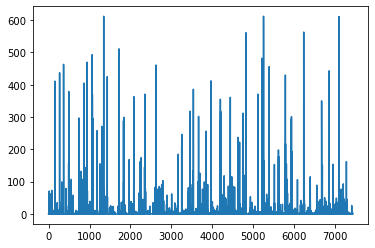

USER
31.98223209328151 16.01331052789318


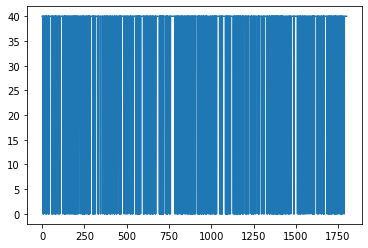

FEATURES


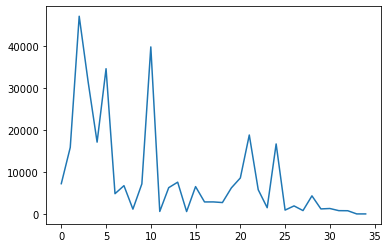

In [25]:
user_hit, item_hit, feature_hit = visualize_hit(user_interaction = train_user_interaction, review=train_review)

ITEM
0.9687836383207751 5.048456768487228


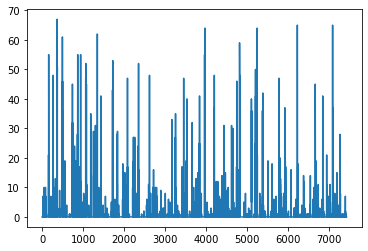

USER
3.997779011660189 11.99703811114797


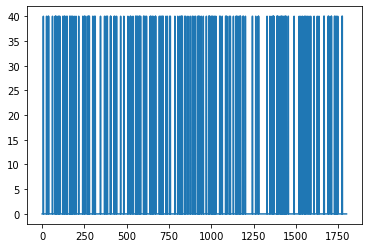

FEATURES


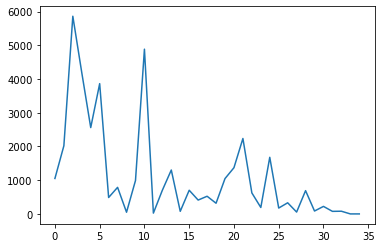

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1051, 2021, 5863, 4190, 2561, 3864,  487,  788,   50,  990, 4886,
          24,  701, 1302,   77,  702,  411,  524,  317, 1048, 1371, 2237,
         623,  191, 1679,  174,  330,   55,  690,   86,  223,   76,   80,
           0,    0]))

In [26]:
visualize_hit(user_interaction = test_user_interaction, review=test_review)

In [27]:
def get_item_opinion():
#     op = np.zeros((num_items, num_features))
#     for rid in range(len(train_user_interaction)):
#         _, i = train_user_interaction[rid]
#         features = train_review[rid]!=1
#         op[i, features] += 1
    op = np.zeros((num_items, num_features))

    for i in item_dict:
        features = list(map(int,item_dict[i]['feature_index']))
        op[int(i),features] += 1
#     row_sums = op.sum(axis=1)
#     new_matrix = op / row_sums[:, np.newaxis]
#     new_matrix[np.isnan(new_matrix)] = 0
    return op

train_item_opinion = get_item_opinion()
train_item_opinion

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [28]:
item_opinion.max(), train_item_opinion.max()

(1.0, 1.0)

In [29]:
def loadSUV(i):
    SU = np.load('lastfm-SU-{}.npy'.format(i))
    V = np.load('lastfm-V-{}.npy'.format(i))
    return SU, V

def saveSUV(i):
    np.save('lastfm-SU-{}'.format(i), SU)
    np.save('lastfm-V-{}'.format(i), V)

In [31]:
# saveSUV(i=40)
# SU, V = loadSUV(i=40)

# SU.shape

In [99]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=40, init='random', random_state=0, max_iter = 500)
# SU = model.fit_transform(train_review)
# H = model.components_
# SU.shape
# SU

array([[1.33035062e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50441263e+00, 0.00000000e+00, 2.53058130e-08, ...,
        0.00000000e+00, 0.00000000e+00, 7.12868871e-10],
       [1.66180943e+00, 2.46894735e-02, 2.51974257e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.00349060e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.77342264e-08, ...,
        0.00000000e+00, 1.31095937e-08, 2.51796621e-01],
       [1.19198036e+00, 1.75947800e-04, 0.00000000e+00, ...,
        3.58096320e-04, 0.00000000e+00, 2.51796750e-01]])

In [100]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=40, init='random', random_state=0, max_iter = 200)
# V = model.fit_transform(item_opinion)
# H = model.components_
# V.shape
# V

array([[2.09382995e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.15029963e+00, 0.00000000e+00, 8.85717218e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.79979689e-10, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.45282224e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.17405905e+00, 0.00000000e+00, 9.42633593e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.73741961e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Let's calculate sr@1 first

In [32]:
### Let's calculate MR@1 first
def MRR1(SU, V, user_interaction):
    mrr = 0
    success = 0
    count = 0
    for review_id in np.random.choice(len(user_interaction), size = 5000):
        count += 1
        u, i = user_interaction[review_id]
        pred = -SU[review_id].dot(V.T)
#         sur = SU[review_id]
#         pred = np.sum(np.abs((Vr-sur))**2,axis=-1)

        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))

    print(mrr/(count), success/(count))


In [33]:
MRR1(SU, V, train_user_interaction)

19.999 0.541
19.6405 0.554
20.530666666666665 0.5456666666666666
20.69875 0.55275
20.8586 0.5512
20.8586 0.5512


# Learn SU and V simultaneously

In [34]:
V.max()

2.930763056209065

In [35]:
def get_rating_matrix():
    r = np.zeros((num_users, num_items))
    for u, i in train_user_interaction:
        r[u, i] = 1
    return r
rating_matrix = get_rating_matrix()
rating_matrix.sum()

57600.0

In [36]:
np.max(SU), np.max(V)

(4.615262070502254, 2.930763056209065)

In [37]:
# sr1(SU = SU, V=V, user_interaction = train_user_interaction)
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

20.239 0.538
21.6755 0.5365
21.723 0.5363333333333333
21.57975 0.54125
21.2874 0.5412
21.2874 0.5412


In [38]:
# Learn SU and V simultaneously
lambda_BPR = 0.1

num_SGDUpdate = len(train_user_interaction)

alpha = 0.001
beta = 0.01


ALPHA = 0.01
BETA = 0.01

assert ALPHA >= alpha

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sgd_update_SUV_rating(SU, V, num_iter, num_BPRpairs):
    
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            # Update user and item latent feature matrices
            sig = sigmoid(pred)
            e = 1-sig
        
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]

#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]


            not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
    
            for i in np.random.choice(not_rated_items, num_BPRpairs):
                pred = SU[review_id].dot(V[i].T)
                # Update user and item latent feature matrices
                sig = sigmoid(pred)
                e = 0-sig
                SU[review_id, :] +=  lambda_BPR*(ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:])
                V[i, :] += lambda_BPR*(ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:])
    
    return SU, V

In [108]:
SU, V = sgd_update_SUV_rating(SU, V, num_iter=10, num_BPRpairs = 5)

100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.17s/it]


In [109]:
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

385.904 0.127
388.143 0.1275
391.12966666666665 0.12833333333333333
394.749 0.12225
392.4162 0.1202
392.4162 0.1202


In [110]:
def MRR5(model, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
    
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))
    
    return success/count

In [111]:
# SUold = copy.deepcopy(SU)

In [112]:
# SU, V = loadSUV(i  = 0)

In [113]:
# MRR5(model = dt, V = V, user_interaction=train_user_interaction, reviews=train_review)

In [114]:
# MRR5(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)

# --------------------- Personalization -------------------------------------------

In [39]:
def sgd_update_SU(SU, V, num_iter):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1-sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  SU

In [40]:
def sgd_update_V(SU, V, num_iter, num_review):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_review):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1 - sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  V

In [41]:
def personalize(model, num_iter, num_review):
    SU_copy = copy.deepcopy(SU)
    
    V_predict = model.predict(item_opinion)
    V_predict= sgd_update_V(SU = SU_copy, V = V_predict, num_iter = num_iter, num_review = num_review)

#     SU_predict, V_copy = sgd_update_SUV_rating(SU = SU_predict, V = V_copy, num_iter = num_iter)
    
#     bpr_update_SUV_rating(SU = SU_predict, V = V_copy, num_BPRpairs = 10000)
    
    return SU_copy, V_predict



## Loop this 

In [118]:
from sklearn.ensemble import RandomForestRegressor as RF

In [119]:

def DTCRS(model, V, user_interaction, reviews):
    tc = 0
    success = 0
    count = 0
    mrr = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
    #         print("target:", i, "recommend:", recommend)
    #         time.sleep(1)
        rank = np.where(recommend == i)[0][0]

        mrr += (rank+1)

        if ( rank < (T - depth)*10): # success
            tc += depth + (rank //10)  + 1
            success += 1
        else: # failed
            tc += T

        if((count) % 1000 == 0):
            print(mrr/(count), tc/count, success/(count))
    return success/(count)

# DTCRS(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)


In [147]:

val_sr = 0
for i in range(20):
    Vold = copy.deepcopy(V)
    dtitem = RF(max_depth = 10)
    dtitem.fit(item_opinion, V)
    _, V = personalize(dtitem, 150, len(train_user_interaction))
    SU, V = sgd_update_SUV_rating(SU, V, num_iter=30, num_BPRpairs = 5)
    print("norm diff:", ((V-Vold)**2).sum())
    
    depth = 5
    from sklearn.tree import DecisionTreeRegressor as DT
    dt = DT(max_depth = depth)
    dt.fit(train_review, SU)
    
    print("single rec:", MRR5(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review))
    
    print("MRR1:")
    MRR1(SU = SU, V=V, user_interaction = train_user_interaction)
    
    new_val_sr = DTCRS(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)
    print("new validation success rate:", new_val_sr)
    
    if(new_val_sr < val_sr):
        V = Vold
        break
    else:
        val_sr = new_val_sr
    

100%|███████████████████████████████████████████| 30/30 [05:05<00:00, 10.19s/it]


norm diff: 3029.366459764516
232.605 0.158
215.9755 0.1615
221.79433333333333 0.15066666666666667
224.10575 0.1535
223.9022 0.155
221.61016666666666 0.15733333333333333
218.48228571428572 0.15757142857142858
single: 0.15666666666666668
MRR1:
123.699 0.339
125.0815 0.3505
122.26033333333334 0.345
121.261 0.34275
118.879 0.3504
118.879 0.3504
232.605 8.905 0.402
215.9755 8.8995 0.404
221.79433333333333 8.928333333333333 0.401
224.10575 8.92275 0.401
223.9022 8.9238 0.401
221.61016666666666 8.9195 0.4008333333333333
218.48228571428572 8.913142857142857 0.40185714285714286
new validation success rate: 0.40194444444444444


100%|███████████████████████████████████████████| 30/30 [05:10<00:00, 10.34s/it]


norm diff: 1521.097397659236
138.37 0.202
129.324 0.207
131.006 0.196
134.49625 0.19925
134.1048 0.2008
131.09133333333332 0.20183333333333334
129.08471428571428 0.2027142857142857
single: 0.20305555555555554
MRR1:
45.623 0.45
45.055 0.44
44.74966666666667 0.43966666666666665
45.09875 0.44425
44.1918 0.4422
44.1918 0.4422
138.37 8.481 0.595
129.324 8.492 0.583
131.006 8.532666666666668 0.5746666666666667
134.49625 8.52675 0.5715
134.1048 8.5266 0.571
131.09133333333332 8.517833333333334 0.5728333333333333
129.08471428571428 8.505714285714285 0.5768571428571428
new validation success rate: 0.5766666666666667


100%|███████████████████████████████████████████| 30/30 [05:08<00:00, 10.28s/it]


norm diff: 787.3081225496383
120.867 0.228
113.389 0.229
114.31866666666667 0.21666666666666667
117.493 0.21775
117.723 0.2196
114.75666666666666 0.22116666666666668
113.002 0.22228571428571428
single: 0.22194444444444444
MRR1:
22.547 0.523
23.777 0.5105
24.319 0.5136666666666667
25.14275 0.5095
24.8328 0.508
24.8328 0.508
120.867 8.34 0.639
113.389 8.345 0.6225
114.31866666666667 8.387666666666666 0.616
117.493 8.3825 0.61275
117.723 8.3818 0.6116
114.75666666666666 8.3725 0.6135
113.002 8.362285714285715 0.6162857142857143
new validation success rate: 0.6154166666666666


100%|███████████████████████████████████████████| 30/30 [05:11<00:00, 10.38s/it]


norm diff: 433.2272108646491
117.012 0.233
109.232 0.23
110.56 0.21833333333333332
113.43375 0.2195
114.4084 0.2218
111.7575 0.22283333333333333
109.64942857142857 0.22371428571428573
single: 0.22333333333333333
MRR1:
22.252 0.517
22.066 0.538
21.773 0.5363333333333333
21.99975 0.53375
22.1052 0.5288
22.1052 0.5288
117.012 8.314 0.649
109.232 8.3295 0.6285
110.56 8.370666666666667 0.621
113.43375 8.36625 0.61875
114.4084 8.3672 0.6168
111.7575 8.360666666666667 0.6186666666666667
109.64942857142857 8.35057142857143 0.6208571428571429
new validation success rate: 0.6201388888888889


100%|███████████████████████████████████████████| 30/30 [05:07<00:00, 10.25s/it]


norm diff: 269.9562111167954
115.707 0.23
107.507 0.23
108.70333333333333 0.21966666666666668
111.56425 0.21975
112.9318 0.2212
110.274 0.22166666666666668
108.079 0.22142857142857142
single: 0.22125
MRR1:
20.691 0.532
21.1015 0.5245
21.002 0.5336666666666666
20.917 0.53175
20.854 0.5316
20.854 0.5316
115.707 8.331 0.642
107.507 8.329 0.6275
108.70333333333333 8.366 0.6206666666666667
111.56425 8.36025 0.61925
112.9318 8.3598 0.6158
110.274 8.354333333333333 0.6176666666666667
108.079 8.345 0.6195714285714286
new validation success rate: 0.6190277777777777


In [121]:
# rf = RF(max_depth = depth)
# rf.fit(train_review, SU)
# MRR5(model = rf, V = V, user_interaction=test_user_interaction, reviews=test_review)

## end loop
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# Super User FacT

In [42]:
train_review.shape

(57600, 35)

In [43]:
class Node:
    def __init__(self, parent, vector, members, used_features):
        self.parent = parent
        self.vector = vector
        self.members = members        
        self.used_features = used_features
        
        self.feature = None
        self.pos_node = None
        self.neg_node = None
#         self.unknown_node = None
        
        self.error = np.inf
        

In [44]:
PARTIAL = 0.9





class Tree:
    def __init__(self, tree_type):
        assert tree_type in ["review", "item"]
        self.tree_type = tree_type
        if(self.tree_type == "review"):
            root_error, root_vector = fit(idx = np.array(range(len(train_user_interaction))), 
                                          training_type = tree_type,
                                          node_vector = np.mean(SU, axis=0), 
                                          SU = SU, V = V, num_iter=num_FIT, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.random.choice(len(train_user_interaction), int(PARTIAL * len(train_user_interaction))), used_features = [])
            self.root.error = root_error

        elif(self.tree_type == "item"):
            root_error, root_vector = fit(idx = np.array(range(num_items)), 
                                          training_type = tree_type,
                                          node_vector = np.mean(V, axis=0), 
                                          SU = SU, V = V, num_iter=0, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.array(range(num_items)), used_features = [])
            self.root.error = root_error
        else:
            raise ValueError("Invalid tree type")
        
#         review_tree_condition = (tree_type == "review" and len(self.root.members) == len(train_user_interaction))
#         item_tree_condition = (tree_type == "item" and len(self.root.members) == num_items)
        
#         assert review_tree_condition or item_tree_condition        

In [45]:
def squared_error_and_mse(true, pred):
    '''I am assuming true and pred both to be 1-D array'''
    assert pred.ndim == 1
    error = ((true - pred)**2).sum()
    return error, error/len(pred)

In [46]:
def sgd_update_review_vector(single_vector, V, review_indices, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in (review_indices):
            u, i = train_user_interaction[review_id]
            pred = sigmoid(single_vector.dot(V[i].T))
            e = 1 - pred ## note single vector being used in prediction
            single_vector += ALPHA *  (e * V[i, :] -  BETA * single_vector)
            
            error += np.log(e)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR * ALPHA *  (e * V[i, :] -  BETA * single_vector)
#                 error += e

                
    return single_vector, error/num_iter

In [47]:
def sgd_update_item_vector(SU, single_vector, item_indices, review_idx, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in review_idx:
            u, i = train_user_interaction[review_id]
            pred = sigmoid(SU[review_id].dot(single_vector.T))
            e = 1 - pred ## note review_id being used in prediction
            
            error += e
            # Update user and item latent feature matrices
            single_vector += ALPHA * (e * SU[review_id] - BETA * single_vector)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR*ALPHA * (e * SU[review_id] - BETA * single_vector)
#                 error += e
                
    return single_vector, error

In [48]:
def fit(idx, training_type, node_vector, SU, V, num_iter, num_BPRpairs):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if idx is None or (len(idx) == 0):
        return 0, None
    
    single_vector = copy.deepcopy(node_vector) ## we don't want to change node vector yet
    
    if training_type == "review":
        single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
        single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    return error, single_vector

In [49]:

# SUmean = np.zeros_like(SU)
# e, su = fit(idx = np.array(range(len(train_user_interaction))), 
#                                           training_type = "review",
#                                           node_vector = np.mean(SU, axis=0), 
#                                           SU = SU, V = V, num_iter = 5, num_BPRpairs=1)
# SUmean = SUmean + su
# SUmean, e

In [50]:
# MRR1(SU = SUmean, V=V, user_interaction = train_user_interaction)

# -----------------------------------------------------------------------------------------

In [51]:
# @nb.njit(parallel=True)
# def var_nb(a, ddof=0):
#     n = len(a)
#     s = a.sum()
#     m = s / (n - ddof)
#     v = 0
#     for i in nb.prange(n):
#         v += (a[i] - m) ** 2
#     return v / (n - ddof)

In [52]:
def get_error(idx, training_type):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if (len(idx) == 0):
        return 0
    
    
    if training_type == "review":
#         single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
#         single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    
    error = ((SU[review_idx, :] - SU[review_idx, :].mean(axis = 0))**2).sum()
#     error = SU[review_idx, :].var()

    return error

# -----------------------------------------------------------------------------------------

In [53]:
VERBOSE = 0.4

def find_best_split(node, training_type, flist):    
    '''
    I will assume node.members is non-empty
    if training_type == review => we are updating SU keeping V fixed
    if training_type == item => we are updating V keeping SU fixed
    '''
    if node.members is None or len(node.members) == 0:
        node = None
        return None
    members = node.members
    
    assert training_type in ["review", "item"]
    if(training_type == "review"):
        opinion_matrix = train_review
    elif(training_type == "item"):
        opinion_matrix = train_item_opinion
        
    
    
    
    best_feature = None
    lowest_avg_error = np.inf
    lowest_pos_error = np.inf
    lowest_neg_error = np.inf

    best_pos_members = None
    best_neg_members = None
    
    best_pos_single_vector = None
    best_neg_single_vector = None
    
    
    for feature in flist:
        
        if (feature in node.used_features):
            continue
            
        pos_idx = []
        neg_idx = []
        
        for r in node.members:
            val = opinion_matrix[r, feature]
            if(val > 0):
                pos_idx.append(r)
            else:
                neg_idx.append(r)

        pos_idx = np.array(pos_idx)
        neg_idx = np.array(neg_idx)
        
        assert len(pos_idx) + len(neg_idx)  == len(node.members)
        
        pos_error, pos_single_vector  = fit(idx = pos_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        neg_error, neg_single_vector = fit(idx = neg_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        
#         pos_error = get_error(idx = pos_idx, training_type = training_type)  #must use the fit method to get error
#         neg_error = get_error(idx = neg_idx, training_type = training_type)
        
        w_pos = 1 #len(pos_idx)/len(members)
        w_neg = 1 #len(neg_idx)/len(members)
        
        
        avg_error = w_pos*pos_error + w_neg*neg_error
        
        if (random.random() < VERBOSE):
            print("feature {} avg. error: {}, ratio: {}, pos:{}, neg: {}".format(feature,  avg_error, len(pos_idx)/len(members), len(pos_idx), len(neg_idx)))
        
        ## Update carefully:
        if(avg_error < lowest_avg_error):
            
            lowest_avg_error = avg_error
            best_feature = feature
            
            lowest_pos_error = pos_error
            lowest_neg_error = neg_error
            
            best_pos_members = pos_idx
            best_neg_members = neg_idx

    node.used_features.extend([best_feature])
    
    lowest_pos_error, best_pos_single_vector  = fit(idx = best_pos_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    lowest_neg_error, best_neg_single_vector = fit(idx = best_neg_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    
    
    return (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector)

In [56]:
review_tree = Tree(tree_type = "review")
review_tree.root.vector

array([ 0.27421799,  0.22703672,  0.03557866,  0.60667533, -0.05799112,
        0.28857431,  0.32729774,  1.28960789,  0.15677131,  0.45418968,
        0.63829465,  0.87243468,  0.2978106 ,  0.67938902,  0.50802628,
        0.35866559,  0.65576896,  0.26206   ,  0.45630059,  0.11002225,
        0.5866358 ,  0.64694523,  0.96859361,  0.25241524,  0.34262518,
        0.22717875,  0.53431929,  0.69518355,  0.13312123,  0.37092741,
        0.74772008,  0.30497586,  0.30168557,  0.29393702,  0.27705844,
        0.31296362,  0.24928329, -0.20475732,  0.14281932,  0.10385405])

In [57]:
review_tree.root.feature

In [58]:
# itmset = set(train_user_interaction[review_tree.root.members,1])
# GINI = 1
# if(len(review_tree.root.members) > 0):
#     GINI -= (len(itmset)/len(review_tree.root.members))**2
#     print(GINI)

# -----------------------------------------------------------------------------------------

In [59]:
def create_tree(tree_type, node, depth, flist):
    if (depth > MAX_DEPTH):
        print("MAX DEPTH REACHED: {}".format(MAX_DEPTH))
        return
    
    if (node.feature is None):
        best = find_best_split(node = node, training_type = tree_type, flist = flist)
        
#         print(best)
        
        if best is None:
            print("best is none")
            return
        
        
        ## early stopping GINI Index
#         itmset = set(train_user_interaction[node.members,1])
#         GINI = 1
#         if(len(node.members) > 0):
#             GINI -= (len(itmset)/len(node.members))**2
#         if (GINI > 0.9967):
#             return
            
        
        
        
        (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector) = best
        node.feature = best_feature
        
        
        
        
        node.error = lowest_pos_error + lowest_neg_error #lowest_avg_error
        
        node.pos_node = Node(parent = node, vector = best_pos_single_vector, members = best_pos_members, used_features = node.used_features.copy())
        node.neg_node = Node(parent = node, vector = best_neg_single_vector, members = best_neg_members, used_features = node.used_features.copy())

    else:
        print("CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................")
    
    
    print("depth: {}, best feature id:{}, error:{}".format(depth, node.feature, node.error))    

    print("# of pos members: ", 0 if node.pos_node.members is None else len(node.pos_node.members))
    print('# of neg members: ', 0 if node.neg_node.members is None else len(node.neg_node.members))

    create_tree(tree_type = tree_type, node = node.pos_node, depth = depth +1, flist = flist)

    create_tree(tree_type = tree_type, node = node.neg_node, depth = depth +1, flist = flist)


In [60]:
MAX_DEPTH = 7

In [63]:

num_iter_review = 1
num_iter_item = 1

num_FIT = 20

create_tree(tree_type = 'review', node = review_tree.root, depth=0, flist = list(range(num_features)))


# np.save('zlastfm-review-tree-40.npy', review_tree)

CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 0, best feature id:5, error:-193525.84130552516
# of pos members:  31162
# of neg members:  20678
feature 7 avg. error: -127133.08724695415, ratio: 0.18942943328412812, pos:5903, neg: 25259
feature 11 avg. error: -125590.19900123109, ratio: 0.0025351389512868238, pos:79, neg: 31083
feature 13 avg. error: -126484.6645056925, ratio: 0.06796739618766447, pos:2118, neg: 29044
feature 17 avg. error: -125502.51042953075, ratio: 0.01325332135292985, pos:413, neg: 30749
feature 19 avg. error: -125902.20369713297, ratio: 0.05959181053847635, pos:1857, neg: 29305
feature 26 avg. error: -125641.93735883196, ratio: 0.004909826070213722, pos:153, neg: 31009
feature 29 avg. error: -125557.31702058516, ratio: 0.004171747641358065, pos:130, neg: 31032
feature 32 avg. error: -125583.12255852643, ratio: 0.0020858738206790324, pos:65, neg: 31097
feature 33 avg. error: -125503.64841017347, ratio: 0.0, pos:0, neg: 31162
feature 34 avg.

feature 19 avg. error: -10074.95466974762, ratio: 0.009229349330872173, pos:20, neg: 2147
feature 21 avg. error: -10080.92025974776, ratio: 0.49653899400092294, pos:1076, neg: 1091
feature 22 avg. error: -10086.398059323554, ratio: 0.10613751730503, pos:230, neg: 1937
feature 23 avg. error: -10079.766088913966, ratio: 0.00046146746654360867, pos:1, neg: 2166
feature 27 avg. error: -10079.815486435537, ratio: 0.0009229349330872173, pos:2, neg: 2165
feature 28 avg. error: -10079.748794512474, ratio: 0.0, pos:0, neg: 2167
feature 30 avg. error: -10079.608049037019, ratio: 0.0023073373327180432, pos:5, neg: 2162
feature 31 avg. error: -10079.748794512474, ratio: 0.0, pos:0, neg: 2167
feature 32 avg. error: -10079.748794512474, ratio: 0.0, pos:0, neg: 2167
depth: 6, best feature id:22, error:-10084.350159819374
# of pos members:  230
# of neg members:  1937
feature 8 avg. error: -1086.0154963636262, ratio: 0.0, pos:0, neg: 230
feature 12 avg. error: -1086.0154963636262, ratio: 0.0, pos:0, n

depth: 6, best feature id:20, error:-23109.262263603356
# of pos members:  566
# of neg members:  4660
feature 6 avg. error: -2633.942706996188, ratio: 0.0, pos:0, neg: 566
feature 9 avg. error: -2634.5801795482053, ratio: 0.15547703180212014, pos:88, neg: 478
feature 11 avg. error: -2633.942706996188, ratio: 0.0, pos:0, neg: 566
feature 12 avg. error: -2634.960089297858, ratio: 0.13250883392226148, pos:75, neg: 491
feature 13 avg. error: -2633.17664228181, ratio: 0.05653710247349823, pos:32, neg: 534
feature 16 avg. error: -2634.103393863901, ratio: 0.0353356890459364, pos:20, neg: 546
feature 17 avg. error: -2633.942706996188, ratio: 0.0, pos:0, neg: 566
feature 25 avg. error: -2633.942706996188, ratio: 0.0, pos:0, neg: 566
feature 28 avg. error: -2634.1918473236183, ratio: 0.015901060070671377, pos:9, neg: 557
feature 29 avg. error: -2633.942706996188, ratio: 0.0, pos:0, neg: 566
depth: 7, best feature id:12, error:-2638.447844938609
# of pos members:  75
# of neg members:  491
MAX 

feature 30 avg. error: -3200.9365295840125, ratio: 0.0014144271570014145, pos:1, neg: 706
depth: 6, best feature id:21, error:-3203.88150700652
# of pos members:  219
# of neg members:  488
feature 1 avg. error: -993.1686705185966, ratio: 0.0273972602739726, pos:6, neg: 213
feature 8 avg. error: -993.2110098733848, ratio: 0.0, pos:0, neg: 219
feature 14 avg. error: -993.2103209428454, ratio: 0.0045662100456621, pos:1, neg: 218
feature 19 avg. error: -993.2201100624279, ratio: 0.0045662100456621, pos:1, neg: 218
feature 22 avg. error: -993.2396414311088, ratio: 0.0228310502283105, pos:5, neg: 214
feature 25 avg. error: -993.2110098733848, ratio: 0.0, pos:0, neg: 219
feature 28 avg. error: -993.2270963899552, ratio: 0.0136986301369863, pos:3, neg: 216
feature 29 avg. error: -993.2110098733848, ratio: 0.0, pos:0, neg: 219
feature 32 avg. error: -993.2417176705952, ratio: 0.0091324200913242, pos:2, neg: 217
depth: 7, best feature id:12, error:-994.7818745360746
# of pos members:  55
# of n

feature 26 avg. error: -3748.593933745938, ratio: 0.005636978579481398, pos:5, neg: 882
feature 27 avg. error: -3748.9332310854397, ratio: 0.005636978579481398, pos:5, neg: 882
feature 29 avg. error: -3749.6328844273903, ratio: 0.030439684329199548, pos:27, neg: 860
feature 30 avg. error: -3747.893745355942, ratio: 0.040586245772266064, pos:36, neg: 851
feature 31 avg. error: -3749.131038720242, ratio: 0.038331454340473504, pos:34, neg: 853
feature 34 avg. error: -3748.5669859372792, ratio: 0.0, pos:0, neg: 887
depth: 7, best feature id:15, error:-3762.551780346248
# of pos members:  208
# of neg members:  679
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -4272.646514088838, ratio: 0.4539594843462247, pos:493, neg: 593
feature 7 avg. error: -4261.381990714991, ratio: 0.0423572744014733, pos:46, neg: 1040
feature 9 avg. error: -4261.379163473187, ratio: 0.06077348066298342, pos:66, neg: 1020
feature 10 avg. error: -4284.404103259816, ratio: 0.8379373848987108, pos:910,

feature 1 avg. error: -861.9426257050957, ratio: 0.47959183673469385, pos:94, neg: 102
feature 6 avg. error: -861.941183146443, ratio: 0.09183673469387756, pos:18, neg: 178
feature 7 avg. error: -861.9629529297897, ratio: 0.19387755102040816, pos:38, neg: 158
feature 8 avg. error: -861.9261930535528, ratio: 0.0, pos:0, neg: 196
feature 21 avg. error: -862.0057475627566, ratio: 0.49489795918367346, pos:97, neg: 99
feature 23 avg. error: -861.9261930535528, ratio: 0.0, pos:0, neg: 196
feature 26 avg. error: -861.9870190611443, ratio: 0.04081632653061224, pos:8, neg: 188
feature 27 avg. error: -861.9261930535528, ratio: 0.0, pos:0, neg: 196
feature 28 avg. error: -861.9261930535528, ratio: 0.0, pos:0, neg: 196
feature 33 avg. error: -861.9261930535528, ratio: 0.0, pos:0, neg: 196
depth: 7, best feature id:21, error:-865.0228663591704
# of pos members:  97
# of neg members:  99
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -2059.2566233653456, ratio: 0.31176470588235294, 

feature 4 avg. error: -217.02862799308494, ratio: 0.3090909090909091, pos:17, neg: 38
feature 11 avg. error: -217.04601360661073, ratio: 0.0, pos:0, neg: 55
feature 12 avg. error: -217.05312345950028, ratio: 0.2, pos:11, neg: 44
feature 14 avg. error: -217.04384692446095, ratio: 0.01818181818181818, pos:1, neg: 54
feature 15 avg. error: -217.04601360661073, ratio: 0.0, pos:0, neg: 55
feature 16 avg. error: -217.04601360661073, ratio: 0.0, pos:0, neg: 55
feature 18 avg. error: -217.06083567275428, ratio: 0.03636363636363636, pos:2, neg: 53
feature 22 avg. error: -217.06283816236956, ratio: 0.05454545454545454, pos:3, neg: 52
feature 26 avg. error: -217.04601360661073, ratio: 0.0, pos:0, neg: 55
feature 27 avg. error: -217.05005697999067, ratio: 0.01818181818181818, pos:1, neg: 54
feature 32 avg. error: -217.04601360661073, ratio: 0.0, pos:0, neg: 55
feature 34 avg. error: -217.04601360661073, ratio: 0.0, pos:0, neg: 55
depth: 6, best feature id:0, error:-219.137860114984
# of pos member

feature 2 avg. error: -71817.16988702476, ratio: 0.7087115974268021, pos:11788, neg: 4845
feature 6 avg. error: -70247.33745351333, ratio: 0.21884206096314554, pos:3640, neg: 12993
feature 7 avg. error: -70493.99033774168, ratio: 0.3400468947273492, pos:5656, neg: 10977
feature 19 avg. error: -70263.16304344915, ratio: 0.06907954067215775, pos:1149, neg: 15484
feature 21 avg. error: -71046.88587934432, ratio: 0.5323753983045753, pos:8855, neg: 7778
feature 23 avg. error: -70128.17091120419, ratio: 0.012805867853063188, pos:213, neg: 16420
feature 24 avg. error: -71839.77616017022, ratio: 0.6713160584380449, pos:11166, neg: 5467
feature 26 avg. error: -70149.15677170805, ratio: 0.003126315156616365, pos:52, neg: 16581
feature 28 avg. error: -69978.03215609293, ratio: 0.005952023086635003, pos:99, neg: 16534
feature 29 avg. error: -70054.32306788414, ratio: 0.0025251007034209102, pos:42, neg: 16591
feature 30 avg. error: -69998.0478051907, ratio: 0.002464979258101365, pos:41, neg: 16592


feature 8 avg. error: -5170.150478396207, ratio: 0.010958904109589041, pos:12, neg: 1083
feature 9 avg. error: -5168.313791309754, ratio: 0.011872146118721462, pos:13, neg: 1082
feature 10 avg. error: -5164.314422639899, ratio: 0.9899543378995433, pos:1084, neg: 11
feature 14 avg. error: -5169.830799516921, ratio: 0.0, pos:0, neg: 1095
feature 26 avg. error: -5169.830799516921, ratio: 0.0, pos:0, neg: 1095
feature 29 avg. error: -5169.830799516921, ratio: 0.0, pos:0, neg: 1095
feature 34 avg. error: -5169.830799516921, ratio: 0.0, pos:0, neg: 1095
depth: 7, best feature id:8, error:-5170.781012469312
# of pos members:  12
# of neg members:  1083
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 7 avg. error: -27227.40004821512, ratio: 0.34381478921907394, pos:1990, neg: 3798
feature 11 avg. error: -27182.20869258259, ratio: 0.0, pos:0, neg: 5788
feature 13 avg. error: -27175.574726839957, ratio: 0.0017277125086385626, pos:10, neg: 5778
feature 14 avg. error: -27182.20869258259, ratio: 

depth: 7, best feature id:8, error:-15173.741882511289
# of pos members:  50
# of neg members:  3190
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -16531.636231916804, ratio: 0.5494226978315967, pos:1951, neg: 1600
feature 6 avg. error: -16517.775994451866, ratio: 0.35736412278231483, pos:1269, neg: 2282
feature 7 avg. error: -16514.101127944712, ratio: 0.5460433680653337, pos:1939, neg: 1612
feature 9 avg. error: -16499.75077651601, ratio: 0.017459870459025625, pos:62, neg: 3489
feature 15 avg. error: -16499.37611127233, ratio: 0.0036609405801182764, pos:13, neg: 3538
feature 16 avg. error: -16476.66921294591, ratio: 0.03886229231202478, pos:138, neg: 3413
feature 17 avg. error: -16500.540255796142, ratio: 0.0030977189524077726, pos:11, neg: 3540
feature 18 avg. error: -16480.132471517427, ratio: 0.014362151506617854, pos:51, neg: 3500
feature 21 avg. error: -16539.499945315052, ratio: 0.5902562658406083, pos:2096, neg: 1455
feature 29 avg. error: -16503.188707383317

feature 30 avg. error: -6576.015813895237, ratio: 0.0013745704467353953, pos:2, neg: 1453
feature 32 avg. error: -6577.154085206025, ratio: 0.0, pos:0, neg: 1455
feature 33 avg. error: -6577.154085206025, ratio: 0.0, pos:0, neg: 1455
depth: 5, best feature id:7, error:-6603.611102587725
# of pos members:  744
# of neg members:  711
feature 4 avg. error: -3518.1779225394785, ratio: 0.008064516129032258, pos:6, neg: 738
feature 6 avg. error: -3519.014444238941, ratio: 0.6021505376344086, pos:448, neg: 296
feature 8 avg. error: -3518.839337085876, ratio: 0.09946236559139784, pos:74, neg: 670
feature 9 avg. error: -3516.4164372703235, ratio: 0.020161290322580645, pos:15, neg: 729
feature 10 avg. error: -3514.2282163338987, ratio: 0.989247311827957, pos:736, neg: 8
feature 11 avg. error: -3517.9218070909633, ratio: 0.0, pos:0, neg: 744
feature 16 avg. error: -3517.313808802428, ratio: 0.024193548387096774, pos:18, neg: 726
feature 19 avg. error: -3517.9218070909633, ratio: 0.0, pos:0, neg: 

feature 21 avg. error: -17377.40092822411, ratio: 0.3182362808531033, pos:1328, neg: 2845
feature 25 avg. error: -17206.708123796456, ratio: 0.014857416726575605, pos:62, neg: 4111
feature 26 avg. error: -17223.452135154977, ratio: 0.003834172058471124, pos:16, neg: 4157
feature 27 avg. error: -17268.5958263003, ratio: 0.056074766355140186, pos:234, neg: 3939
feature 34 avg. error: -17224.889219863348, ratio: 0.0, pos:0, neg: 4173
depth: 4, best feature id:10, error:-17686.368734452913
# of pos members:  3055
# of neg members:  1118
feature 0 avg. error: -12962.653293185555, ratio: 0.08772504091653027, pos:268, neg: 2787
feature 1 avg. error: -12981.481723804332, ratio: 0.21178396072013092, pos:647, neg: 2408
feature 6 avg. error: -12985.33174805014, ratio: 0.05990180032733224, pos:183, neg: 2872
feature 8 avg. error: -12972.116045291079, ratio: 0.02618657937806874, pos:80, neg: 2975
feature 9 avg. error: -12999.156330684698, ratio: 0.22225859247135843, pos:679, neg: 2376
feature 17 av

depth: 6, best feature id:19, error:-2489.5765404642616
# of pos members:  245
# of neg members:  302
feature 0 avg. error: -1158.9884093478202, ratio: 0.0, pos:0, neg: 245
feature 12 avg. error: -1158.688135389687, ratio: 0.02040816326530612, pos:5, neg: 240
feature 20 avg. error: -1158.957472665053, ratio: 0.7877551020408163, pos:193, neg: 52
feature 22 avg. error: -1158.9884093478202, ratio: 0.0, pos:0, neg: 245
feature 25 avg. error: -1158.8900327868284, ratio: 0.004081632653061225, pos:1, neg: 244
feature 27 avg. error: -1158.9838723794574, ratio: 0.02857142857142857, pos:7, neg: 238
feature 30 avg. error: -1158.9884093478202, ratio: 0.0, pos:0, neg: 245
feature 32 avg. error: -1158.9884093478202, ratio: 0.0, pos:0, neg: 245
feature 34 avg. error: -1158.9884093478202, ratio: 0.0, pos:0, neg: 245
depth: 7, best feature id:17, error:-1159.0318031505137
# of pos members:  6
# of neg members:  239
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -1335.001069018527, rati

feature 32 avg. error: -1388.1085636292066, ratio: 0.0, pos:0, neg: 312
depth: 6, best feature id:1, error:-1393.3059903736507
# of pos members:  174
# of neg members:  138
feature 6 avg. error: -766.0741232955044, ratio: 0.10919540229885058, pos:19, neg: 155
feature 8 avg. error: -765.9981776827656, ratio: 0.0, pos:0, neg: 174
feature 11 avg. error: -765.9981776827656, ratio: 0.0, pos:0, neg: 174
feature 14 avg. error: -765.9981776827656, ratio: 0.0, pos:0, neg: 174
feature 15 avg. error: -765.8642352402754, ratio: 0.011494252873563218, pos:2, neg: 172
feature 18 avg. error: -765.9981776827656, ratio: 0.0, pos:0, neg: 174
feature 19 avg. error: -765.9981776827656, ratio: 0.0, pos:0, neg: 174
feature 20 avg. error: -766.1466162379352, ratio: 0.14367816091954022, pos:25, neg: 149
feature 23 avg. error: -765.9981776827656, ratio: 0.0, pos:0, neg: 174
feature 28 avg. error: -766.0149884049968, ratio: 0.034482758620689655, pos:6, neg: 168
feature 29 avg. error: -765.9981776827656, ratio: 0

feature 19 avg. error: -791.723315715248, ratio: 0.13333333333333333, pos:30, neg: 195
feature 20 avg. error: -792.1943209889879, ratio: 0.2222222222222222, pos:50, neg: 175
feature 21 avg. error: -792.1867074837672, ratio: 0.21777777777777776, pos:49, neg: 176
feature 25 avg. error: -791.62792492526, ratio: 0.035555555555555556, pos:8, neg: 217
feature 26 avg. error: -792.1323738606592, ratio: 0.09777777777777778, pos:22, neg: 203
feature 31 avg. error: -791.5610019483622, ratio: 0.04, pos:9, neg: 216
feature 34 avg. error: -791.4592991950082, ratio: 0.0, pos:0, neg: 225
depth: 6, best feature id:0, error:-819.5729464453754
# of pos members:  108
# of neg members:  117
feature 1 avg. error: -410.59211390767484, ratio: 0.4166666666666667, pos:45, neg: 63
feature 4 avg. error: -410.57171216437774, ratio: 0.12962962962962962, pos:14, neg: 94
feature 9 avg. error: -410.57659629885154, ratio: 0.42592592592592593, pos:46, neg: 62
feature 11 avg. error: -410.60531756726135, ratio: 0.04629629

depth: 4, best feature id:20, error:-29094.740132475967
# of pos members:  1141
# of neg members:  5428
feature 0 avg. error: -5206.3405572409, ratio: 0.06573181419807186, pos:75, neg: 1066
feature 4 avg. error: -5206.269797012339, ratio: 0.5907099035933392, pos:674, neg: 467
feature 6 avg. error: -5204.904358743002, ratio: 0.0, pos:0, neg: 1141
feature 8 avg. error: -5204.904358743002, ratio: 0.0, pos:0, neg: 1141
feature 14 avg. error: -5204.904358743002, ratio: 0.0, pos:0, neg: 1141
feature 17 avg. error: -5208.113007007457, ratio: 0.07274320771253287, pos:83, neg: 1058
feature 18 avg. error: -5201.334828563673, ratio: 0.15249780893952672, pos:174, neg: 967
feature 24 avg. error: -5200.355379656449, ratio: 0.015775635407537247, pos:18, neg: 1123
feature 26 avg. error: -5205.806584205255, ratio: 0.022787028921998246, pos:26, neg: 1115
feature 29 avg. error: -5204.71443638227, ratio: 0.0017528483786152498, pos:2, neg: 1139
feature 34 avg. error: -5204.904358743002, ratio: 0.0, pos:0, 

feature 17 avg. error: -23892.71149421955, ratio: 0.0397936624907885, pos:216, neg: 5212
feature 27 avg. error: -23874.106480975464, ratio: 0.00018422991893883567, pos:1, neg: 5427
feature 31 avg. error: -23870.511361264424, ratio: 0.004789977892409728, pos:26, neg: 5402
feature 33 avg. error: -23874.020725375085, ratio: 0.0, pos:0, neg: 5428
feature 34 avg. error: -23874.020725375085, ratio: 0.0, pos:0, neg: 5428
depth: 5, best feature id:0, error:-23922.463868548017
# of pos members:  1061
# of neg members:  4367
feature 1 avg. error: -4815.435367627823, ratio: 0.23751178133836004, pos:252, neg: 809
feature 6 avg. error: -4812.505976024406, ratio: 0.000942507068803016, pos:1, neg: 1060
feature 7 avg. error: -4812.498479163109, ratio: 0.0, pos:0, neg: 1061
feature 11 avg. error: -4812.498479163109, ratio: 0.0, pos:0, neg: 1061
feature 12 avg. error: -4814.841298697644, ratio: 0.2403393025447691, pos:255, neg: 806
feature 13 avg. error: -4812.498479163109, ratio: 0.0, pos:0, neg: 1061


depth: 4, best feature id:18, error:-3926.7410486941
# of pos members:  267
# of neg members:  662
feature 1 avg. error: -1186.561787703562, ratio: 0.651685393258427, pos:174, neg: 93
feature 7 avg. error: -1186.368425417974, ratio: 0.0, pos:0, neg: 267
feature 8 avg. error: -1186.368425417974, ratio: 0.0, pos:0, neg: 267
feature 9 avg. error: -1186.6248931089765, ratio: 0.052434456928838954, pos:14, neg: 253
feature 11 avg. error: -1186.368425417974, ratio: 0.0, pos:0, neg: 267
feature 13 avg. error: -1186.368425417974, ratio: 0.0, pos:0, neg: 267
feature 15 avg. error: -1186.3028702430317, ratio: 0.0149812734082397, pos:4, neg: 263
feature 17 avg. error: -1186.6896583731686, ratio: 0.06741573033707865, pos:18, neg: 249
feature 19 avg. error: -1186.3645380455453, ratio: 0.8314606741573034, pos:222, neg: 45
feature 22 avg. error: -1186.3874393679612, ratio: 0.003745318352059925, pos:1, neg: 266
feature 23 avg. error: -1186.3745347834345, ratio: 0.0299625468164794, pos:8, neg: 259
featu

depth: 5, best feature id:4, error:-2782.8178422968876
# of pos members:  409
# of neg members:  253
feature 8 avg. error: -1705.7181111190232, ratio: 0.0, pos:0, neg: 409
feature 11 avg. error: -1705.7181111190232, ratio: 0.0, pos:0, neg: 409
feature 15 avg. error: -1705.8168372560308, ratio: 0.19070904645476772, pos:78, neg: 331
feature 17 avg. error: -1705.858467149975, ratio: 0.009779951100244499, pos:4, neg: 405
feature 19 avg. error: -1705.8428275078415, ratio: 0.03667481662591687, pos:15, neg: 394
feature 21 avg. error: -1705.7028755160377, ratio: 0.09535452322738386, pos:39, neg: 370
feature 22 avg. error: -1705.8802750473983, ratio: 0.03178484107579462, pos:13, neg: 396
feature 23 avg. error: -1705.9501606786077, ratio: 0.07823960880195599, pos:32, neg: 377
feature 28 avg. error: -1706.6893121923363, ratio: 0.3569682151589242, pos:146, neg: 263
feature 30 avg. error: -1705.2663519826385, ratio: 0.08801955990220049, pos:36, neg: 373
feature 32 avg. error: -1705.7181111190232, r

feature 29 avg. error: -9851.750880861544, ratio: 0.09803001876172608, pos:209, neg: 1923
feature 30 avg. error: -9837.958486508502, ratio: 0.0009380863039399625, pos:2, neg: 2130
feature 31 avg. error: -9838.024443479817, ratio: 0.0023452157598499064, pos:5, neg: 2127
feature 34 avg. error: -9838.556053516491, ratio: 0.0, pos:0, neg: 2132
depth: 4, best feature id:20, error:-9889.684153556118
# of pos members:  792
# of neg members:  1340
feature 1 avg. error: -3721.438154930781, ratio: 0.04292929292929293, pos:34, neg: 758
feature 2 avg. error: -3720.3327298836166, ratio: 0.9924242424242424, pos:786, neg: 6
feature 9 avg. error: -3722.6439542154226, ratio: 0.13383838383838384, pos:106, neg: 686
feature 11 avg. error: -3721.833835097127, ratio: 0.0, pos:0, neg: 792
feature 17 avg. error: -3722.9993245378437, ratio: 0.1111111111111111, pos:88, neg: 704
feature 27 avg. error: -3721.833835097127, ratio: 0.0, pos:0, neg: 792
feature 32 avg. error: -3723.1077219873973, ratio: 0.03030303030

depth: 6, best feature id:29, error:-1193.6545027427248
# of pos members:  135
# of neg members:  113
feature 1 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 6 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 7 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 8 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 12 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 18 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 21 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 23 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 27 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 28 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 33 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
feature 34 avg. error: -658.7378414521428, ratio: 0.0, pos:0, neg: 135
depth: 7, best feature id:15, error:-659.282345519

feature 18 avg. error: -2833.810960695425, ratio: 0.02627511591962906, pos:17, neg: 630
feature 21 avg. error: -2834.013435701259, ratio: 0.11128284389489954, pos:72, neg: 575
feature 23 avg. error: -2834.0820282888876, ratio: 0.00927357032457496, pos:6, neg: 641
feature 24 avg. error: -2833.722689406403, ratio: 0.0015455950540958269, pos:1, neg: 646
feature 25 avg. error: -2832.9434152669673, ratio: 0.023183925811437404, pos:15, neg: 632
feature 26 avg. error: -2835.1380251021224, ratio: 0.1839258114374034, pos:119, neg: 528
feature 33 avg. error: -2833.761606084021, ratio: 0.0, pos:0, neg: 647
depth: 6, best feature id:0, error:-2846.2814437780116
# of pos members:  216
# of neg members:  431
feature 1 avg. error: -975.0366847471585, ratio: 0.28703703703703703, pos:62, neg: 154
feature 9 avg. error: -975.2757383839302, ratio: 0.06944444444444445, pos:15, neg: 201
feature 12 avg. error: -974.8571842679545, ratio: 0.125, pos:27, neg: 189
feature 14 avg. error: -975.2675834354015, ratio

feature 32 avg. error: -1171.3905326380784, ratio: 0.0, pos:0, neg: 282
feature 33 avg. error: -1171.3905326380784, ratio: 0.0, pos:0, neg: 282
depth: 6, best feature id:28, error:-1184.2040742595136
# of pos members:  126
# of neg members:  156
feature 12 avg. error: -566.4486251922674, ratio: 0.0, pos:0, neg: 126
feature 17 avg. error: -566.4669736827104, ratio: 0.05555555555555555, pos:7, neg: 119
feature 19 avg. error: -566.4743784955064, ratio: 0.015873015873015872, pos:2, neg: 124
feature 23 avg. error: -566.4742951903772, ratio: 0.047619047619047616, pos:6, neg: 120
feature 24 avg. error: -566.5923182837269, ratio: 0.12698412698412698, pos:16, neg: 110
feature 29 avg. error: -566.4486251922674, ratio: 0.0, pos:0, neg: 126
feature 33 avg. error: -566.4486251922674, ratio: 0.0, pos:0, neg: 126
feature 34 avg. error: -566.4486251922674, ratio: 0.0, pos:0, neg: 126
depth: 7, best feature id:0, error:-566.94040361119
# of pos members:  73
# of neg members:  53
MAX DEPTH REACHED: 7
MA

feature 28 avg. error: -3363.7786608465844, ratio: 0.005865102639296188, pos:4, neg: 678
feature 29 avg. error: -3364.1692307004496, ratio: 0.013196480938416423, pos:9, neg: 673
feature 30 avg. error: -3364.2034966353694, ratio: 0.0, pos:0, neg: 682
feature 32 avg. error: -3364.203889579332, ratio: 0.001466275659824047, pos:1, neg: 681
depth: 6, best feature id:9, error:-3377.596046636088
# of pos members:  394
# of neg members:  288
feature 1 avg. error: -1945.226822052053, ratio: 0.0, pos:0, neg: 394
feature 8 avg. error: -1945.226822052053, ratio: 0.0, pos:0, neg: 394
feature 10 avg. error: -1945.220039117369, ratio: 0.0025380710659898475, pos:1, neg: 393
feature 11 avg. error: -1945.226822052053, ratio: 0.0, pos:0, neg: 394
feature 12 avg. error: -1945.0940335628188, ratio: 0.0025380710659898475, pos:1, neg: 393
feature 18 avg. error: -1945.226822052053, ratio: 0.0, pos:0, neg: 394
feature 21 avg. error: -1945.0141485606835, ratio: 0.030456852791878174, pos:12, neg: 382
feature 23 

depth: 5, best feature id:4, error:-4638.651291681057
# of pos members:  433
# of neg members:  743
feature 1 avg. error: -1790.6893097767393, ratio: 0.16397228637413394, pos:71, neg: 362
feature 11 avg. error: -1790.1087841820965, ratio: 0.004618937644341801, pos:2, neg: 431
feature 14 avg. error: -1790.048913953124, ratio: 0.0, pos:0, neg: 433
feature 16 avg. error: -1789.8544827759067, ratio: 0.04849884526558892, pos:21, neg: 412
feature 17 avg. error: -1790.3962413717193, ratio: 0.03695150115473441, pos:16, neg: 417
feature 18 avg. error: -1790.0938097836033, ratio: 0.0023094688221709007, pos:1, neg: 432
feature 19 avg. error: -1790.8640471388014, ratio: 0.09930715935334873, pos:43, neg: 390
feature 21 avg. error: -1790.1782500991862, ratio: 0.10623556581986143, pos:46, neg: 387
feature 22 avg. error: -1790.8114982467946, ratio: 0.13856812933025403, pos:60, neg: 373
feature 26 avg. error: -1790.7196853265873, ratio: 0.06697459584295612, pos:29, neg: 404
feature 30 avg. error: -1791

feature 18 avg. error: -4314.840501646245, ratio: 0.019691780821917807, pos:23, neg: 1145
feature 19 avg. error: -4336.324141245431, ratio: 0.2645547945205479, pos:309, neg: 859
feature 22 avg. error: -4322.057349784874, ratio: 0.07191780821917808, pos:84, neg: 1084
feature 24 avg. error: -4317.6038564616565, ratio: 0.02482876712328767, pos:29, neg: 1139
feature 25 avg. error: -4322.389410579598, ratio: 0.009417808219178082, pos:11, neg: 1157
feature 26 avg. error: -4328.717828054319, ratio: 0.10616438356164383, pos:124, neg: 1044
feature 33 avg. error: -4317.325735721783, ratio: 0.0, pos:0, neg: 1168
depth: 6, best feature id:9, error:-4498.504929176923
# of pos members:  586
# of neg members:  582
feature 0 avg. error: -2642.584014658055, ratio: 0.042662116040955635, pos:25, neg: 561
feature 4 avg. error: -2643.2046883817484, ratio: 0.0034129692832764505, pos:2, neg: 584
feature 11 avg. error: -2643.470540219912, ratio: 0.015358361774744027, pos:9, neg: 577
feature 19 avg. error: -26

feature 18 avg. error: -494.7988350873894, ratio: 0.02702702702702703, pos:3, neg: 108
feature 26 avg. error: -494.9335609925683, ratio: 0.5225225225225225, pos:58, neg: 53
feature 27 avg. error: -494.85294596095184, ratio: 0.0, pos:0, neg: 111
feature 32 avg. error: -494.85294596095184, ratio: 0.0, pos:0, neg: 111
feature 33 avg. error: -494.85294596095184, ratio: 0.0, pos:0, neg: 111
feature 34 avg. error: -494.85294596095184, ratio: 0.0, pos:0, neg: 111
depth: 6, best feature id:17, error:-498.0687371853304
# of pos members:  35
# of neg members:  76
feature 7 avg. error: -151.57233571298133, ratio: 0.0, pos:0, neg: 35
feature 8 avg. error: -151.57233571298133, ratio: 0.0, pos:0, neg: 35
feature 9 avg. error: -151.57233571298133, ratio: 0.0, pos:0, neg: 35
feature 12 avg. error: -151.57233571298133, ratio: 0.0, pos:0, neg: 35
feature 14 avg. error: -151.57233571298133, ratio: 0.0, pos:0, neg: 35
feature 19 avg. error: -151.57233571298133, ratio: 0.0, pos:0, neg: 35
feature 24 avg. e

depth: 7, best feature id:18, error:-1311.6806736373874
# of pos members:  11
# of neg members:  259
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -1009.2161234783819, ratio: 0.7850467289719626, pos:168, neg: 46
feature 9 avg. error: -1009.7338070485853, ratio: 0.06074766355140187, pos:13, neg: 201
feature 12 avg. error: -1009.3798695715086, ratio: 0.009345794392523364, pos:2, neg: 212
feature 13 avg. error: -1009.1339410348419, ratio: 0.14485981308411214, pos:31, neg: 183
feature 15 avg. error: -1009.0597099512213, ratio: 0.13551401869158877, pos:29, neg: 185
feature 18 avg. error: -1008.9864054755594, ratio: 0.06542056074766354, pos:14, neg: 200
feature 19 avg. error: -1008.9889042692887, ratio: 0.08411214953271028, pos:18, neg: 196
feature 20 avg. error: -1009.0672849305968, ratio: 0.056074766355140186, pos:12, neg: 202
feature 24 avg. error: -1009.0095194117506, ratio: 0.009345794392523364, pos:2, neg: 212
feature 25 avg. error: -1009.3716554707812, ratio: 0.08878

feature 6 avg. error: -3540.051516896466, ratio: 0.24105461393596986, pos:256, neg: 806
feature 11 avg. error: -3528.9517998036536, ratio: 0.147834274952919, pos:157, neg: 905
feature 19 avg. error: -3545.905076809926, ratio: 0.21657250470809794, pos:230, neg: 832
feature 23 avg. error: -3523.6975146250475, ratio: 0.032015065913371, pos:34, neg: 1028
feature 25 avg. error: -3537.599699649324, ratio: 0.1977401129943503, pos:210, neg: 852
feature 26 avg. error: -3531.9293760345276, ratio: 0.160075329566855, pos:170, neg: 892
feature 27 avg. error: -3521.084187326611, ratio: 0.021657250470809793, pos:23, neg: 1039
feature 29 avg. error: -3523.7192681629845, ratio: 0.005649717514124294, pos:6, neg: 1056
depth: 5, best feature id:0, error:-3785.0282753619213
# of pos members:  443
# of neg members:  619
feature 4 avg. error: -1813.469065431894, ratio: 0.16252821670428894, pos:72, neg: 371
feature 6 avg. error: -1812.6240560585738, ratio: 0.2979683972911964, pos:132, neg: 311
feature 7 avg. 

In [64]:
print("Done!!")

Done!!


In [65]:
N_TREE = 10
prob = 0.9

def sub_features():
    f = []
    for _ in range(N_TREE):
        l = []
        for i in range(num_features):
            if(random.random() < prob):
                l.append(i)
        
        f.append(l)
        
    return f


# subflist = sub_features()
subflist

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [2,
  3,
  4,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  31,
  32,
  33,
  34],
 [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [0,
  1,
  2,
  3,
  4,
  6,
  

In [66]:
# forest = [ Tree(tree_type = "review") for _ in range(N_TREE)] ## don't overwrite the forest

In [67]:
# MAX_DEPTH = 5

    
# [par_forest(i) for i in range(N_TREE)]
# @nb.jit(parallel=True)
# def par_forest(i):
# #     for i in nb.prange(N_TREE):

    

#     return None

# par_forest()

# Parallel(n_jobs=10)(delayed (par_forest)(i) for i in range(N_TREE))

for i in range(N_TREE):
    print("===============================")
    print("Starting building Tree", i)
    print("===============================")

    create_tree(tree_type="review", node=forest[i].root, depth=0, flist = subflist[i])
    print("===============================")
    print("Finished building Tree", i)
    print("===============================")


Starting building Tree 0
feature 0 avg. error: -166576.28257122848, ratio: 0.12565586419753086, pos:6514, neg: 45326
feature 1 avg. error: -172518.28790175836, ratio: 0.2718364197530864, pos:14092, neg: 37748
feature 2 avg. error: -185255.90416637296, ratio: 0.8178433641975309, pos:42397, neg: 9443
feature 7 avg. error: -169523.3641592409, ratio: 0.11691743827160493, pos:6061, neg: 45779
feature 8 avg. error: -163400.86595108564, ratio: 0.019540895061728396, pos:1013, neg: 50827
feature 15 avg. error: -166577.37712011542, ratio: 0.11344521604938272, pos:5881, neg: 45959
feature 20 avg. error: -164795.910830898, ratio: 0.14905478395061728, pos:7727, neg: 44113
feature 21 avg. error: -174319.95843781834, ratio: 0.3269097222222222, pos:16947, neg: 34893
feature 26 avg. error: -165620.35854938717, ratio: 0.03296682098765432, pos:1709, neg: 50131
feature 27 avg. error: -162867.37311605958, ratio: 0.013734567901234567, pos:712, neg: 51128
feature 28 avg. error: -168950.49198313826, ratio: 0.

depth: 7, best feature id:15, error:-1459.7187484407677
# of pos members:  48
# of neg members:  264
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -19627.18015262685, ratio: 0.177292182924082, pos:787, neg: 3652
feature 13 avg. error: -19637.798140953142, ratio: 0.013516557783284524, pos:60, neg: 4379
feature 14 avg. error: -19629.784394985796, ratio: 0.0, pos:0, neg: 4439
feature 15 avg. error: -19628.524702361196, ratio: 0.21784185627393557, pos:967, neg: 3472
feature 22 avg. error: -19616.488413908886, ratio: 0.10542915070961928, pos:468, neg: 3971
feature 24 avg. error: -19590.492879654008, ratio: 0.0975444920027033, pos:433, neg: 4006
feature 25 avg. error: -19629.786874314406, ratio: 0.0027033115566569045, pos:12, neg: 4427
depth: 6, best feature id:21, error:-19638.671847280784
# of pos members:  1191
# of neg members:  3248
feature 0 avg. error: -5413.515407788827, ratio: 0.05793450881612091, pos:69, neg: 1122
feature 1 avg. error: -5413.439586419487, ratio: 0

feature 20 avg. error: -2716.3847943712008, ratio: 0.0859504132231405, pos:52, neg: 553
feature 23 avg. error: -2717.785107643264, ratio: 0.04297520661157025, pos:26, neg: 579
feature 27 avg. error: -2715.2349423576343, ratio: 0.0, pos:0, neg: 605
feature 28 avg. error: -2715.2349423576343, ratio: 0.0, pos:0, neg: 605
feature 29 avg. error: -2715.2349423576343, ratio: 0.0, pos:0, neg: 605
feature 31 avg. error: -2715.2349423576343, ratio: 0.0, pos:0, neg: 605
feature 32 avg. error: -2715.2349423576343, ratio: 0.0, pos:0, neg: 605
feature 33 avg. error: -2715.2349423576343, ratio: 0.0, pos:0, neg: 605
depth: 7, best feature id:23, error:-2723.7643203989664
# of pos members:  26
# of neg members:  579
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -14968.650361508197, ratio: 0.00831353919239905, pos:28, neg: 3340
feature 9 avg. error: -14974.196308543807, ratio: 0.08937054631828979, pos:301, neg: 3067
feature 16 avg. error: -14976.091503835352, ratio: 0.09293349168646081

feature 7 avg. error: -2415.801441225395, ratio: 0.0, pos:0, neg: 532
feature 8 avg. error: -2415.801441225395, ratio: 0.0, pos:0, neg: 532
feature 9 avg. error: -2415.3138192117285, ratio: 0.16165413533834586, pos:86, neg: 446
feature 11 avg. error: -2415.801441225395, ratio: 0.0, pos:0, neg: 532
feature 15 avg. error: -2415.948284332173, ratio: 0.14285714285714285, pos:76, neg: 456
feature 16 avg. error: -2415.3672587652854, ratio: 0.06954887218045112, pos:37, neg: 495
feature 19 avg. error: -2415.770506447538, ratio: 0.05827067669172932, pos:31, neg: 501
feature 24 avg. error: -2415.799903008657, ratio: 0.0018796992481203006, pos:1, neg: 531
feature 31 avg. error: -2415.8447343045727, ratio: 0.005639097744360902, pos:3, neg: 529
feature 33 avg. error: -2415.801441225395, ratio: 0.0, pos:0, neg: 532
depth: 7, best feature id:17, error:-2418.2620553157785
# of pos members:  24
# of neg members:  508
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -7954.028588953076, ra

depth: 7, best feature id:15, error:-3658.0292447576985
# of pos members:  184
# of neg members:  676
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4216.185813839888, ratio: 0.2807017543859649, pos:304, neg: 779
feature 6 avg. error: -4211.172987111623, ratio: 0.057248384118190214, pos:62, neg: 1021
feature 9 avg. error: -4212.2684387697445, ratio: 0.061865189289012, pos:67, neg: 1016
feature 11 avg. error: -4213.904664624002, ratio: 0.012003693444136657, pos:13, neg: 1070
feature 15 avg. error: -4214.091431274067, ratio: 0.061865189289012, pos:67, neg: 1016
feature 16 avg. error: -4211.2609707356505, ratio: 0.0332409972299169, pos:36, neg: 1047
feature 21 avg. error: -4211.171414516507, ratio: 0.1819021237303786, pos:197, neg: 886
feature 23 avg. error: -4215.477980648959, ratio: 0.05355493998153278, pos:58, neg: 1025
feature 26 avg. error: -4215.468829194373, ratio: 0.0221606648199446, pos:24, neg: 1059
feature 27 avg. error: -4214.500768245283, ratio: 0.0036934441

depth: 7, best feature id:26, error:-907.5917888284666
# of pos members:  16
# of neg members:  197
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -2127.273473847429, ratio: 0.32575757575757575, pos:172, neg: 356
feature 4 avg. error: -2129.141281055797, ratio: 0.5473484848484849, pos:289, neg: 239
feature 6 avg. error: -2126.0294100773713, ratio: 0.05113636363636364, pos:27, neg: 501
feature 7 avg. error: -2126.118473940007, ratio: 0.0, pos:0, neg: 528
feature 13 avg. error: -2126.07253394236, ratio: 0.022727272727272728, pos:12, neg: 516
feature 15 avg. error: -2126.057942938812, ratio: 0.11174242424242424, pos:59, neg: 469
feature 17 avg. error: -2126.150996282719, ratio: 0.001893939393939394, pos:1, neg: 527
feature 18 avg. error: -2127.9321269009356, ratio: 0.0946969696969697, pos:50, neg: 478
feature 19 avg. error: -2127.3247664981964, ratio: 0.07196969696969698, pos:38, neg: 490
feature 21 avg. error: -2126.3778995627977, ratio: 0.10416666666666667, pos:55, neg:

# of neg members:  40
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -442.52079889273125, ratio: 0.17355371900826447, pos:21, neg: 100
feature 6 avg. error: -442.4391890977513, ratio: 0.15702479338842976, pos:19, neg: 102
feature 7 avg. error: -442.39674199924957, ratio: 0.04132231404958678, pos:5, neg: 116
feature 8 avg. error: -442.35894635517514, ratio: 0.01652892561983471, pos:2, neg: 119
feature 11 avg. error: -442.3792293511453, ratio: 0.008264462809917356, pos:1, neg: 120
feature 16 avg. error: -442.3986975562507, ratio: 0.01652892561983471, pos:2, neg: 119
feature 19 avg. error: -442.3986975562507, ratio: 0.01652892561983471, pos:2, neg: 119
feature 20 avg. error: -442.3797999977379, ratio: 0.03305785123966942, pos:4, neg: 117
feature 21 avg. error: -442.40383906942856, ratio: 0.03305785123966942, pos:4, neg: 117
feature 22 avg. error: -442.47618923748837, ratio: 0.24793388429752067, pos:30, neg: 91
feature 24 avg. error: -442.3256766258164, ratio: 0.0826446280

feature 20 avg. error: -52167.71951313973, ratio: 0.10703775330026066, pos:1273, neg: 10620
feature 21 avg. error: -52578.77186543148, ratio: 0.5253510468342723, pos:6248, neg: 5645
feature 23 avg. error: -52069.94786960373, ratio: 0.01454637181535357, pos:173, neg: 11720
feature 26 avg. error: -52065.240518623854, ratio: 0.001008996888926259, pos:12, neg: 11881
feature 30 avg. error: -52118.93478181568, ratio: 0.002017993777852518, pos:24, neg: 11869
feature 31 avg. error: -52086.90673189088, ratio: 0.014798621037585134, pos:176, neg: 11717
depth: 3, best feature id:24, error:-53560.84278217751
# of pos members:  7708
# of neg members:  4185
feature 1 avg. error: -36357.63784801388, ratio: 0.4614686040477426, pos:3557, neg: 4151
feature 4 avg. error: -36277.02224839974, ratio: 0.0233523611831863, pos:180, neg: 7528
feature 7 avg. error: -36369.14923392421, ratio: 0.3937467566165023, pos:3035, neg: 4673
feature 14 avg. error: -36317.25477297154, ratio: 0.0, pos:0, neg: 7708
feature 18 

depth: 7, best feature id:0, error:-4928.94038934305
# of pos members:  9
# of neg members:  1034
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -27734.336076919, ratio: 0.017442845046570704, pos:103, neg: 5802
feature 7 avg. error: -27801.70719449483, ratio: 0.3354784081287045, pos:1981, neg: 3924
feature 8 avg. error: -27766.219704829335, ratio: 0.040304826418289585, pos:238, neg: 5667
feature 9 avg. error: -27737.197254938612, ratio: 0.03386960203217612, pos:200, neg: 5705
feature 10 avg. error: -27722.40848698489, ratio: 0.9983065198983911, pos:5895, neg: 10
feature 15 avg. error: -27744.722211165044, ratio: 0.0032176121930567315, pos:19, neg: 5886
feature 18 avg. error: -27713.78671803648, ratio: 0.007281964436917867, pos:43, neg: 5862
feature 19 avg. error: -27674.585239444514, ratio: 0.012023708721422523, pos:71, neg: 5834
feature 27 avg. error: -27749.212491934242, ratio: 0.0005080440304826418, pos:3, neg: 5902
feature 31 avg. error: -27749.686352476514, ratio:

depth: 4, best feature id:10, error:-17707.45313999178
# of pos members:  3052
# of neg members:  1133
feature 0 avg. error: -12909.076295604356, ratio: 0.08977719528178243, pos:274, neg: 2778
feature 4 avg. error: -12913.315270270465, ratio: 0.1320445609436435, pos:403, neg: 2649
feature 6 avg. error: -12935.612728060622, ratio: 0.05832241153342071, pos:178, neg: 2874
feature 7 avg. error: -12940.944513619253, ratio: 0.104521625163827, pos:319, neg: 2733
feature 11 avg. error: -12907.431623103039, ratio: 0.008846657929226736, pos:27, neg: 3025
feature 13 avg. error: -12908.81180194961, ratio: 0.07830930537352555, pos:239, neg: 2813
feature 14 avg. error: -12909.046967229684, ratio: 0.001310615989515072, pos:4, neg: 3048
feature 16 avg. error: -12909.080491618402, ratio: 0.0973132372214941, pos:297, neg: 2755
feature 20 avg. error: -12926.54050553918, ratio: 0.20052424639580602, pos:612, neg: 2440
feature 25 avg. error: -12887.810880697089, ratio: 0.020314547837483616, pos:62, neg: 299

feature 22 avg. error: -2448.4568386506876, ratio: 0.0073937153419593345, pos:4, neg: 537
feature 25 avg. error: -2448.338223642869, ratio: 0.012939001848428836, pos:7, neg: 534
feature 29 avg. error: -2448.4986107310165, ratio: 0.014787430683918669, pos:8, neg: 533
feature 33 avg. error: -2448.7201326091485, ratio: 0.0, pos:0, neg: 541
feature 34 avg. error: -2448.7201326091485, ratio: 0.0, pos:0, neg: 541
depth: 6, best feature id:19, error:-2467.9913673289448
# of pos members:  252
# of neg members:  289
feature 11 avg. error: -1190.7159151922513, ratio: 0.003968253968253968, pos:1, neg: 251
feature 15 avg. error: -1190.7868430130682, ratio: 0.0, pos:0, neg: 252
feature 17 avg. error: -1190.8326051402028, ratio: 0.04365079365079365, pos:11, neg: 241
feature 20 avg. error: -1190.5033959823124, ratio: 0.7619047619047619, pos:192, neg: 60
feature 31 avg. error: -1190.796845474945, ratio: 0.003968253968253968, pos:1, neg: 251
feature 33 avg. error: -1190.7868430130682, ratio: 0.0, pos:0

feature 17 avg. error: -8952.769439704747, ratio: 0.008268733850129198, pos:16, neg: 1919
feature 19 avg. error: -8952.443257179784, ratio: 0.007751937984496124, pos:15, neg: 1920
feature 20 avg. error: -8950.34326077506, ratio: 0.024806201550387597, pos:48, neg: 1887
feature 21 avg. error: -8982.530073753784, ratio: 0.5850129198966408, pos:1132, neg: 803
feature 23 avg. error: -8955.699591416002, ratio: 0.0031007751937984496, pos:6, neg: 1929
feature 25 avg. error: -8957.538245339942, ratio: 0.0010335917312661498, pos:2, neg: 1933
feature 27 avg. error: -8957.699985380123, ratio: 0.0, pos:0, neg: 1935
feature 28 avg. error: -8955.035454117187, ratio: 0.00516795865633075, pos:10, neg: 1925
feature 29 avg. error: -8957.699985380123, ratio: 0.0, pos:0, neg: 1935
feature 32 avg. error: -8957.699985380123, ratio: 0.0, pos:0, neg: 1935
depth: 5, best feature id:21, error:-9045.366623321937
# of pos members:  1132
# of neg members:  803
feature 0 avg. error: -5405.281479997559, ratio: 0.0441

depth: 6, best feature id:21, error:-1206.8384547058672
# of pos members:  154
# of neg members:  103
feature 4 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 10 avg. error: -731.0841679866065, ratio: 1.0, pos:154, neg: 0
feature 14 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 19 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 20 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 25 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 26 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 27 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 30 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
feature 32 avg. error: -731.0841679866065, ratio: 0.0, pos:0, neg: 154
depth: 7, best feature id:6, error:-731.2861989415566
# of pos members:  59
# of neg members:  95
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -476.4568821559913, ratio: 

feature 34 avg. error: -930.2992124502182, ratio: 0.0, pos:0, neg: 209
depth: 7, best feature id:1, error:-934.270033134255
# of pos members:  122
# of neg members:  87
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -2464.2771481190402, ratio: 0.17418351477449456, pos:112, neg: 531
feature 8 avg. error: -2466.000786798706, ratio: 0.19751166407465007, pos:127, neg: 516
feature 9 avg. error: -2465.0749817493283, ratio: 0.16951788491446346, pos:109, neg: 534
feature 11 avg. error: -2461.7596391162997, ratio: 0.0, pos:0, neg: 643
feature 18 avg. error: -2463.4391621760187, ratio: 0.09486780715396578, pos:61, neg: 582
feature 27 avg. error: -2461.7596391162997, ratio: 0.0, pos:0, neg: 643
feature 31 avg. error: -2461.4674396192063, ratio: 0.007776049766718507, pos:5, neg: 638
feature 34 avg. error: -2461.7596391162997, ratio: 0.0, pos:0, neg: 643
depth: 6, best feature id:22, error:-2513.925352002902
# of pos members:  188
# of neg members:  455
feature 9 avg. error: -740.5

feature 26 avg. error: -547.3626194127304, ratio: 0.2, pos:31, neg: 124
feature 28 avg. error: -547.4180672757545, ratio: 0.05806451612903226, pos:9, neg: 146
feature 29 avg. error: -547.1872495925159, ratio: 0.025806451612903226, pos:4, neg: 151
feature 30 avg. error: -547.1830956151695, ratio: 0.0, pos:0, neg: 155
feature 31 avg. error: -547.1796987530694, ratio: 0.01935483870967742, pos:3, neg: 152
feature 32 avg. error: -547.2192848692343, ratio: 0.03225806451612903, pos:5, neg: 150
feature 34 avg. error: -547.1830956151695, ratio: 0.0, pos:0, neg: 155
depth: 7, best feature id:0, error:-557.6562729803595
# of pos members:  61
# of neg members:  94
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -72279.44179526852, ratio: 0.2215339946769901, pos:4578, neg: 16087
feature 2 avg. error: -75715.30942545513, ratio: 0.8310670215339947, pos:17174, neg: 3491
feature 4 avg. error: -74322.63548983095, ratio: 0.4062424389063634, pos:8395, neg: 12270
feature 6 avg. error: -6936

feature 6 avg. error: -4681.732811429614, ratio: 0.0, pos:0, neg: 1025
feature 9 avg. error: -4684.411900735915, ratio: 0.13658536585365855, pos:140, neg: 885
feature 14 avg. error: -4681.732811429614, ratio: 0.0, pos:0, neg: 1025
feature 18 avg. error: -4680.1094816825125, ratio: 0.1424390243902439, pos:146, neg: 879
feature 25 avg. error: -4681.065371133269, ratio: 0.013658536585365854, pos:14, neg: 1011
feature 28 avg. error: -4682.468726667503, ratio: 0.05658536585365854, pos:58, neg: 967
feature 30 avg. error: -4682.6335523924, ratio: 0.06341463414634146, pos:65, neg: 960
feature 34 avg. error: -4681.732811429614, ratio: 0.0, pos:0, neg: 1025
depth: 6, best feature id:9, error:-4687.334096662355
# of pos members:  140
# of neg members:  885
feature 1 avg. error: -654.0323328446248, ratio: 0.0, pos:0, neg: 140
feature 4 avg. error: -654.1865196303355, ratio: 0.5142857142857142, pos:72, neg: 68
feature 14 avg. error: -654.0323328446248, ratio: 0.0, pos:0, neg: 140
feature 19 avg. er

feature 23 avg. error: -19351.83359632668, ratio: 0.0592090395480226, pos:262, neg: 4163
feature 26 avg. error: -19361.721066118498, ratio: 0.0038418079096045198, pos:17, neg: 4408
feature 27 avg. error: -19367.278486923176, ratio: 0.0004519774011299435, pos:2, neg: 4423
feature 29 avg. error: -19358.56282701471, ratio: 0.014915254237288136, pos:66, neg: 4359
depth: 6, best feature id:28, error:-19410.64132858332
# of pos members:  344
# of neg members:  4081
feature 7 avg. error: -1558.7874917942547, ratio: 0.0, pos:0, neg: 344
feature 11 avg. error: -1558.7621919781493, ratio: 0.005813953488372093, pos:2, neg: 342
feature 16 avg. error: -1558.7917316961602, ratio: 0.011627906976744186, pos:4, neg: 340
feature 17 avg. error: -1558.82928448153, ratio: 0.04941860465116279, pos:17, neg: 327
feature 19 avg. error: -1558.9114814734637, ratio: 0.0377906976744186, pos:13, neg: 331
feature 21 avg. error: -1559.356115921917, ratio: 0.1308139534883721, pos:45, neg: 299
feature 23 avg. error: -1

feature 14 avg. error: -539.4673776002146, ratio: 0.0, pos:0, neg: 123
feature 23 avg. error: -539.4155543746342, ratio: 0.08130081300813008, pos:10, neg: 113
feature 26 avg. error: -539.4673776002146, ratio: 0.0, pos:0, neg: 123
feature 30 avg. error: -539.4673776002146, ratio: 0.0, pos:0, neg: 123
feature 32 avg. error: -539.4673776002146, ratio: 0.0, pos:0, neg: 123
feature 33 avg. error: -539.4673776002146, ratio: 0.0, pos:0, neg: 123
feature 34 avg. error: -539.4673776002146, ratio: 0.0, pos:0, neg: 123
depth: 7, best feature id:0, error:-539.9626479756565
# of pos members:  26
# of neg members:  97
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -2688.505314873523, ratio: 0.007716049382716049, pos:5, neg: 643
feature 9 avg. error: -2688.4429109854113, ratio: 0.0030864197530864196, pos:2, neg: 646
feature 11 avg. error: -2688.400425309211, ratio: 0.0, pos:0, neg: 648
feature 14 avg. error: -2689.023946386662, ratio: 0.020061728395061727, pos:13, neg: 635
feature 16

feature 25 avg. error: -24786.034226329255, ratio: 0.005391275935304689, pos:33, neg: 6088
feature 28 avg. error: -25006.293621074077, ratio: 0.15716386211403366, pos:962, neg: 5159
feature 30 avg. error: -24726.14683922544, ratio: 0.033981375592223494, pos:208, neg: 5913
depth: 3, best feature id:13, error:-25533.101171829076
# of pos members:  2174
# of neg members:  3947
feature 4 avg. error: -9990.265671681025, ratio: 0.08325666973321068, pos:181, neg: 1993
feature 6 avg. error: -10006.052685558754, ratio: 0.011039558417663294, pos:24, neg: 2150
feature 8 avg. error: -10005.696166110156, ratio: 0.0, pos:0, neg: 2174
feature 14 avg. error: -9998.061345074717, ratio: 0.020699172033118676, pos:45, neg: 2129
feature 15 avg. error: -10001.180159490148, ratio: 0.11729530818767249, pos:255, neg: 1919
feature 18 avg. error: -9998.965999457932, ratio: 0.011499540018399264, pos:25, neg: 2149
feature 19 avg. error: -10012.801045278213, ratio: 0.05657773689052438, pos:123, neg: 2051
feature 20

depth: 7, best feature id:32, error:-3062.7184910657197
# of pos members:  22
# of neg members:  630
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -6260.820216655644, ratio: 0.026373626373626374, pos:36, neg: 1329
feature 4 avg. error: -6256.45118949179, ratio: 0.05128205128205128, pos:70, neg: 1295
feature 14 avg. error: -6260.285443046978, ratio: 0.027106227106227107, pos:37, neg: 1328
feature 17 avg. error: -6266.103057031943, ratio: 0.08351648351648351, pos:114, neg: 1251
feature 19 avg. error: -6265.231627969237, ratio: 0.02857142857142857, pos:39, neg: 1326
feature 21 avg. error: -6264.731681921105, ratio: 0.22344322344322345, pos:305, neg: 1060
feature 22 avg. error: -6256.20758959581, ratio: 0.030036630036630037, pos:41, neg: 1324
feature 24 avg. error: -6264.738050069545, ratio: 0.0, pos:0, neg: 1365
feature 29 avg. error: -6272.831163923765, ratio: 0.13992673992673993, pos:191, neg: 1174
feature 30 avg. error: -6264.738050069545, ratio: 0.0, pos:0, neg: 1365

feature 28 avg. error: -15698.610635485165, ratio: 0.21129972130732202, pos:834, neg: 3113
feature 31 avg. error: -15545.329114232025, ratio: 0.010134279199391943, pos:40, neg: 3907
feature 34 avg. error: -15541.297565823521, ratio: 0.0, pos:0, neg: 3947
depth: 4, best feature id:2, error:-16172.992934339898
# of pos members:  3531
# of neg members:  416
feature 0 avg. error: -14755.235813986015, ratio: 0.19852732936845086, pos:701, neg: 2830
feature 4 avg. error: -14755.159577366765, ratio: 0.4723874256584537, pos:1668, neg: 1863
feature 7 avg. error: -14694.161459914802, ratio: 0.0019824412347776836, pos:7, neg: 3524
feature 9 avg. error: -14732.86536720822, ratio: 0.13537241574624753, pos:478, neg: 3053
feature 14 avg. error: -14730.927360439568, ratio: 0.01585952987822147, pos:56, neg: 3475
feature 15 avg. error: -14742.75195563949, ratio: 0.30416312659303313, pos:1074, neg: 2457
feature 16 avg. error: -14693.628578759872, ratio: 0.044180118946474084, pos:156, neg: 3375
feature 17 

feature 33 avg. error: -6368.53722500173, ratio: 0.0, pos:0, neg: 1549
depth: 7, best feature id:20, error:-6439.085086113322
# of pos members:  425
# of neg members:  1124
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -1532.5321253472935, ratio: 0.37259615384615385, pos:155, neg: 261
feature 11 avg. error: -1531.1299437505559, ratio: 0.036057692307692304, pos:15, neg: 401
feature 14 avg. error: -1532.5690071325737, ratio: 0.021634615384615384, pos:9, neg: 407
feature 19 avg. error: -1532.0678658613508, ratio: 0.040865384615384616, pos:17, neg: 399
feature 22 avg. error: -1530.638449381445, ratio: 0.14182692307692307, pos:59, neg: 357
feature 25 avg. error: -1532.2487182837854, ratio: 0.028846153846153848, pos:12, neg: 404
feature 26 avg. error: -1530.98279145538, ratio: 0.1658653846153846, pos:69, neg: 347
feature 27 avg. error: -1531.1208975426157, ratio: 0.0, pos:0, neg: 416
feature 29 avg. error: -1530.4149395465902, ratio: 0.040865384615384616, pos:17, neg: 399
f

feature 29 avg. error: -23613.588141999284, ratio: 0.07286361063950197, pos:515, neg: 6553
feature 31 avg. error: -23235.334795246858, ratio: 0.04442558007923034, pos:314, neg: 6754
feature 32 avg. error: -23524.091946493598, ratio: 0.05560271646859083, pos:393, neg: 6675
feature 33 avg. error: -23210.46717603568, ratio: 0.0, pos:0, neg: 7068
feature 34 avg. error: -23210.46717603568, ratio: 0.0, pos:0, neg: 7068
depth: 2, best feature id:2, error:-25976.658121378947
# of pos members:  4941
# of neg members:  2127
feature 4 avg. error: -19150.927772112693, ratio: 0.17364905889496055, pos:858, neg: 4083
feature 7 avg. error: -18784.981784585754, ratio: 0.008702691762801052, pos:43, neg: 4898
feature 9 avg. error: -19097.900196005932, ratio: 0.3551912568306011, pos:1755, neg: 3186
feature 11 avg. error: -18818.566789272674, ratio: 0.021048370775146732, pos:104, neg: 4837
feature 13 avg. error: -19403.528871137954, ratio: 0.41570532280914796, pos:2054, neg: 2887
feature 15 avg. error: -18

feature 4 avg. error: -1163.7259239273994, ratio: 0.032520325203252036, pos:8, neg: 238
feature 7 avg. error: -1164.0054878711094, ratio: 0.0, pos:0, neg: 246
feature 10 avg. error: -1164.0054878711094, ratio: 0.0, pos:0, neg: 246
feature 14 avg. error: -1164.0054878711094, ratio: 0.0, pos:0, neg: 246
feature 21 avg. error: -1164.2376945623757, ratio: 0.2926829268292683, pos:72, neg: 174
feature 23 avg. error: -1164.0054878711094, ratio: 0.0, pos:0, neg: 246
feature 25 avg. error: -1164.0054878711094, ratio: 0.0, pos:0, neg: 246
feature 26 avg. error: -1163.864215386338, ratio: 0.032520325203252036, pos:8, neg: 238
depth: 7, best feature id:21, error:-1166.6047712449622
# of pos members:  72
# of neg members:  174
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -5498.006484579921, ratio: 0.01675041876046901, pos:20, neg: 1174
feature 1 avg. error: -5489.739345850828, ratio: 0.036013400335008376, pos:43, neg: 1151
feature 4 avg. error: -5493.598079199132, ratio: 0.043551

feature 25 avg. error: -10376.050720510197, ratio: 0.02459300311742293, pos:71, neg: 2816
feature 27 avg. error: -10403.904015209651, ratio: 0.10426047800484932, pos:301, neg: 2586
feature 28 avg. error: -10562.61689943145, ratio: 0.2511257360581919, pos:725, neg: 2162
feature 30 avg. error: -10357.356908243733, ratio: 0.02390024246622792, pos:69, neg: 2818
feature 32 avg. error: -10353.344661914045, ratio: 0.0, pos:0, neg: 2887
feature 33 avg. error: -10353.344661914045, ratio: 0.0, pos:0, neg: 2887
depth: 4, best feature id:10, error:-10958.163627378213
# of pos members:  1268
# of neg members:  1619
feature 8 avg. error: -4953.20794826468, ratio: 0.0007886435331230284, pos:1, neg: 1267
feature 11 avg. error: -4954.236104742243, ratio: 0.031545741324921134, pos:40, neg: 1228
feature 19 avg. error: -4979.654090746121, ratio: 0.34858044164037855, pos:442, neg: 826
feature 23 avg. error: -4954.982234654631, ratio: 0.062302839116719244, pos:79, neg: 1189
feature 24 avg. error: -4955.6964

feature 29 avg. error: -6014.20859683025, ratio: 0.034589252625077206, pos:56, neg: 1563
feature 30 avg. error: -6015.384653319676, ratio: 0.0, pos:0, neg: 1619
feature 31 avg. error: -6042.873336444617, ratio: 0.14885731933292157, pos:241, neg: 1378
depth: 5, best feature id:28, error:-6310.306689530905
# of pos members:  473
# of neg members:  1146
feature 4 avg. error: -2068.1475126146315, ratio: 0.23890063424947147, pos:113, neg: 360
feature 7 avg. error: -2067.869356836559, ratio: 0.0, pos:0, neg: 473
feature 8 avg. error: -2067.869356836559, ratio: 0.0, pos:0, neg: 473
feature 9 avg. error: -2068.668809396833, ratio: 0.0824524312896406, pos:39, neg: 434
feature 11 avg. error: -2068.2285955911193, ratio: 0.04439746300211417, pos:21, neg: 452
feature 16 avg. error: -2067.7112810688513, ratio: 0.004228329809725159, pos:2, neg: 471
feature 17 avg. error: -2070.0712400595894, ratio: 0.48625792811839325, pos:230, neg: 243
feature 23 avg. error: -2067.9276731099144, ratio: 0.00422832980

depth: 4, best feature id:4, error:-3796.069707363837
# of pos members:  111
# of neg members:  700
feature 1 avg. error: -492.52398634329404, ratio: 0.8288288288288288, pos:92, neg: 19
feature 6 avg. error: -492.7502067897619, ratio: 0.08108108108108109, pos:9, neg: 102
feature 7 avg. error: -492.67326981670584, ratio: 0.0, pos:0, neg: 111
feature 8 avg. error: -492.6122650452083, ratio: 0.036036036036036036, pos:4, neg: 107
feature 10 avg. error: -492.7315108799673, ratio: 0.35135135135135137, pos:39, neg: 72
feature 14 avg. error: -492.67326981670584, ratio: 0.0, pos:0, neg: 111
feature 17 avg. error: -492.6965531840136, ratio: 0.3063063063063063, pos:34, neg: 77
feature 20 avg. error: -492.67326981670584, ratio: 0.0, pos:0, neg: 111
feature 21 avg. error: -492.5713071076027, ratio: 0.1981981981981982, pos:22, neg: 89
feature 22 avg. error: -492.67326981670584, ratio: 0.0, pos:0, neg: 111
feature 24 avg. error: -492.71106211995647, ratio: 0.02702702702702703, pos:3, neg: 108
feature

feature 32 avg. error: -221.91188823614837, ratio: 0.0, pos:0, neg: 43
depth: 7, best feature id:26, error:-222.2136282236917
# of pos members:  10
# of neg members:  33
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -606.5249178717401, ratio: 0.015503875968992248, pos:2, neg: 127
feature 14 avg. error: -606.5700293893117, ratio: 0.007751937984496124, pos:1, neg: 128
feature 15 avg. error: -606.5628018714991, ratio: 0.0, pos:0, neg: 129
feature 16 avg. error: -606.494660774524, ratio: 0.12403100775193798, pos:16, neg: 113
feature 18 avg. error: -606.5725009094535, ratio: 0.023255813953488372, pos:3, neg: 126
feature 21 avg. error: -606.5769591117482, ratio: 0.015503875968992248, pos:2, neg: 127
feature 29 avg. error: -606.5628018714991, ratio: 0.0, pos:0, neg: 129
feature 31 avg. error: -606.5491535998344, ratio: 0.007751937984496124, pos:1, neg: 128
feature 34 avg. error: -606.5628018714991, ratio: 0.0, pos:0, neg: 129
depth: 7, best feature id:22, error:-608.27922329

depth: 7, best feature id:1, error:-1324.3197302746212
# of pos members:  13
# of neg members:  241
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -3531.286711509253, ratio: 0.22705771050141912, pos:240, neg: 817
feature 7 avg. error: -3537.907685378924, ratio: 0.08703878902554399, pos:92, neg: 965
feature 8 avg. error: -3521.8007858789424, ratio: 0.065279091769158, pos:69, neg: 988
feature 9 avg. error: -3551.4226863397757, ratio: 0.22232734153263956, pos:235, neg: 822
feature 10 avg. error: -3559.064464142726, ratio: 0.37748344370860926, pos:399, neg: 658
feature 11 avg. error: -3524.3979998187224, ratio: 0.13434247871333965, pos:142, neg: 915
feature 14 avg. error: -3534.549723285547, ratio: 0.15137180700094607, pos:160, neg: 897
feature 18 avg. error: -3530.7737139414176, ratio: 0.13528855250709557, pos:143, neg: 914
feature 26 avg. error: -3525.9570120158023, ratio: 0.13623462630085148, pos:144, neg: 913
depth: 5, best feature id:0, error:-3791.634793350374
# of p

feature 14 avg. error: -166106.1160841152, ratio: 0.00933641975308642, pos:484, neg: 51356
feature 15 avg. error: -167221.4754834164, ratio: 0.11224922839506173, pos:5819, neg: 46021
feature 23 avg. error: -164200.08618584235, ratio: 0.025366512345679014, pos:1315, neg: 50525
feature 25 avg. error: -165305.16973088888, ratio: 0.014506172839506172, pos:752, neg: 51088
feature 27 avg. error: -163760.49638371132, ratio: 0.013831018518518519, pos:717, neg: 51123
depth: 0, best feature id:5, error:-193683.91208945512
# of pos members:  31012
# of neg members:  20828
feature 0 avg. error: -125377.89486368168, ratio: 0.08367728621178898, pos:2595, neg: 28417
feature 3 avg. error: -130702.3535051581, ratio: 0.4678189088094931, pos:14508, neg: 16504
feature 4 avg. error: -127332.7211322815, ratio: 0.2241712885334709, pos:6952, neg: 24060
feature 6 avg. error: -125549.59117503394, ratio: 0.1220172836321424, pos:3784, neg: 27228
feature 7 avg. error: -126329.30716745374, ratio: 0.1848316780601057

feature 8 avg. error: -10468.843598830153, ratio: 0.0, pos:0, neg: 2253
feature 9 avg. error: -10470.141116455758, ratio: 0.010208610741233911, pos:23, neg: 2230
feature 12 avg. error: -10467.726055583462, ratio: 0.018641810918774968, pos:42, neg: 2211
feature 13 avg. error: -10469.214551486535, ratio: 0.0013315579227696406, pos:3, neg: 2250
feature 15 avg. error: -10467.2088155253, ratio: 0.0426098535286285, pos:96, neg: 2157
feature 16 avg. error: -10470.161550266477, ratio: 0.05858854860186418, pos:132, neg: 2121
feature 17 avg. error: -10468.78078659588, ratio: 0.0004438526409232135, pos:1, neg: 2252
feature 18 avg. error: -10463.29088912542, ratio: 0.004882379050155349, pos:11, neg: 2242
feature 20 avg. error: -10466.948123446617, ratio: 0.022636484687083888, pos:51, neg: 2202
feature 21 avg. error: -10474.43685297771, ratio: 0.47181535730137597, pos:1063, neg: 1190
feature 22 avg. error: -10477.708186564923, ratio: 0.11273857079449623, pos:254, neg: 1999
feature 23 avg. error: -1

depth: 6, best feature id:17, error:-3341.1038597230877
# of pos members:  27
# of neg members:  710
feature 0 avg. error: -126.53572209767266, ratio: 0.0, pos:0, neg: 27
feature 7 avg. error: -126.53572209767266, ratio: 0.0, pos:0, neg: 27
feature 9 avg. error: -126.5371766174209, ratio: 0.1111111111111111, pos:3, neg: 24
feature 12 avg. error: -126.53900817890144, ratio: 0.18518518518518517, pos:5, neg: 22
feature 21 avg. error: -126.54448251922923, ratio: 0.18518518518518517, pos:5, neg: 22
feature 29 avg. error: -126.53572209767266, ratio: 0.0, pos:0, neg: 27
feature 30 avg. error: -126.52795988919786, ratio: 0.14814814814814814, pos:4, neg: 23
feature 31 avg. error: -126.53572209767266, ratio: 0.0, pos:0, neg: 27
feature 32 avg. error: -126.53748818226703, ratio: 0.037037037037037035, pos:1, neg: 26
feature 34 avg. error: -126.53572209767266, ratio: 0.0, pos:0, neg: 27
depth: 7, best feature id:21, error:-126.50931966284097
# of pos members:  5
# of neg members:  22
MAX DEPTH REAC

feature 22 avg. error: -2568.1659624464737, ratio: 0.14686468646864687, pos:89, neg: 517
feature 23 avg. error: -2567.722795618192, ratio: 0.15346534653465346, pos:93, neg: 513
feature 31 avg. error: -2566.7596351856228, ratio: 0.009900990099009901, pos:6, neg: 600
feature 34 avg. error: -2567.002937055629, ratio: 0.0, pos:0, neg: 606
depth: 7, best feature id:21, error:-2584.186977133551
# of pos members:  198
# of neg members:  408
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -3823.9062326761978, ratio: 0.014380530973451327, pos:13, neg: 891
feature 11 avg. error: -3823.7222693318504, ratio: 0.017699115044247787, pos:16, neg: 888
feature 12 avg. error: -3826.3018187579796, ratio: 0.18252212389380532, pos:165, neg: 739
feature 15 avg. error: -3828.5029955263403, ratio: 0.18030973451327434, pos:163, neg: 741
feature 16 avg. error: -3822.041108814697, ratio: 0.09845132743362832, pos:89, neg: 815
feature 18 avg. error: -3823.5089168464797, ratio: 0.018805309734513276, 

feature 18 avg. error: -885.7513462522683, ratio: 0.18604651162790697, pos:40, neg: 175
feature 19 avg. error: -885.5077469147996, ratio: 0.20465116279069767, pos:44, neg: 171
feature 21 avg. error: -885.4372372342818, ratio: 0.17674418604651163, pos:38, neg: 177
feature 23 avg. error: -885.1117717427187, ratio: 0.009302325581395349, pos:2, neg: 213
feature 26 avg. error: -885.1729915174443, ratio: 0.013953488372093023, pos:3, neg: 212
feature 34 avg. error: -885.1305676070554, ratio: 0.0, pos:0, neg: 215
depth: 7, best feature id:18, error:-892.010782084823
# of pos members:  40
# of neg members:  175
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -696.2286898223896, ratio: 0.13089005235602094, pos:25, neg: 166
feature 4 avg. error: -696.5577833811773, ratio: 0.28272251308900526, pos:54, neg: 137
feature 9 avg. error: -696.5318526254409, ratio: 0.2774869109947644, pos:53, neg: 138
feature 12 avg. error: -696.1391147132239, ratio: 0.11518324607329843, pos:22, neg: 169


feature 34 avg. error: -491.4624623856383, ratio: 0.0, pos:0, neg: 137
depth: 5, best feature id:23, error:-497.5055878193755
# of pos members:  13
# of neg members:  124
feature 6 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 11 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 14 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 15 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 17 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 18 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 25 avg. error: -42.79257142505243, ratio: 0.15384615384615385, pos:2, neg: 11
feature 28 avg. error: -42.786210786084105, ratio: 0.07692307692307693, pos:1, neg: 12
feature 30 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
feature 33 avg. error: -42.78821750921435, ratio: 0.0, pos:0, neg: 13
depth: 6, best feature id:8, error:-43.990494244082406
# of pos members:  2
# of neg members:  11

feature 11 avg. error: -36050.41300899856, ratio: 0.0002613012803762738, pos:2, neg: 7652
feature 12 avg. error: -36030.84019173291, ratio: 0.006532532009406846, pos:50, neg: 7604
feature 14 avg. error: -36049.865839733764, ratio: 0.0, pos:0, neg: 7654
feature 16 avg. error: -36001.018455650425, ratio: 0.0484713875097988, pos:371, neg: 7283
feature 27 avg. error: -36048.98379154902, ratio: 0.0001306506401881369, pos:1, neg: 7653
feature 34 avg. error: -36049.865839733764, ratio: 0.0, pos:0, neg: 7654
depth: 4, best feature id:6, error:-36017.93182012282
# of pos members:  1776
# of neg members:  5878
feature 8 avg. error: -8400.580612474401, ratio: 0.007882882882882882, pos:14, neg: 1762
feature 11 avg. error: -8400.671758315326, ratio: 0.0, pos:0, neg: 1776
feature 20 avg. error: -8399.275450124269, ratio: 0.010698198198198198, pos:19, neg: 1757
feature 22 avg. error: -8401.780444254962, ratio: 0.03265765765765766, pos:58, neg: 1718
feature 26 avg. error: -8400.671758315326, ratio: 0.

feature 31 avg. error: -9199.824685385449, ratio: 0.0, pos:0, neg: 1956
feature 34 avg. error: -9199.824685385449, ratio: 0.0, pos:0, neg: 1956
depth: 6, best feature id:8, error:-9201.784916864079
# of pos members:  111
# of neg members:  1845
feature 4 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 9 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 11 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 16 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 18 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 20 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 21 avg. error: -524.7372956218109, ratio: 0.8468468468468469, pos:94, neg: 17
feature 22 avg. error: -524.81292041994, ratio: 0.02702702702702703, pos:3, neg: 108
feature 23 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 25 avg. error: -524.8121541329756, ratio: 0.0, pos:0, neg: 111
feature 28 avg. er

feature 20 avg. error: -3604.634374473291, ratio: 0.003942181340341655, pos:3, neg: 758
feature 23 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
feature 26 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
feature 27 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
feature 28 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
feature 29 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
feature 31 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
feature 34 avg. error: -3604.7118741735767, ratio: 0.0, pos:0, neg: 761
depth: 6, best feature id:7, error:-3604.699948310861
# of pos members:  560
# of neg members:  201
feature 8 avg. error: -2648.1216100504157, ratio: 0.07678571428571429, pos:43, neg: 517
feature 14 avg. error: -2648.254365923155, ratio: 0.0, pos:0, neg: 560
feature 17 avg. error: -2648.254365923155, ratio: 0.0, pos:0, neg: 560
feature 20 avg. error: -2648.254365923155, ratio: 0.0, pos:0, neg: 560
feature

feature 29 avg. error: -3629.2190012379006, ratio: 0.0012330456226880395, pos:1, neg: 810
feature 30 avg. error: -3628.877909217004, ratio: 0.0012330456226880395, pos:1, neg: 810
feature 32 avg. error: -3629.251562316068, ratio: 0.0, pos:0, neg: 811
feature 33 avg. error: -3629.251562316068, ratio: 0.0, pos:0, neg: 811
depth: 6, best feature id:7, error:-3648.4014159605535
# of pos members:  273
# of neg members:  538
feature 0 avg. error: -1306.9097241003603, ratio: 0.018315018315018316, pos:5, neg: 268
feature 4 avg. error: -1306.9292861634542, ratio: 0.014652014652014652, pos:4, neg: 269
feature 9 avg. error: -1306.8486473855762, ratio: 0.003663003663003663, pos:1, neg: 272
feature 17 avg. error: -1306.902637155929, ratio: 0.0, pos:0, neg: 273
feature 18 avg. error: -1306.902637155929, ratio: 0.0, pos:0, neg: 273
feature 19 avg. error: -1306.8890243999076, ratio: 0.003663003663003663, pos:1, neg: 272
feature 20 avg. error: -1306.902637155929, ratio: 0.0, pos:0, neg: 273
feature 23 a

feature 17 avg. error: -4624.070835936455, ratio: 0.0, pos:0, neg: 1006
feature 22 avg. error: -4628.251518606711, ratio: 0.28330019880715707, pos:285, neg: 721
feature 25 avg. error: -4624.070835936455, ratio: 0.0, pos:0, neg: 1006
feature 29 avg. error: -4624.070835936455, ratio: 0.0, pos:0, neg: 1006
feature 34 avg. error: -4624.070835936455, ratio: 0.0, pos:0, neg: 1006
depth: 7, best feature id:22, error:-4638.296331157835
# of pos members:  285
# of neg members:  721
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -7007.131690038608, ratio: 0.18764568764568765, pos:322, neg: 1394
feature 8 avg. error: -7001.649682088594, ratio: 0.03904428904428905, pos:67, neg: 1649
feature 9 avg. error: -7021.708171458526, ratio: 0.2744755244755245, pos:471, neg: 1245
feature 13 avg. error: -7002.72750003987, ratio: 0.0844988344988345, pos:145, neg: 1571
feature 15 avg. error: -6997.413180757674, ratio: 0.05944055944055944, pos:102, neg: 1614
feature 18 avg. error: -6998.72721119

feature 28 avg. error: -2472.108116566049, ratio: 0.08278145695364239, pos:50, neg: 554
feature 29 avg. error: -2471.1592249913683, ratio: 0.009933774834437087, pos:6, neg: 598
feature 30 avg. error: -2471.572046591067, ratio: 0.0, pos:0, neg: 604
feature 31 avg. error: -2474.8351310806156, ratio: 0.22682119205298013, pos:137, neg: 467
feature 33 avg. error: -2471.572046591067, ratio: 0.0, pos:0, neg: 604
depth: 6, best feature id:19, error:-2502.430467685695
# of pos members:  218
# of neg members:  386
feature 0 avg. error: -958.1155415424906, ratio: 0.0779816513761468, pos:17, neg: 201
feature 6 avg. error: -957.9900208488875, ratio: 0.0, pos:0, neg: 218
feature 7 avg. error: -957.9900208488875, ratio: 0.0, pos:0, neg: 218
feature 8 avg. error: -957.9900208488875, ratio: 0.0, pos:0, neg: 218
feature 9 avg. error: -958.0618307176428, ratio: 0.7844036697247706, pos:171, neg: 47
feature 16 avg. error: -957.9900208488875, ratio: 0.0, pos:0, neg: 218
feature 17 avg. error: -957.938761479

feature 29 avg. error: -2581.2069140738668, ratio: 0.005891016200294551, pos:4, neg: 675
feature 31 avg. error: -2580.9924361014346, ratio: 0.004418262150220913, pos:3, neg: 676
feature 32 avg. error: -2581.197887664153, ratio: 0.004418262150220913, pos:3, neg: 676
depth: 6, best feature id:20, error:-2637.212226264034
# of pos members:  211
# of neg members:  468
feature 6 avg. error: -838.6320513884075, ratio: 0.06635071090047394, pos:14, neg: 197
feature 7 avg. error: -838.7371796625678, ratio: 0.08530805687203792, pos:18, neg: 193
feature 8 avg. error: -839.0639700608884, ratio: 0.16113744075829384, pos:34, neg: 177
feature 11 avg. error: -838.4680099293496, ratio: 0.0, pos:0, neg: 211
feature 15 avg. error: -838.4680099293496, ratio: 0.0, pos:0, neg: 211
feature 17 avg. error: -838.4680099293496, ratio: 0.0, pos:0, neg: 211
feature 27 avg. error: -838.4680099293496, ratio: 0.0, pos:0, neg: 211
feature 29 avg. error: -838.4680099293496, ratio: 0.0, pos:0, neg: 211
feature 31 avg. e

feature 3 avg. error: -78281.97297295998, ratio: 0.6608891876320337, pos:13765, neg: 7063
feature 7 avg. error: -70038.62147927805, ratio: 0.008258114077203765, pos:172, neg: 20656
feature 13 avg. error: -73756.3660396589, ratio: 0.23405991933935089, pos:4875, neg: 15953
feature 14 avg. error: -70524.34235378205, ratio: 0.020021125408104475, pos:417, neg: 20411
feature 15 avg. error: -70130.9980270728, ratio: 0.16084117534088727, pos:3350, neg: 17478
feature 18 avg. error: -69770.91465166863, ratio: 0.08200499327827925, pos:1708, neg: 19120
feature 22 avg. error: -69754.46459662834, ratio: 0.058046859996159016, pos:1209, neg: 19619
feature 23 avg. error: -69235.09281577943, ratio: 0.03231227194161705, pos:673, neg: 20155
feature 25 avg. error: -70206.11722733965, ratio: 0.025734588054541964, pos:536, neg: 20292
feature 26 avg. error: -70214.33088229258, ratio: 0.07528327251776455, pos:1568, neg: 19260
feature 28 avg. error: -72463.76091357521, ratio: 0.16338582677165353, pos:3403, neg:

feature 21 avg. error: -1751.3589952542418, ratio: 0.05223880597014925, pos:21, neg: 381
feature 22 avg. error: -1751.1381124083, ratio: 0.11194029850746269, pos:45, neg: 357
feature 23 avg. error: -1751.5987011829698, ratio: 0.0024875621890547263, pos:1, neg: 401
feature 25 avg. error: -1751.5776810673453, ratio: 0.0, pos:0, neg: 402
feature 27 avg. error: -1751.5776810673453, ratio: 0.0, pos:0, neg: 402
feature 29 avg. error: -1751.5776810673453, ratio: 0.0, pos:0, neg: 402
feature 32 avg. error: -1751.5776810673453, ratio: 0.0, pos:0, neg: 402
feature 33 avg. error: -1751.5776810673453, ratio: 0.0, pos:0, neg: 402
feature 34 avg. error: -1751.5776810673453, ratio: 0.0, pos:0, neg: 402
depth: 6, best feature id:20, error:-1755.5950480072815
# of pos members:  72
# of neg members:  330
feature 4 avg. error: -327.96593093217547, ratio: 1.0, pos:72, neg: 0
feature 11 avg. error: -327.96593093217547, ratio: 0.0, pos:0, neg: 72
feature 25 avg. error: -327.96593093217547, ratio: 0.0, pos:0

feature 16 avg. error: -17687.728233675203, ratio: 0.03514851485148515, pos:142, neg: 3898
feature 18 avg. error: -17707.85496431862, ratio: 0.12301980198019802, pos:497, neg: 3543
feature 23 avg. error: -17671.841006371214, ratio: 0.056683168316831685, pos:229, neg: 3811
feature 25 avg. error: -17666.287597032744, ratio: 0.01881188118811881, pos:76, neg: 3964
feature 28 avg. error: -17721.84323781184, ratio: 0.10321782178217821, pos:417, neg: 3623
feature 31 avg. error: -17683.512024658896, ratio: 0.0034653465346534654, pos:14, neg: 4026
depth: 7, best feature id:0, error:-17734.615546839344
# of pos members:  846
# of neg members:  3194
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -3892.5311484418553, ratio: 0.4494142705005325, pos:422, neg: 517
feature 7 avg. error: -3879.0887254652775, ratio: 0.0, pos:0, neg: 939
feature 9 avg. error: -3880.5301621789076, ratio: 0.019169329073482427, pos:18, neg: 921
feature 14 avg. error: -3878.9752951467126, ratio: 0.0181043663

depth: 7, best feature id:28, error:-724.9886753355489
# of pos members:  23
# of neg members:  138
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 11 avg. error: -2571.2184347545704, ratio: 0.0, pos:0, neg: 625
feature 20 avg. error: -2573.438865183658, ratio: 0.2016, pos:126, neg: 499
feature 23 avg. error: -2571.1711801421543, ratio: 0.0512, pos:32, neg: 593
feature 26 avg. error: -2571.773717824442, ratio: 0.0304, pos:19, neg: 606
feature 31 avg. error: -2571.2184347545704, ratio: 0.0, pos:0, neg: 625
feature 32 avg. error: -2571.2197002185626, ratio: 0.0096, pos:6, neg: 619
feature 33 avg. error: -2571.2184347545704, ratio: 0.0, pos:0, neg: 625
feature 34 avg. error: -2571.2184347545704, ratio: 0.0, pos:0, neg: 625
depth: 5, best feature id:28, error:-2590.977561578266
# of pos members:  176
# of neg members:  449
feature 0 avg. error: -774.7890366510567, ratio: 0.4431818181818182, pos:78, neg: 98
feature 4 avg. error: -774.6962757848544, ratio: 0.7727272727272727, pos:136, neg:

depth: 3, best feature id:2, error:-26480.87338253845
# of pos members:  5865
# of neg members:  468
feature 0 avg. error: -24941.87323364071, ratio: 0.1379369138959932, pos:809, neg: 5056
feature 7 avg. error: -24855.278940337845, ratio: 0.0006820119352088661, pos:4, neg: 5861
feature 8 avg. error: -24863.456245640242, ratio: 0.0, pos:0, neg: 5865
feature 9 avg. error: -24910.151500894048, ratio: 0.12259164535379369, pos:719, neg: 5146
feature 14 avg. error: -24880.771455711372, ratio: 0.01722080136402387, pos:101, neg: 5764
feature 17 avg. error: -24922.336398289317, ratio: 0.10247229326513214, pos:601, neg: 5264
feature 18 avg. error: -24860.0070014266, ratio: 0.03751065643648764, pos:220, neg: 5645
feature 19 avg. error: -24885.42385303894, ratio: 0.08695652173913043, pos:510, neg: 5355
feature 20 avg. error: -24997.79135432905, ratio: 0.2709292412617221, pos:1589, neg: 4276
feature 21 avg. error: -24894.765754200464, ratio: 0.20272804774083547, pos:1189, neg: 4676
feature 22 avg. 

depth: 5, best feature id:28, error:-15446.746693231871
# of pos members:  701
# of neg members:  2982
feature 0 avg. error: -3060.2977400331206, ratio: 0.3195435092724679, pos:224, neg: 477
feature 6 avg. error: -3057.6086498939726, ratio: 0.007132667617689016, pos:5, neg: 696
feature 7 avg. error: -3057.5204671910183, ratio: 0.0, pos:0, neg: 701
feature 8 avg. error: -3057.5204671910183, ratio: 0.0, pos:0, neg: 701
feature 9 avg. error: -3058.5077115397016, ratio: 0.07560627674750357, pos:53, neg: 648
feature 17 avg. error: -3059.720366680634, ratio: 0.20114122681883023, pos:141, neg: 560
feature 22 avg. error: -3056.82610023337, ratio: 0.10984308131241084, pos:77, neg: 624
feature 23 avg. error: -3057.6083992188555, ratio: 0.005706134094151213, pos:4, neg: 697
feature 24 avg. error: -3057.5145911487602, ratio: 0.0014265335235378032, pos:1, neg: 700
feature 26 avg. error: -3059.202138266191, ratio: 0.19686162624821682, pos:138, neg: 563
feature 29 avg. error: -3057.219570775809, rati

depth: 4, best feature id:28, error:-1739.5171461038494
# of pos members:  200
# of neg members:  268
feature 6 avg. error: -824.7250284717074, ratio: 0.02, pos:4, neg: 196
feature 8 avg. error: -824.6955967970131, ratio: 0.025, pos:5, neg: 195
feature 11 avg. error: -824.6955253969892, ratio: 0.08, pos:16, neg: 184
feature 13 avg. error: -824.8950208896221, ratio: 0.105, pos:21, neg: 179
feature 14 avg. error: -824.6949572956489, ratio: 0.015, pos:3, neg: 197
feature 15 avg. error: -824.7927534581161, ratio: 0.065, pos:13, neg: 187
feature 18 avg. error: -824.6498274162469, ratio: 0.055, pos:11, neg: 189
feature 22 avg. error: -824.8099714321934, ratio: 0.155, pos:31, neg: 169
feature 24 avg. error: -824.8777518495845, ratio: 0.11, pos:22, neg: 178
feature 25 avg. error: -824.7563688669462, ratio: 0.01, pos:2, neg: 198
feature 26 avg. error: -824.8706922299326, ratio: 0.18, pos:36, neg: 164
feature 29 avg. error: -824.7309821505254, ratio: 0.01, pos:2, neg: 198
feature 30 avg. error: 

feature 25 avg. error: -933.4928163840442, ratio: 0.014925373134328358, pos:4, neg: 264
feature 26 avg. error: -933.6011875227757, ratio: 0.08582089552238806, pos:23, neg: 245
feature 29 avg. error: -934.1415235745845, ratio: 0.09701492537313433, pos:26, neg: 242
depth: 5, best feature id:21, error:-967.7324447476573
# of pos members:  65
# of neg members:  203
feature 7 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 8 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 11 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 12 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 16 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 18 avg. error: -297.6546943758868, ratio: 0.35384615384615387, pos:23, neg: 42
feature 22 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 23 avg. error: -297.89033980325735, ratio: 0.0, pos:0, neg: 65
feature 27 avg. error: -297.89033980325735, ratio: 0.0

depth: 4, best feature id:20, error:-9760.813164406049
# of pos members:  866
# of neg members:  1210
feature 6 avg. error: -4110.923091310222, ratio: 0.006928406466512702, pos:6, neg: 860
feature 8 avg. error: -4111.011401381215, ratio: 0.0, pos:0, neg: 866
feature 9 avg. error: -4114.524206730206, ratio: 0.5242494226327945, pos:454, neg: 412
feature 10 avg. error: -4109.440684980607, ratio: 0.04849884526558892, pos:42, neg: 824
feature 11 avg. error: -4110.5441373580925, ratio: 0.006928406466512702, pos:6, neg: 860
feature 17 avg. error: -4112.600705223333, ratio: 0.16859122401847576, pos:146, neg: 720
feature 19 avg. error: -4113.725133251036, ratio: 0.6478060046189377, pos:561, neg: 305
feature 21 avg. error: -4111.851138289106, ratio: 0.12124711316397228, pos:105, neg: 761
feature 25 avg. error: -4111.011401381215, ratio: 0.0, pos:0, neg: 866
feature 29 avg. error: -4112.113629228142, ratio: 0.03464203233256351, pos:30, neg: 836
depth: 5, best feature id:9, error:-4124.37437634298

feature 26 avg. error: -5626.775247481518, ratio: 0.012396694214876033, pos:15, neg: 1195
feature 27 avg. error: -5632.953349488725, ratio: 0.015702479338842976, pos:19, neg: 1191
feature 29 avg. error: -5632.398509254893, ratio: 0.10991735537190082, pos:133, neg: 1077
feature 30 avg. error: -5631.7718363896865, ratio: 0.0, pos:0, neg: 1210
feature 32 avg. error: -5632.680305573647, ratio: 0.09256198347107437, pos:112, neg: 1098
depth: 5, best feature id:19, error:-5700.523334330281
# of pos members:  684
# of neg members:  526
feature 4 avg. error: -3372.9249460175456, ratio: 0.0, pos:0, neg: 684
feature 6 avg. error: -3372.9249460175456, ratio: 0.0, pos:0, neg: 684
feature 7 avg. error: -3372.9249460175456, ratio: 0.0, pos:0, neg: 684
feature 8 avg. error: -3372.9249460175456, ratio: 0.0, pos:0, neg: 684
feature 11 avg. error: -3372.9249460175456, ratio: 0.0, pos:0, neg: 684
feature 15 avg. error: -3371.6588404626686, ratio: 0.027777777777777776, pos:19, neg: 665
feature 18 avg. erro

depth: 5, best feature id:14, error:-4776.388320756851
# of pos members:  19
# of neg members:  1209
feature 0 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 4 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 6 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 8 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 11 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 12 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 20 avg. error: -53.80776990105254, ratio: 0.05263157894736842, pos:1, neg: 18
feature 21 avg. error: -53.78969047377486, ratio: 0.10526315789473684, pos:2, neg: 17
feature 22 avg. error: -53.80776990105254, ratio: 0.05263157894736842, pos:1, neg: 18
feature 24 avg. error: -53.798467464347084, ratio: 0.0, pos:0, neg: 19
feature 25 avg. error: -53.69911424563655, ratio: 0.42105263157894735, pos:8, neg: 11
feature 28 avg. error: -53.798467464347084, ratio: 0.0, pos:0,

feature 11 avg. error: -1328.8127514377784, ratio: 0.03559870550161812, pos:11, neg: 298
feature 18 avg. error: -1328.3035582475882, ratio: 0.05177993527508091, pos:16, neg: 293
feature 20 avg. error: -1329.4653935016745, ratio: 0.15857605177993528, pos:49, neg: 260
feature 24 avg. error: -1328.6606896646529, ratio: 0.0, pos:0, neg: 309
feature 29 avg. error: -1328.652455302337, ratio: 0.009708737864077669, pos:3, neg: 306
feature 31 avg. error: -1328.4577670348317, ratio: 0.016181229773462782, pos:5, neg: 304
feature 32 avg. error: -1328.6606896646529, ratio: 0.0, pos:0, neg: 309
feature 33 avg. error: -1328.6606896646529, ratio: 0.0, pos:0, neg: 309
feature 34 avg. error: -1328.6606896646529, ratio: 0.0, pos:0, neg: 309
depth: 7, best feature id:26, error:-1334.8579620744995
# of pos members:  90
# of neg members:  219
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -4463.942525765967, ratio: 0.02553191489361702, pos:30, neg: 1145
feature 14 avg. error: -4475.65877706

depth: 7, best feature id:6, error:-78.12206629084818
# of pos members:  3
# of neg members:  13
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -514.1973522536778, ratio: 0.05128205128205128, pos:6, neg: 111
feature 10 avg. error: -514.1986389125052, ratio: 0.37606837606837606, pos:44, neg: 73
feature 12 avg. error: -514.168077642, ratio: 0.0, pos:0, neg: 117
feature 13 avg. error: -514.168077642, ratio: 0.0, pos:0, neg: 117
feature 16 avg. error: -514.168077642, ratio: 0.0, pos:0, neg: 117
feature 17 avg. error: -514.313975635173, ratio: 0.2905982905982906, pos:34, neg: 83
feature 19 avg. error: -514.1293168757472, ratio: 0.03418803418803419, pos:4, neg: 113
feature 22 avg. error: -514.168077642, ratio: 0.0, pos:0, neg: 117
feature 25 avg. error: -514.168077642, ratio: 0.0, pos:0, neg: 117
feature 26 avg. error: -514.2998555532708, ratio: 0.358974358974359, pos:42, neg: 75
feature 29 avg. error: -514.168077642, ratio: 0.0, pos:0, neg: 117
feature 31 avg. error: -514.1

depth: 7, best feature id:18, error:-1518.8838536414996
# of pos members:  15
# of neg members:  299
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 7 avg. error: -976.0496924712623, ratio: 0.0048543689320388345, pos:1, neg: 205
feature 10 avg. error: -976.1746033312018, ratio: 0.10679611650485436, pos:22, neg: 184
feature 14 avg. error: -975.7698867287448, ratio: 0.17475728155339806, pos:36, neg: 170
feature 16 avg. error: -976.0345545501524, ratio: 0.0, pos:0, neg: 206
feature 21 avg. error: -976.0406880244611, ratio: 0.009708737864077669, pos:2, neg: 204
feature 22 avg. error: -976.0570450018198, ratio: 0.009708737864077669, pos:2, neg: 204
depth: 7, best feature id:9, error:-979.2005722232282
# of pos members:  7
# of neg members:  199
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4059.6267665546297, ratio: 0.3297463489623367, pos:429, neg: 872
feature 4 avg. error: -4047.1236412311523, ratio: 0.11760184473481937, pos:153, neg: 1148
feature 8 avg. error: -3996.

feature 24 avg. error: -1607.5398233636045, ratio: 0.06266318537859007, pos:24, neg: 359
feature 26 avg. error: -1606.7529001405414, ratio: 0.32114882506527415, pos:123, neg: 260
feature 27 avg. error: -1606.6032413640653, ratio: 0.0, pos:0, neg: 383
feature 30 avg. error: -1606.6032413640653, ratio: 0.0, pos:0, neg: 383
depth: 7, best feature id:21, error:-1637.9317715744858
# of pos members:  44
# of neg members:  339
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 9 avg. error: -2088.5016291286715, ratio: 0.2390625, pos:153, neg: 487
feature 13 avg. error: -2084.168203853675, ratio: 0.0890625, pos:57, neg: 583
feature 14 avg. error: -2090.328190196723, ratio: 0.209375, pos:134, neg: 506
feature 16 avg. error: -2080.2476325623957, ratio: 0.0796875, pos:51, neg: 589
feature 18 avg. error: -2082.6067165032655, ratio: 0.240625, pos:154, neg: 486
feature 24 avg. error: -2081.158545964663, ratio: 0.1390625, pos:89, neg: 551
feature 25 avg. error: -2086.422001237872, ratio: 0.290625, pos

feature 16 avg. error: -59588.328188671374, ratio: 0.06273960483633147, pos:851, neg: 12713
feature 22 avg. error: -59608.2905590605, ratio: 0.11383072839870245, pos:1544, neg: 12020
feature 23 avg. error: -59498.7250513208, ratio: 0.023960483633146564, pos:325, neg: 13239
feature 24 avg. error: -59771.63323974168, ratio: 0.17406369802418165, pos:2361, neg: 11203
feature 26 avg. error: -59533.9759860023, ratio: 0.005971689767030375, pos:81, neg: 13483
feature 27 avg. error: -59550.97399298647, ratio: 0.004202300206428782, pos:57, neg: 13507
feature 32 avg. error: -59547.10598822078, ratio: 0.0023591860808021233, pos:32, neg: 13532
feature 33 avg. error: -59548.25597239341, ratio: 0.0, pos:0, neg: 13564
depth: 3, best feature id:10, error:-59987.19212974687
# of pos members:  10659
# of neg members:  2905
feature 11 avg. error: -47396.26127420214, ratio: 0.0005629045876723895, pos:6, neg: 10653
feature 12 avg. error: -47452.39797427427, ratio: 0.16286706069987802, pos:1736, neg: 8923
fe

feature 33 avg. error: -14527.695574431225, ratio: 0.0, pos:0, neg: 3318
depth: 7, best feature id:12, error:-14541.656247515544
# of pos members:  786
# of neg members:  2532
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -25988.478434604793, ratio: 0.0013831258644536654, pos:8, neg: 5776
feature 13 avg. error: -26003.354547012008, ratio: 0.04322268326417704, pos:250, neg: 5534
feature 14 avg. error: -25988.2403852086, ratio: 0.0012102351313969572, pos:7, neg: 5777
feature 17 avg. error: -25991.71714917189, ratio: 0.00656984785615491, pos:38, neg: 5746
feature 20 avg. error: -26010.32711614833, ratio: 0.07607192254495158, pos:440, neg: 5344
feature 21 avg. error: -26009.512799257303, ratio: 0.5255878284923928, pos:3040, neg: 2744
feature 23 avg. error: -25982.51056240134, ratio: 0.010027662517289074, pos:58, neg: 5726
feature 25 avg. error: -25975.12697083932, ratio: 0.006396957123098202, pos:37, neg: 5747
feature 34 avg. error: -25987.95259013649, ratio: 0.0, pos:0, 

depth: 6, best feature id:9, error:-1044.1968342097912
# of pos members:  77
# of neg members:  148
feature 8 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
feature 16 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
feature 18 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
feature 21 avg. error: -361.7030030128107, ratio: 0.06493506493506493, pos:5, neg: 72
feature 22 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
feature 26 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
feature 27 avg. error: -361.69631601499105, ratio: 0.05194805194805195, pos:4, neg: 73
feature 33 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
feature 34 avg. error: -361.7082835289182, ratio: 0.0, pos:0, neg: 77
depth: 7, best feature id:23, error:-363.02317654344733
# of pos members:  4
# of neg members:  73
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -684.440429860314, ratio: 0.08783783783783784, pos:13, neg: 135
feature 15 

depth: 7, best feature id:28, error:-1327.2113757743953
# of pos members:  37
# of neg members:  259
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -6511.053556758012, ratio: 0.4232527759634226, pos:648, neg: 883
feature 7 avg. error: -6499.887265167184, ratio: 0.010450685826257348, pos:16, neg: 1515
feature 8 avg. error: -6501.424659731243, ratio: 0.006531678641410843, pos:10, neg: 1521
feature 11 avg. error: -6502.594492773547, ratio: 0.010450685826257348, pos:16, neg: 1515
feature 12 avg. error: -6502.329939059837, ratio: 0.17700849118223383, pos:271, neg: 1260
feature 15 avg. error: -6513.030823633198, ratio: 0.20509470934030047, pos:314, neg: 1217
feature 17 avg. error: -6505.86616564549, ratio: 0.035924232527759635, pos:55, neg: 1476
feature 19 avg. error: -6507.595555906568, ratio: 0.08360548661005879, pos:128, neg: 1403
feature 21 avg. error: -6507.372061046016, ratio: 0.28608752449379493, pos:438, neg: 1093
feature 26 avg. error: -6501.607393440857, ratio: 0.0

feature 9 avg. error: -946.6200987171426, ratio: 0.013157894736842105, pos:3, neg: 225
feature 17 avg. error: -946.5993504200206, ratio: 0.008771929824561403, pos:2, neg: 226
feature 18 avg. error: -946.8388436965014, ratio: 0.15789473684210525, pos:36, neg: 192
feature 21 avg. error: -946.9400645958726, ratio: 0.2236842105263158, pos:51, neg: 177
feature 22 avg. error: -946.9970592890427, ratio: 0.20614035087719298, pos:47, neg: 181
feature 27 avg. error: -946.5769594268501, ratio: 0.0, pos:0, neg: 228
feature 28 avg. error: -947.5624448741182, ratio: 0.021929824561403508, pos:5, neg: 223
feature 31 avg. error: -946.5769594268501, ratio: 0.0, pos:0, neg: 228
depth: 7, best feature id:28, error:-951.7710616148221
# of pos members:  5
# of neg members:  223
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -681.7566385217605, ratio: 0.2391304347826087, pos:44, neg: 140
feature 7 avg. error: -681.5390528254487, ratio: 0.021739130434782608, pos:4, neg: 180
feature 9 avg. err

feature 17 avg. error: -348.708872530313, ratio: 0.054945054945054944, pos:5, neg: 86
feature 20 avg. error: -348.70841833508933, ratio: 0.04395604395604396, pos:4, neg: 87
feature 22 avg. error: -348.7368721922744, ratio: 0.21978021978021978, pos:20, neg: 71
feature 27 avg. error: -348.6837819212223, ratio: 0.02197802197802198, pos:2, neg: 89
depth: 7, best feature id:4, error:-349.8235298746589
# of pos members:  24
# of neg members:  67
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -71266.43935421183, ratio: 0.7031429782595531, pos:11611, neg: 4902
feature 4 avg. error: -69903.29972345555, ratio: 0.05256464603645612, pos:868, neg: 15645
feature 11 avg. error: -69782.76221522542, ratio: 0.003936292617937383, pos:65, neg: 16448
feature 12 avg. error: -69789.61399717121, ratio: 0.02567673953854539, pos:424, neg: 16089
feature 19 avg. error: -70000.43516220959, ratio: 0.06721976624477684, pos:1110, neg: 15403
feature 21 avg. error: -70651.6480099686, ratio: 0.525828135

feature 17 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
feature 19 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
feature 20 avg. error: -13505.336732453592, ratio: 0.013966480446927373, pos:40, neg: 2824
feature 23 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
feature 25 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
feature 26 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
feature 28 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
feature 33 avg. error: -13505.26648279711, ratio: 0.0, pos:0, neg: 2864
depth: 6, best feature id:16, error:-13506.39345669569
# of pos members:  33
# of neg members:  2831
feature 4 avg. error: -156.7592111984535, ratio: 0.0, pos:0, neg: 33
feature 14 avg. error: -156.7592111984535, ratio: 0.0, pos:0, neg: 33
feature 15 avg. error: -156.7592111984535, ratio: 0.0, pos:0, neg: 33
feature 22 avg. error: -156.7592111984535, ratio: 0.0, pos:0, neg: 33
feature 23 avg. error: -1

feature 10 avg. error: -16928.077076506226, ratio: 0.9792817679558011, pos:3545, neg: 75
feature 12 avg. error: -16945.149923245543, ratio: 0.0022099447513812156, pos:8, neg: 3612
feature 13 avg. error: -16943.367289241618, ratio: 0.0019337016574585636, pos:7, neg: 3613
feature 14 avg. error: -16945.87392627144, ratio: 0.0011049723756906078, pos:4, neg: 3616
feature 16 avg. error: -16917.911504602, ratio: 0.04088397790055249, pos:148, neg: 3472
feature 17 avg. error: -16935.155890635124, ratio: 0.005248618784530387, pos:19, neg: 3601
feature 18 avg. error: -16911.57762007634, ratio: 0.014640883977900553, pos:53, neg: 3567
feature 21 avg. error: -16959.779166538756, ratio: 0.6024861878453038, pos:2181, neg: 1439
feature 22 avg. error: -16946.679314321347, ratio: 0.1005524861878453, pos:364, neg: 3256
feature 23 avg. error: -16938.480290874773, ratio: 0.0013812154696132596, pos:5, neg: 3615
feature 26 avg. error: -16943.486360080442, ratio: 0.0011049723756906078, pos:4, neg: 3616
feature

depth: 5, best feature id:7, error:-6583.780357994408
# of pos members:  732
# of neg members:  707
feature 8 avg. error: -3461.337971867609, ratio: 0.09972677595628415, pos:73, neg: 659
feature 14 avg. error: -3460.8455287886127, ratio: 0.0, pos:0, neg: 732
feature 15 avg. error: -3460.954204636792, ratio: 0.001366120218579235, pos:1, neg: 731
feature 16 avg. error: -3460.3130372550468, ratio: 0.012295081967213115, pos:9, neg: 723
feature 23 avg. error: -3460.8455287886127, ratio: 0.0, pos:0, neg: 732
feature 29 avg. error: -3460.8455287886127, ratio: 0.0, pos:0, neg: 732
feature 31 avg. error: -3460.8455287886127, ratio: 0.0, pos:0, neg: 732
feature 32 avg. error: -3460.8455287886127, ratio: 0.0, pos:0, neg: 732
feature 34 avg. error: -3460.8455287886127, ratio: 0.0, pos:0, neg: 732
depth: 6, best feature id:8, error:-3463.1621372569316
# of pos members:  73
# of neg members:  659
feature 4 avg. error: -345.33239330996, ratio: 0.0, pos:0, neg: 73
feature 13 avg. error: -345.332393309

depth: 7, best feature id:9, error:-1104.7373663992853
# of pos members:  192
# of neg members:  41
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -1204.9745688478886, ratio: 0.01098901098901099, pos:3, neg: 270
feature 9 avg. error: -1205.81224451008, ratio: 0.29304029304029305, pos:80, neg: 193
feature 14 avg. error: -1204.7594393334402, ratio: 0.003663003663003663, pos:1, neg: 272
feature 15 avg. error: -1204.5999536783781, ratio: 0.02564102564102564, pos:7, neg: 266
feature 16 avg. error: -1204.795374853045, ratio: 0.03663003663003663, pos:10, neg: 263
feature 17 avg. error: -1205.1608555371965, ratio: 0.10256410256410256, pos:28, neg: 245
feature 25 avg. error: -1204.8657864170789, ratio: 0.01098901098901099, pos:3, neg: 270
feature 26 avg. error: -1204.95933905325, ratio: 0.007326007326007326, pos:2, neg: 271
feature 32 avg. error: -1204.348711494794, ratio: 0.047619047619047616, pos:13, neg: 260
feature 33 avg. error: -1204.921455611579, ratio: 0.0, pos:0, neg: 

feature 32 avg. error: -2483.380749166168, ratio: 0.0030864197530864196, pos:2, neg: 646
feature 33 avg. error: -2483.4715356370843, ratio: 0.0, pos:0, neg: 648
depth: 6, best feature id:7, error:-2530.2198135604835
# of pos members:  152
# of neg members:  496
feature 4 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 8 avg. error: -702.79358425606, ratio: 0.5, pos:76, neg: 76
feature 15 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 16 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 17 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 18 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 25 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 32 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
feature 34 avg. error: -702.6604140717212, ratio: 0.0, pos:0, neg: 152
depth: 7, best feature id:22, error:-707.6012613816313
# of pos members:  32
# of neg members:  120
MAX

feature 7 avg. error: -69291.62161741368, ratio: 0.006184770003865481, pos:128, neg: 20568
feature 8 avg. error: -69062.62521940263, ratio: 0.005170081175106301, pos:107, neg: 20589
feature 10 avg. error: -75089.89977733837, ratio: 0.447816003092385, pos:9268, neg: 11428
feature 11 avg. error: -69223.62340162892, ratio: 0.020632006184770003, pos:427, neg: 20269
feature 12 avg. error: -70480.60982555943, ratio: 0.13814263625821416, pos:2859, neg: 17837
feature 13 avg. error: -73415.98448847864, ratio: 0.2299961345187476, pos:4760, neg: 15936
feature 16 avg. error: -68759.42423440906, ratio: 0.0363838422883649, pos:753, neg: 19943
feature 19 avg. error: -70609.9719519228, ratio: 0.17563780440664864, pos:3635, neg: 17061
feature 24 avg. error: -69380.42887066801, ratio: 0.05126594511016622, pos:1061, neg: 19635
feature 26 avg. error: -69904.78283587488, ratio: 0.07479706223424816, pos:1548, neg: 19148
feature 27 avg. error: -68769.04085933098, ratio: 0.019955546965597218, pos:413, neg: 20

depth: 7, best feature id:17, error:-1081.4819974814523
# of pos members:  9
# of neg members:  226
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 7 avg. error: -5477.603066308393, ratio: 0.0, pos:0, neg: 1246
feature 9 avg. error: -5478.547304597959, ratio: 0.05537720706260032, pos:69, neg: 1177
feature 14 avg. error: -5477.603066308393, ratio: 0.0, pos:0, neg: 1246
feature 15 avg. error: -5480.29642497054, ratio: 0.2030497592295345, pos:253, neg: 993
feature 19 avg. error: -5476.859686061104, ratio: 0.020064205457463884, pos:25, neg: 1221
feature 21 avg. error: -5480.035492994472, ratio: 0.2086677367576244, pos:260, neg: 986
feature 27 avg. error: -5477.603066308393, ratio: 0.0, pos:0, neg: 1246
feature 29 avg. error: -5477.388478978297, ratio: 0.004815409309791332, pos:6, neg: 1240
feature 31 avg. error: -5477.764210382425, ratio: 0.0032102728731942215, pos:4, neg: 1242
feature 32 avg. error: -5477.547807892537, ratio: 0.0008025682182985554, pos:1, neg: 1245
feature 33 avg. error

feature 15 avg. error: -16563.01970392345, ratio: 0.20371845949535192, pos:767, neg: 2998
feature 18 avg. error: -16588.93883977196, ratio: 0.16361221779548474, pos:616, neg: 3149
feature 22 avg. error: -16522.859447235533, ratio: 0.05604249667994688, pos:211, neg: 3554
feature 24 avg. error: -16525.049557458246, ratio: 0.09614873837981408, pos:362, neg: 3403
feature 31 avg. error: -16551.21769780691, ratio: 0.0031872509960159364, pos:12, neg: 3753
depth: 7, best feature id:21, error:-16561.250262255166
# of pos members:  640
# of neg members:  3125
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -3803.4459952649154, ratio: 0.45454545454545453, pos:415, neg: 498
feature 8 avg. error: -3791.949109895678, ratio: 0.0, pos:0, neg: 913
feature 9 avg. error: -3792.942642333131, ratio: 0.01642935377875137, pos:15, neg: 898
feature 11 avg. error: -3791.949109895678, ratio: 0.0, pos:0, neg: 913
feature 13 avg. error: -3791.4458554688877, ratio: 0.007667031763417305, pos:7, neg: 

depth: 5, best feature id:28, error:-2734.764084481274
# of pos members:  240
# of neg members:  416
feature 9 avg. error: -1044.9910258736052, ratio: 0.004166666666666667, pos:1, neg: 239
feature 13 avg. error: -1044.9600456098851, ratio: 0.004166666666666667, pos:1, neg: 239
feature 15 avg. error: -1045.0147005613235, ratio: 0.075, pos:18, neg: 222
feature 19 avg. error: -1045.2502817736695, ratio: 0.1125, pos:27, neg: 213
feature 25 avg. error: -1044.9702514945614, ratio: 0.0, pos:0, neg: 240
feature 32 avg. error: -1044.9702514945614, ratio: 0.0, pos:0, neg: 240
feature 33 avg. error: -1044.9702514945614, ratio: 0.0, pos:0, neg: 240
feature 34 avg. error: -1044.9702514945614, ratio: 0.0, pos:0, neg: 240
depth: 6, best feature id:4, error:-1046.1234628016955
# of pos members:  181
# of neg members:  59
feature 7 avg. error: -786.4446918104105, ratio: 0.0, pos:0, neg: 181
feature 8 avg. error: -786.4446918104105, ratio: 0.0, pos:0, neg: 181
feature 12 avg. error: -786.4392970464394, 

feature 23 avg. error: -3720.4395979495525, ratio: 0.0, pos:0, neg: 790
feature 24 avg. error: -3720.4395979495525, ratio: 0.0, pos:0, neg: 790
feature 27 avg. error: -3720.4395979495525, ratio: 0.0, pos:0, neg: 790
feature 31 avg. error: -3720.4395979495525, ratio: 0.0, pos:0, neg: 790
depth: 6, best feature id:19, error:-3728.5339173068833
# of pos members:  76
# of neg members:  714
feature 4 avg. error: -372.7836214134386, ratio: 0.07894736842105263, pos:6, neg: 70
feature 11 avg. error: -372.7956430303466, ratio: 0.0, pos:0, neg: 76
feature 16 avg. error: -372.7956430303466, ratio: 0.0, pos:0, neg: 76
feature 18 avg. error: -372.7956430303466, ratio: 0.0, pos:0, neg: 76
feature 22 avg. error: -372.77303285073475, ratio: 0.09210526315789473, pos:7, neg: 69
feature 23 avg. error: -372.7956430303466, ratio: 0.0, pos:0, neg: 76
feature 24 avg. error: -372.7956430303466, ratio: 0.0, pos:0, neg: 76
feature 28 avg. error: -372.7956430303466, ratio: 0.0, pos:0, neg: 76
feature 31 avg. err

feature 24 avg. error: -2114.807403171602, ratio: 0.00408997955010225, pos:2, neg: 487
feature 25 avg. error: -2114.695074936502, ratio: 0.026584867075664622, pos:13, neg: 476
feature 27 avg. error: -2114.835718554358, ratio: 0.00408997955010225, pos:2, neg: 487
feature 29 avg. error: -2114.78780984782, ratio: 0.002044989775051125, pos:1, neg: 488
feature 31 avg. error: -2114.81531579482, ratio: 0.0, pos:0, neg: 489
feature 33 avg. error: -2114.81531579482, ratio: 0.0, pos:0, neg: 489
depth: 7, best feature id:20, error:-2121.273651310759
# of pos members:  85
# of neg members:  404
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -12279.3448688818, ratio: 0.45804911323328784, pos:1343, neg: 1589
feature 7 avg. error: -12231.591070947119, ratio: 0.0017053206002728514, pos:5, neg: 2927
feature 15 avg. error: -12270.073277060914, ratio: 0.3509549795361528, pos:1029, neg: 1903
feature 16 avg. error: -12225.864958282302, ratio: 0.061391541609822645, pos:180, neg: 2752
featur

depth: 7, best feature id:4, error:-112.49379978457532
# of pos members:  3
# of neg members:  23
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 13 avg. error: -662.5694954308079, ratio: 0.03205128205128205, pos:5, neg: 151
feature 14 avg. error: -662.4994398627797, ratio: 0.0, pos:0, neg: 156
feature 15 avg. error: -662.5459714213291, ratio: 0.07692307692307693, pos:12, neg: 144
feature 16 avg. error: -662.5043944680572, ratio: 0.019230769230769232, pos:3, neg: 153
feature 17 avg. error: -662.6307002742737, ratio: 0.21153846153846154, pos:33, neg: 123
feature 21 avg. error: -662.4994398627797, ratio: 0.0, pos:0, neg: 156
feature 22 avg. error: -662.5888705246855, ratio: 0.08974358974358974, pos:14, neg: 142
feature 25 avg. error: -662.487154868664, ratio: 0.00641025641025641, pos:1, neg: 155
depth: 7, best feature id:26, error:-664.5196923914007
# of pos members:  32
# of neg members:  124
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -1137.7525278234411, ratio: 0

feature 19 avg. error: -23953.098141525166, ratio: 0.31615958668197475, pos:2203, neg: 4765
feature 22 avg. error: -23225.771591017772, ratio: 0.046067738231917336, pos:321, neg: 6647
feature 25 avg. error: -23346.825214003864, ratio: 0.04032721010332951, pos:281, neg: 6687
feature 26 avg. error: -23636.759843413616, ratio: 0.1623134328358209, pos:1131, neg: 5837
feature 28 avg. error: -24446.384432160983, ratio: 0.24397244546498278, pos:1700, neg: 5268
feature 31 avg. error: -23135.82629110459, ratio: 0.04793340987370838, pos:334, neg: 6634
feature 32 avg. error: -23364.644501113533, ratio: 0.053530424799081516, pos:373, neg: 6595
feature 34 avg. error: -23087.97956277102, ratio: 0.0, pos:0, neg: 6968
depth: 2, best feature id:2, error:-25700.674638343095
# of pos members:  4876
# of neg members:  2092
feature 4 avg. error: -18850.535919762428, ratio: 0.16365873666940114, pos:798, neg: 4078
feature 8 avg. error: -18534.255682970615, ratio: 0.002255947497949139, pos:11, neg: 4865
featu

feature 17 avg. error: -1015.9286146814795, ratio: 0.3116279069767442, pos:67, neg: 148
feature 24 avg. error: -1015.8203966533788, ratio: 0.0, pos:0, neg: 215
depth: 7, best feature id:29, error:-1017.6334093176644
# of pos members:  9
# of neg members:  206
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 7 avg. error: -5422.865709091692, ratio: 0.0, pos:0, neg: 1178
feature 9 avg. error: -5434.702947152175, ratio: 0.41171477079796265, pos:485, neg: 693
feature 10 avg. error: -5411.384318912684, ratio: 0.04584040747028863, pos:54, neg: 1124
feature 15 avg. error: -5419.28518489559, ratio: 0.08488964346349745, pos:100, neg: 1078
feature 18 avg. error: -5422.865709091692, ratio: 0.0, pos:0, neg: 1178
feature 22 avg. error: -5421.719614733133, ratio: 0.005942275042444821, pos:7, neg: 1171
feature 23 avg. error: -5422.595954534195, ratio: 0.001697792869269949, pos:2, neg: 1176
feature 24 avg. error: -5421.23552592553, ratio: 0.016129032258064516, pos:19, neg: 1159
feature 32 avg. error:

depth: 5, best feature id:4, error:-4789.274979612312
# of pos members:  433
# of neg members:  779
feature 8 avg. error: -1778.5231088122437, ratio: 0.0, pos:0, neg: 433
feature 9 avg. error: -1778.5446258512331, ratio: 0.0023094688221709007, pos:1, neg: 432
feature 17 avg. error: -1778.7847187534853, ratio: 0.03233256351039261, pos:14, neg: 419
feature 21 avg. error: -1778.9790356479566, ratio: 0.09237875288683603, pos:40, neg: 393
feature 23 avg. error: -1778.6165968119692, ratio: 0.12009237875288684, pos:52, neg: 381
feature 25 avg. error: -1778.4602642315328, ratio: 0.011547344110854504, pos:5, neg: 428
feature 26 avg. error: -1778.8380007418025, ratio: 0.03233256351039261, pos:14, neg: 419
feature 27 avg. error: -1778.5231088122437, ratio: 0.0, pos:0, neg: 433
feature 28 avg. error: -1781.1817336991508, ratio: 0.3071593533487298, pos:133, neg: 300
feature 32 avg. error: -1778.5231088122437, ratio: 0.0, pos:0, neg: 433
feature 34 avg. error: -1778.5231088122437, ratio: 0.0, pos:0,

depth: 7, best feature id:4, error:-971.659846590708
# of pos members:  20
# of neg members:  193
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -1176.7961456550202, ratio: 0.36879432624113473, pos:104, neg: 178
feature 14 avg. error: -1175.6104770272536, ratio: 0.08156028368794327, pos:23, neg: 259
feature 16 avg. error: -1175.7982035114908, ratio: 0.010638297872340425, pos:3, neg: 279
feature 18 avg. error: -1175.985072547, ratio: 0.05319148936170213, pos:15, neg: 267
feature 20 avg. error: -1176.2977493628773, ratio: 0.1524822695035461, pos:43, neg: 239
feature 23 avg. error: -1175.9742278330368, ratio: 0.031914893617021274, pos:9, neg: 273
depth: 7, best feature id:4, error:-1184.0988285768176
# of pos members:  104
# of neg members:  178
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -4455.620482706664, ratio: 0.155955441302485, pos:182, neg: 985
feature 11 avg. error: -4439.275624656897, ratio: 0.030848329048843187, pos:36, neg: 1131
feature 15 a

depth: 6, best feature id:22, error:-900.0448034878327
# of pos members:  13
# of neg members:  175
feature 10 avg. error: -46.129430168905365, ratio: 0.0, pos:0, neg: 13
feature 11 avg. error: -46.129430168905365, ratio: 0.0, pos:0, neg: 13
feature 14 avg. error: -46.129430168905365, ratio: 0.0, pos:0, neg: 13
feature 20 avg. error: -46.129430168905365, ratio: 0.0, pos:0, neg: 13
feature 23 avg. error: -46.129430168905365, ratio: 0.0, pos:0, neg: 13
feature 26 avg. error: -46.081148487747754, ratio: 0.5384615384615384, pos:7, neg: 6
feature 27 avg. error: -46.129430168905365, ratio: 0.0, pos:0, neg: 13
depth: 7, best feature id:7, error:-47.64065092143343
# of pos members:  0
# of neg members:  13
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -856.3078141345835, ratio: 0.005714285714285714, pos:1, neg: 174
feature 9 avg. error: -856.22857626125, ratio: 0.18285714285714286, pos:32, neg: 143
feature 13 avg. error: -856.2846209718989, ratio: 0.011428571428571429, pos:2,

depth: 4, best feature id:29, error:-4428.433625845823
# of pos members:  244
# of neg members:  1004
feature 8 avg. error: -1233.1195344158593, ratio: 0.0, pos:0, neg: 244
feature 13 avg. error: -1233.0216605975309, ratio: 0.9672131147540983, pos:236, neg: 8
feature 15 avg. error: -1232.9330062862316, ratio: 0.11475409836065574, pos:28, neg: 216
feature 16 avg. error: -1233.121574352225, ratio: 0.004098360655737705, pos:1, neg: 243
feature 23 avg. error: -1233.1195344158593, ratio: 0.0, pos:0, neg: 244
feature 26 avg. error: -1233.1195344158593, ratio: 0.0, pos:0, neg: 244
feature 34 avg. error: -1233.1195344158593, ratio: 0.0, pos:0, neg: 244
depth: 5, best feature id:21, error:-1243.1111908651533
# of pos members:  4
# of neg members:  240
feature 4 avg. error: -11.548590990221268, ratio: 0.0, pos:0, neg: 4
feature 7 avg. error: -11.548590990221268, ratio: 0.0, pos:0, neg: 4
feature 8 avg. error: -11.548590990221268, ratio: 0.0, pos:0, neg: 4
feature 11 avg. error: -11.5485909902212

feature 18 avg. error: -2690.8584676031855, ratio: 0.1822849807445443, pos:142, neg: 637
feature 19 avg. error: -2697.0401123477645, ratio: 0.24390243902439024, pos:190, neg: 589
feature 23 avg. error: -2679.205084470869, ratio: 0.03465982028241335, pos:27, neg: 752
feature 26 avg. error: -2682.4218580459024, ratio: 0.16559691912708602, pos:129, neg: 650
feature 31 avg. error: -2674.904545451142, ratio: 0.019255455712451863, pos:15, neg: 764
feature 32 avg. error: -2672.264243947308, ratio: 0.008985879332477536, pos:7, neg: 772
depth: 6, best feature id:20, error:-2785.0571205420106
# of pos members:  169
# of neg members:  610
feature 4 avg. error: -635.4511799383221, ratio: 0.3136094674556213, pos:53, neg: 116
feature 8 avg. error: -634.3406111006987, ratio: 0.04142011834319527, pos:7, neg: 162
feature 11 avg. error: -635.1045808542492, ratio: 0.0650887573964497, pos:11, neg: 158
feature 12 avg. error: -633.6830779801628, ratio: 0.08284023668639054, pos:14, neg: 155
feature 13 avg. e

feature 31 avg. error: -9422.78400415696, ratio: 0.0, pos:0, neg: 1993
feature 32 avg. error: -9422.78400415696, ratio: 0.0, pos:0, neg: 1993
feature 34 avg. error: -9422.78400415696, ratio: 0.0, pos:0, neg: 1993
depth: 4, best feature id:1, error:-9426.332794870512
# of pos members:  710
# of neg members:  1283
feature 7 avg. error: -3367.800155484795, ratio: 0.352112676056338, pos:250, neg: 460
feature 11 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature 14 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature 15 avg. error: -3366.5774416791487, ratio: 0.005633802816901409, pos:4, neg: 706
feature 17 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature 18 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature 19 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature 22 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature 26 avg. error: -3366.6753166917647, ratio: 0.0, pos:0, neg: 710
feature

feature 11 avg. error: -5674.436326220107, ratio: 0.0, pos:0, neg: 1202
feature 13 avg. error: -5674.436326220107, ratio: 0.0, pos:0, neg: 1202
feature 15 avg. error: -5673.1692609401325, ratio: 0.008319467554076539, pos:10, neg: 1192
feature 18 avg. error: -5674.436326220107, ratio: 0.0, pos:0, neg: 1202
feature 25 avg. error: -5674.436326220107, ratio: 0.0, pos:0, neg: 1202
depth: 6, best feature id:20, error:-5675.846832430885
# of pos members:  26
# of neg members:  1176
feature 10 avg. error: -124.3203927394889, ratio: 1.0, pos:26, neg: 0
feature 11 avg. error: -124.3203927394889, ratio: 0.0, pos:0, neg: 26
feature 13 avg. error: -124.3203927394889, ratio: 0.0, pos:0, neg: 26
feature 21 avg. error: -124.32378360338235, ratio: 0.8076923076923077, pos:21, neg: 5
feature 23 avg. error: -124.3203927394889, ratio: 0.0, pos:0, neg: 26
feature 25 avg. error: -124.3203927394889, ratio: 0.0, pos:0, neg: 26
feature 26 avg. error: -124.3203927394889, ratio: 0.0, pos:0, neg: 26
feature 32 avg

feature 11 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 14 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 15 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 19 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 21 avg. error: -5240.603894152, ratio: 0.7432915921288015, pos:831, neg: 287
feature 22 avg. error: -5242.151085749995, ratio: 0.17978533094812166, pos:201, neg: 917
feature 26 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 29 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 30 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 31 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
feature 34 avg. error: -5243.021546520871, ratio: 0.0, pos:0, neg: 1118
depth: 7, best feature id:20, error:-5245.550122151511
# of pos members:  33
# of neg members:  1085
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -27330.167260

feature 19 avg. error: -18058.932433972583, ratio: 0.023791445203745886, pos:94, neg: 3857
feature 21 avg. error: -18121.33596400782, ratio: 0.577828397873956, pos:2283, neg: 1668
feature 29 avg. error: -18080.453020417703, ratio: 0.0002531004808909137, pos:1, neg: 3950
feature 30 avg. error: -18076.087175123095, ratio: 0.0020248038471273096, pos:8, neg: 3943
feature 31 avg. error: -18081.087639400415, ratio: 0.0, pos:0, neg: 3951
feature 34 avg. error: -18081.087639400415, ratio: 0.0, pos:0, neg: 3951
depth: 3, best feature id:1, error:-18079.241167645756
# of pos members:  2237
# of neg members:  1714
feature 4 avg. error: -10108.939469494206, ratio: 0.09924005364327224, pos:222, neg: 2015
feature 7 avg. error: -10146.485786317779, ratio: 0.38578453285650427, pos:863, neg: 1374
feature 25 avg. error: -10117.138556771006, ratio: 0.009834599910594547, pos:22, neg: 2215
depth: 4, best feature id:7, error:-10133.247856202583
# of pos members:  863
# of neg members:  1374
feature 4 avg. e

feature 23 avg. error: -6034.872180609902, ratio: 0.005822416302765648, pos:8, neg: 1366
feature 28 avg. error: -6034.548986445641, ratio: 0.017467248908296942, pos:24, neg: 1350
feature 29 avg. error: -6035.893321503128, ratio: 0.0, pos:0, neg: 1374
feature 30 avg. error: -6035.03567686889, ratio: 0.000727802037845706, pos:1, neg: 1373
feature 32 avg. error: -6035.893321503128, ratio: 0.0, pos:0, neg: 1374
depth: 5, best feature id:21, error:-6090.584230428116
# of pos members:  723
# of neg members:  651
feature 4 avg. error: -3332.5395223682563, ratio: 0.08437067773167359, pos:61, neg: 662
feature 8 avg. error: -3334.233274289721, ratio: 0.005532503457814661, pos:4, neg: 719
feature 9 avg. error: -3334.418725522296, ratio: 0.0013831258644536654, pos:1, neg: 722
feature 14 avg. error: -3334.3144217653658, ratio: 0.0, pos:0, neg: 723
feature 18 avg. error: -3334.3144217653658, ratio: 0.0, pos:0, neg: 723
feature 26 avg. error: -3334.3144217653658, ratio: 0.0, pos:0, neg: 723
feature 2

depth: 7, best feature id:6, error:-524.6503272159878
# of pos members:  46
# of neg members:  64
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 7 avg. error: -547.954298870234, ratio: 0.6837606837606838, pos:80, neg: 37
feature 10 avg. error: -547.975353544558, ratio: 1.0, pos:117, neg: 0
feature 11 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 13 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 18 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 19 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 22 avg. error: -548.0227311994074, ratio: 0.20512820512820512, pos:24, neg: 93
feature 23 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 25 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 31 avg. error: -547.975353544558, ratio: 0.0, pos:0, neg: 117
feature 34 avg. error: -547.975353544558, ratio: 0.0, pos:0,

depth: 7, best feature id:21, error:-2739.5341418958888
# of pos members:  364
# of neg members:  213
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -3082.785035273067, ratio: 0.0782608695652174, pos:54, neg: 636
feature 9 avg. error: -3083.267580409337, ratio: 0.036231884057971016, pos:25, neg: 665
feature 12 avg. error: -3081.3188217585953, ratio: 0.007246376811594203, pos:5, neg: 685
feature 17 avg. error: -3082.0423452033815, ratio: 0.0, pos:0, neg: 690
feature 23 avg. error: -3081.6046037275687, ratio: 0.002898550724637681, pos:2, neg: 688
feature 27 avg. error: -3082.0423452033815, ratio: 0.0, pos:0, neg: 690
feature 30 avg. error: -3082.0423452033815, ratio: 0.0, pos:0, neg: 690
feature 34 avg. error: -3082.0423452033815, ratio: 0.0, pos:0, neg: 690
depth: 7, best feature id:7, error:-3100.572526066967
# of pos members:  295
# of neg members:  395
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -67437.79644103088, ratio: 0.12536341435050588, pos:

depth: 7, best feature id:0, error:-2076.2844587141576
# of pos members:  122
# of neg members:  355
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -18143.342726655967, ratio: 0.16839066634592254, pos:700, neg: 3457
feature 1 avg. error: -18161.40761036788, ratio: 0.0950204474380563, pos:395, neg: 3762
feature 7 avg. error: -18153.611796802044, ratio: 0.0, pos:0, neg: 4157
feature 9 avg. error: -18167.019547366956, ratio: 0.038248737070002405, pos:159, neg: 3998
feature 12 avg. error: -18180.874042321906, ratio: 0.22203512148183788, pos:923, neg: 3234
feature 13 avg. error: -18157.844344413323, ratio: 0.012749579023334135, pos:53, neg: 4104
feature 14 avg. error: -18153.611796802044, ratio: 0.0, pos:0, neg: 4157
feature 17 avg. error: -18161.36960998202, ratio: 0.01419292759201347, pos:59, neg: 4098
feature 18 avg. error: -18154.962978141735, ratio: 0.04185710849170075, pos:174, neg: 3983
feature 19 avg. error: -18158.21789716938, ratio: 0.019725763771950927, pos:82, n

feature 26 avg. error: -14423.737357856417, ratio: 0.008561643835616438, pos:30, neg: 3474
feature 27 avg. error: -14433.444380869829, ratio: 0.020833333333333332, pos:73, neg: 3431
feature 29 avg. error: -14424.231056673028, ratio: 0.007705479452054794, pos:27, neg: 3477
feature 30 avg. error: -14411.814600533347, ratio: 0.012842465753424657, pos:45, neg: 3459
feature 31 avg. error: -14428.050868817874, ratio: 0.01598173515981735, pos:56, neg: 3448
feature 32 avg. error: -14425.519953211224, ratio: 0.001141552511415525, pos:4, neg: 3500
feature 33 avg. error: -14424.961571953054, ratio: 0.0, pos:0, neg: 3504
feature 34 avg. error: -14424.961571953054, ratio: 0.0, pos:0, neg: 3504
depth: 6, best feature id:9, error:-14496.12233777163
# of pos members:  731
# of neg members:  2773
feature 0 avg. error: -3164.6632122667434, ratio: 0.04377564979480164, pos:32, neg: 699
feature 11 avg. error: -3164.217490969803, ratio: 0.0013679890560875513, pos:1, neg: 730
feature 12 avg. error: -3164.312

depth: 7, best feature id:9, error:-1204.3834535709339
# of pos members:  70
# of neg members:  192
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -3874.881737963384, ratio: 0.02546296296296296, pos:22, neg: 842
feature 7 avg. error: -3875.783113778544, ratio: 0.006944444444444444, pos:6, neg: 858
feature 8 avg. error: -3876.7031044110918, ratio: 0.0, pos:0, neg: 864
feature 11 avg. error: -3876.7050990763664, ratio: 0.0011574074074074073, pos:1, neg: 863
feature 14 avg. error: -3876.1529512394773, ratio: 0.01273148148148148, pos:11, neg: 853
feature 15 avg. error: -3877.6591476592735, ratio: 0.09953703703703703, pos:86, neg: 778
feature 16 avg. error: -3876.0579092492967, ratio: 0.06944444444444445, pos:60, neg: 804
feature 17 avg. error: -3877.3249825248295, ratio: 0.03935185185185185, pos:34, neg: 830
feature 21 avg. error: -3878.9360090872533, ratio: 0.25578703703703703, pos:221, neg: 643
feature 23 avg. error: -3876.7494653285116, ratio: 0.0011574074074074073, pos

feature 31 avg. error: -4061.6114422459214, ratio: 0.051130776794493606, pos:52, neg: 965
feature 34 avg. error: -4058.863835246173, ratio: 0.0, pos:0, neg: 1017
depth: 7, best feature id:14, error:-4087.148722448727
# of pos members:  33
# of neg members:  984
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -7244.06999785434, ratio: 0.3030897498773909, pos:618, neg: 1421
feature 7 avg. error: -7258.446333980003, ratio: 0.18391368317802845, pos:375, neg: 1664
feature 8 avg. error: -7232.095783357017, ratio: 0.12849435998038253, pos:262, neg: 1777
feature 9 avg. error: -7213.370516205269, ratio: 0.16478666012751347, pos:336, neg: 1703
feature 12 avg. error: -7203.612832041039, ratio: 0.09318293281020108, pos:190, neg: 1849
feature 17 avg. error: -7203.674754360124, ratio: 0.014713094654242276, pos:30, neg: 2009
feature 18 avg. error: -7204.921843330951, ratio: 0.061304561059342816, pos:125, neg: 1914
feature 20 avg. error: -7216.240989749613, ratio: 0.19960765080922022, 

depth: 7, best feature id:21, error:-1105.7777901340603
# of pos members:  48
# of neg members:  234
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4268.79386877867, ratio: 0.14025500910746813, pos:154, neg: 944
feature 8 avg. error: -4272.306913229613, ratio: 0.15664845173041894, pos:172, neg: 926
feature 9 avg. error: -4267.393906607731, ratio: 0.13479052823315119, pos:148, neg: 950
feature 11 avg. error: -4264.1244953375635, ratio: 0.0, pos:0, neg: 1098
feature 12 avg. error: -4264.807328075053, ratio: 0.09198542805100182, pos:101, neg: 997
feature 13 avg. error: -4264.834235679092, ratio: 0.022768670309653915, pos:25, neg: 1073
feature 18 avg. error: -4268.454893684449, ratio: 0.07012750455373407, pos:77, neg: 1021
feature 23 avg. error: -4266.409268372761, ratio: 0.03278688524590164, pos:36, neg: 1062
feature 26 avg. error: -4263.343956811195, ratio: 0.007285974499089253, pos:8, neg: 1090
feature 27 avg. error: -4264.1244953375635, ratio: 0.0, pos:0, neg: 1098
fe

# of pos members:  0
# of neg members:  40
best is none
feature 0 avg. error: -172.34199449704218, ratio: 0.2, pos:8, neg: 32
feature 9 avg. error: -172.34800626160748, ratio: 0.25, pos:10, neg: 30
feature 11 avg. error: -172.33511007874, ratio: 0.15, pos:6, neg: 34
feature 12 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 14 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 16 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 17 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 18 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 20 avg. error: -172.3415997645813, ratio: 0.2, pos:8, neg: 32
feature 22 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 27 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 30 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
feature 32 avg. error: -172.34719440610462, ratio: 0.0, pos:0, neg: 40
depth: 7, best feature i

feature 16 avg. error: -404.2929106791764, ratio: 0.009433962264150943, pos:1, neg: 105
feature 18 avg. error: -404.27582925096914, ratio: 0.0, pos:0, neg: 106
feature 22 avg. error: -404.24898682121534, ratio: 0.29245283018867924, pos:31, neg: 75
feature 26 avg. error: -404.27582925096914, ratio: 0.0, pos:0, neg: 106
feature 28 avg. error: -404.18356792444706, ratio: 0.03773584905660377, pos:4, neg: 102
feature 29 avg. error: -404.27582925096914, ratio: 0.0, pos:0, neg: 106
depth: 7, best feature id:6, error:-407.14748625146797
# of pos members:  37
# of neg members:  69
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -568.3519026744445, ratio: 0.19875776397515527, pos:32, neg: 129
feature 4 avg. error: -568.0766862701878, ratio: 0.062111801242236024, pos:10, neg: 151
feature 11 avg. error: -568.0398331251603, ratio: 0.012422360248447204, pos:2, neg: 159
feature 15 avg. error: -568.1197614113057, ratio: 0.055900621118012424, pos:9, neg: 152
feature 16 avg. error: -568.

MAX DEPTH REACHED: 7
feature 6 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 7 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 8 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 9 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 15 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 16 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 17 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 22 avg. error: -526.294967663133, ratio: 0.04310344827586207, pos:5, neg: 111
feature 25 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 27 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
feature 30 avg. error: -526.3499832971514, ratio: 0.0, pos:0, neg: 116
depth: 7, best feature id:21, error:-526.6231191359884
# of pos members:  33
# of neg members:  83
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 7 avg. error: -2049.118599947195, rati

depth: 7, best feature id:0, error:-4382.954408639526
# of pos members:  266
# of neg members:  736
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -14726.368966354321, ratio: 0.2078768137400059, pos:702, neg: 2675
feature 8 avg. error: -14699.296161164493, ratio: 0.0, pos:0, neg: 3377
feature 9 avg. error: -14716.0863219442, ratio: 0.07521468759253776, pos:254, neg: 3123
feature 14 avg. error: -14698.867104981859, ratio: 0.0002961208172934557, pos:1, neg: 3376
feature 17 avg. error: -14711.507166948602, ratio: 0.05330174711282203, pos:180, neg: 3197
feature 18 avg. error: -14702.906308634376, ratio: 0.06544270062185371, pos:221, neg: 3156
feature 19 avg. error: -14696.781632484171, ratio: 0.04589872668048564, pos:155, neg: 3222
feature 27 avg. error: -14699.424380484508, ratio: 0.0002961208172934557, pos:1, neg: 3376
feature 34 avg. error: -14699.296161164493, ratio: 0.0, pos:0, neg: 3377
depth: 6, best feature id:0, error:-14756.114980261747
# of pos members:  702
# o

depth: 6, best feature id:9, error:-1645.6833564047163
# of pos members:  238
# of neg members:  141
feature 6 avg. error: -1037.2738977354381, ratio: 0.0, pos:0, neg: 238
feature 7 avg. error: -1037.2738977354381, ratio: 0.0, pos:0, neg: 238
feature 12 avg. error: -1037.1364364280735, ratio: 0.07983193277310924, pos:19, neg: 219
feature 13 avg. error: -1037.5072278204075, ratio: 0.18487394957983194, pos:44, neg: 194
feature 17 avg. error: -1037.315812924741, ratio: 0.06302521008403361, pos:15, neg: 223
feature 21 avg. error: -1037.325929205339, ratio: 0.04201680672268908, pos:10, neg: 228
feature 24 avg. error: -1037.3140588921863, ratio: 0.025210084033613446, pos:6, neg: 232
feature 25 avg. error: -1037.2738977354381, ratio: 0.0, pos:0, neg: 238
feature 26 avg. error: -1037.2738977354381, ratio: 0.0, pos:0, neg: 238
feature 27 avg. error: -1037.4724478491612, ratio: 0.08403361344537816, pos:20, neg: 218
feature 32 avg. error: -1037.2738977354381, ratio: 0.0, pos:0, neg: 238
feature 3

feature 26 avg. error: -1755.01239238785, ratio: 0.1308411214953271, pos:56, neg: 372
depth: 7, best feature id:14, error:-1805.98035101193
# of pos members:  14
# of neg members:  414
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -4354.835541167901, ratio: 0.0, pos:0, neg: 1084
feature 12 avg. error: -4363.196898813072, ratio: 0.2878228782287823, pos:312, neg: 772
feature 13 avg. error: -4364.180641239596, ratio: 0.14022140221402213, pos:152, neg: 932
feature 16 avg. error: -4354.464083591972, ratio: 0.0544280442804428, pos:59, neg: 1025
feature 17 avg. error: -4358.348228585365, ratio: 0.07656826568265683, pos:83, neg: 1001
feature 20 avg. error: -4365.9423432063595, ratio: 0.21678966789667897, pos:235, neg: 849
feature 23 avg. error: -4353.572428126069, ratio: 0.024907749077490774, pos:27, neg: 1057
feature 24 avg. error: -4362.725146780942, ratio: 0.07564575645756458, pos:82, neg: 1002
feature 31 avg. error: -4353.585727770366, ratio: 0.007380073800738007, pos:8, 

depth: 7, best feature id:0, error:-2075.931348737272
# of pos members:  0
# of neg members:  427
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -1605.505939171291, ratio: 0.0030864197530864196, pos:1, neg: 323
feature 8 avg. error: -1605.6629761824934, ratio: 0.0, pos:0, neg: 324
feature 18 avg. error: -1605.6629761824934, ratio: 0.0, pos:0, neg: 324
feature 21 avg. error: -1605.4980131295001, ratio: 0.012345679012345678, pos:4, neg: 320
feature 26 avg. error: -1605.6629761824934, ratio: 0.0, pos:0, neg: 324
feature 28 avg. error: -1605.340981929393, ratio: 0.006172839506172839, pos:2, neg: 322
feature 29 avg. error: -1605.6856136043546, ratio: 0.012345679012345678, pos:4, neg: 320
feature 31 avg. error: -1605.6629761824934, ratio: 0.0, pos:0, neg: 324
feature 33 avg. error: -1605.6629761824934, ratio: 0.0, pos:0, neg: 324
depth: 7, best feature id:29, error:-1606.2074716225854
# of pos members:  4
# of neg members:  320
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
featu

feature 14 avg. error: -19567.228192037903, ratio: 0.02970862692820415, pos:156, neg: 5095
feature 19 avg. error: -19383.490523849705, ratio: 0.1275947438583127, pos:670, neg: 4581
feature 20 avg. error: -19442.13842802115, ratio: 0.20015235193296516, pos:1051, neg: 4200
feature 22 avg. error: -19372.297389571286, ratio: 0.08227004380118073, pos:432, neg: 4819
feature 23 avg. error: -19337.391560614862, ratio: 0.0398019424871453, pos:209, neg: 5042
feature 25 avg. error: -19356.180326451995, ratio: 0.00609407731860598, pos:32, neg: 5219
feature 27 avg. error: -19392.423141146006, ratio: 0.05770329461055037, pos:303, neg: 4948
feature 29 avg. error: -19331.587400330594, ratio: 0.04018282231955818, pos:211, neg: 5040
feature 33 avg. error: -19314.236143222566, ratio: 0.0, pos:0, neg: 5251
feature 34 avg. error: -19314.236143222566, ratio: 0.0, pos:0, neg: 5251
depth: 4, best feature id:28, error:-20094.535829369474
# of pos members:  1177
# of neg members:  4074
feature 0 avg. error: -49

depth: 7, best feature id:17, error:-2506.4782332966083
# of pos members:  152
# of neg members:  453
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -15223.965529749452, ratio: 0.18507609229258715, pos:754, neg: 3320
feature 1 avg. error: -15346.482825076255, ratio: 0.19440353460972018, pos:792, neg: 3282
feature 4 avg. error: -15389.9763855226, ratio: 0.36892488954344627, pos:1503, neg: 2571
feature 12 avg. error: -15189.645196789479, ratio: 0.15783014236622483, pos:643, neg: 3431
feature 17 avg. error: -15192.438471887413, ratio: 0.1134020618556701, pos:462, neg: 3612
feature 18 avg. error: -15117.433520480738, ratio: 0.05522827687776141, pos:225, neg: 3849
feature 19 avg. error: -15198.185056263901, ratio: 0.14236622484045164, pos:580, neg: 3494
feature 31 avg. error: -15206.22488872372, ratio: 0.06725576828669612, pos:274, neg: 3800
feature 32 avg. error: -15134.694241316827, ratio: 0.0039273441335297005, pos:16, neg: 4058
feature 33 avg. error: -15135.399273959654

feature 16 avg. error: -11501.001843840166, ratio: 0.03361344537815126, pos:120, neg: 3450
feature 17 avg. error: -11520.166342188972, ratio: 0.14761904761904762, pos:527, neg: 3043
feature 19 avg. error: -11670.289804959963, ratio: 0.1689075630252101, pos:603, neg: 2967
feature 20 avg. error: -11664.511667096964, ratio: 0.17507002801120447, pos:625, neg: 2945
feature 21 avg. error: -11546.889320502967, ratio: 0.07759103641456583, pos:277, neg: 3293
feature 24 avg. error: -11583.561383355029, ratio: 0.11260504201680673, pos:402, neg: 3168
feature 25 avg. error: -11637.597675702598, ratio: 0.10336134453781512, pos:369, neg: 3201
feature 26 avg. error: -11699.06877605772, ratio: 0.2145658263305322, pos:766, neg: 2804
feature 27 avg. error: -11490.654006236906, ratio: 0.008963585434173669, pos:32, neg: 3538
feature 31 avg. error: -11499.11363897429, ratio: 0.011204481792717087, pos:40, neg: 3530
feature 32 avg. error: -11835.907286100672, ratio: 0.08319327731092437, pos:297, neg: 3273
fea

# of neg members:  18
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -460.03196993144337, ratio: 0.03636363636363636, pos:4, neg: 106
feature 6 avg. error: -460.1201359896315, ratio: 0.0, pos:0, neg: 110
feature 8 avg. error: -460.1201359896315, ratio: 0.0, pos:0, neg: 110
feature 11 avg. error: -460.2253199501778, ratio: 0.00909090909090909, pos:1, neg: 109
feature 13 avg. error: -460.14192577929487, ratio: 0.00909090909090909, pos:1, neg: 109
feature 14 avg. error: -460.7801956919644, ratio: 0.6181818181818182, pos:68, neg: 42
feature 17 avg. error: -460.1486719550859, ratio: 0.05454545454545454, pos:6, neg: 104
feature 20 avg. error: -460.3002382912682, ratio: 0.09090909090909091, pos:10, neg: 100
feature 21 avg. error: -460.1201359896315, ratio: 0.0, pos:0, neg: 110
feature 22 avg. error: -460.1201359896315, ratio: 0.0, pos:0, neg: 110
feature 28 avg. error: -460.1201359896315, ratio: 0.0, pos:0, neg: 110
feature 29 avg. error: -460.1201359896315, ratio: 0.0, pos:0

depth: 5, best feature id:28, error:-2321.7060908881485
# of pos members:  204
# of neg members:  364
feature 0 avg. error: -886.0496420239394, ratio: 0.5686274509803921, pos:116, neg: 88
feature 8 avg. error: -885.6434231520053, ratio: 0.0, pos:0, neg: 204
feature 9 avg. error: -885.6433200297507, ratio: 0.004901960784313725, pos:1, neg: 203
feature 12 avg. error: -885.6647588432378, ratio: 0.004901960784313725, pos:1, neg: 203
feature 13 avg. error: -885.561842515095, ratio: 0.024509803921568627, pos:5, neg: 199
feature 15 avg. error: -885.4974216492899, ratio: 0.06372549019607843, pos:13, neg: 191
feature 16 avg. error: -885.6434231520053, ratio: 0.0, pos:0, neg: 204
feature 17 avg. error: -885.6621207286148, ratio: 0.029411764705882353, pos:6, neg: 198
feature 20 avg. error: -885.6434231520053, ratio: 0.0, pos:0, neg: 204
feature 22 avg. error: -885.6523479574937, ratio: 0.00980392156862745, pos:2, neg: 202
feature 29 avg. error: -885.6434231520053, ratio: 0.0, pos:0, neg: 204
feat

depth: 7, best feature id:28, error:-724.6036991456773
# of pos members:  17
# of neg members:  148
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -1265.650358896543, ratio: 0.5238095238095238, pos:176, neg: 160
feature 7 avg. error: -1263.9800172777104, ratio: 0.02976190476190476, pos:10, neg: 326
feature 16 avg. error: -1263.303752811883, ratio: 0.03571428571428571, pos:12, neg: 324
feature 21 avg. error: -1263.9440047196217, ratio: 0.06547619047619048, pos:22, neg: 314
feature 22 avg. error: -1263.4977789865518, ratio: 0.01488095238095238, pos:5, neg: 331
feature 27 avg. error: -1263.3741389158288, ratio: 0.0, pos:0, neg: 336
feature 34 avg. error: -1263.3741389158288, ratio: 0.0, pos:0, neg: 336
depth: 6, best feature id:1, error:-1289.5516140823304
# of pos members:  176
# of neg members:  160
feature 8 avg. error: -692.1978636379192, ratio: 0.0, pos:0, neg: 176
feature 13 avg. error: -692.1198732936718, ratio: 0.022727272727272728, pos:4, neg: 172
feature 14 avg.

depth: 6, best feature id:26, error:-777.6854372179081
# of pos members:  72
# of neg members:  108
feature 9 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 12 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 13 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 15 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 16 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 17 avg. error: -323.82919118411974, ratio: 0.3611111111111111, pos:26, neg: 46
feature 21 avg. error: -323.8257298072941, ratio: 0.2777777777777778, pos:20, neg: 52
feature 24 avg. error: -323.76651823976243, ratio: 0.16666666666666666, pos:12, neg: 60
feature 30 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 32 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
feature 34 avg. error: -323.76945845978605, ratio: 0.0, pos:0, neg: 72
depth: 7, best feature id:0, error:-324.20510708002286
# of pos members:

feature 29 avg. error: -1407.3065025918597, ratio: 0.0, pos:0, neg: 293
feature 30 avg. error: -1407.3065025918597, ratio: 0.0, pos:0, neg: 293
feature 33 avg. error: -1407.3065025918597, ratio: 0.0, pos:0, neg: 293
feature 34 avg. error: -1407.3065025918597, ratio: 0.0, pos:0, neg: 293
depth: 7, best feature id:18, error:-1415.7377591802956
# of pos members:  13
# of neg members:  280
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -1168.0005813867006, ratio: 0.6367041198501873, pos:170, neg: 97
feature 7 avg. error: -1167.460493294384, ratio: 0.003745318352059925, pos:1, neg: 266
feature 9 avg. error: -1168.2369185889, ratio: 0.10112359550561797, pos:27, neg: 240
feature 12 avg. error: -1167.6418116953812, ratio: 0.02247191011235955, pos:6, neg: 261
feature 13 avg. error: -1167.636773596161, ratio: 0.17228464419475656, pos:46, neg: 221
feature 14 avg. error: -1167.1355333616966, ratio: 0.08614232209737828, pos:23, neg: 244
feature 15 avg. error: -1167.4754033067372, r

# of neg members:  265
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -2780.793161266262, ratio: 0.5482758620689655, pos:477, neg: 393
feature 4 avg. error: -2779.466050674276, ratio: 0.16436781609195403, pos:143, neg: 727
feature 8 avg. error: -2757.737132916908, ratio: 0.07701149425287357, pos:67, neg: 803
feature 9 avg. error: -2783.079795812587, ratio: 0.2482758620689655, pos:216, neg: 654
feature 11 avg. error: -2763.3806159727824, ratio: 0.1839080459770115, pos:160, neg: 710
feature 14 avg. error: -2757.0128471740163, ratio: 0.052873563218390804, pos:46, neg: 824
feature 17 avg. error: -2757.4519999076606, ratio: 0.14597701149425288, pos:127, neg: 743
feature 18 avg. error: -2756.8627806265017, ratio: 0.04252873563218391, pos:37, neg: 833
feature 21 avg. error: -2772.896533873986, ratio: 0.14022988505747128, pos:122, neg: 748
feature 26 avg. error: -2763.09736885899, ratio: 0.21379310344827587, pos:186, neg: 684
feature 27 avg. error: -2755.4067962339946, ratio: 

feature 16 avg. error: -163719.95353038659, ratio: 0.048900462962962965, pos:2535, neg: 49305
feature 20 avg. error: -165966.39013152028, ratio: 0.14990354938271605, pos:7771, neg: 44069
feature 21 avg. error: -175245.75905357988, ratio: 0.32926311728395063, pos:17069, neg: 34771
feature 22 avg. error: -165710.36255572573, ratio: 0.10104166666666667, pos:5238, neg: 46602
feature 25 avg. error: -165355.7386419771, ratio: 0.014641203703703703, pos:759, neg: 51081
feature 30 avg. error: -164277.05404395, ratio: 0.022337962962962962, pos:1158, neg: 50682
feature 31 avg. error: -164418.2303313628, ratio: 0.013657407407407408, pos:708, neg: 51132
feature 32 avg. error: -166848.6169308646, ratio: 0.012924382716049383, pos:670, neg: 51170
depth: 0, best feature id:5, error:-194138.88133442556
# of pos members:  31109
# of neg members:  20731
feature 1 avg. error: -126561.04882457474, ratio: 0.30637436111736155, pos:9531, neg: 21578
feature 3 avg. error: -131180.1098058474, ratio: 0.46992831656

depth: 7, best feature id:0, error:-431.70582049020976
# of pos members:  0
# of neg members:  90
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 11 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 13 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 14 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 15 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 16 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 19 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 22 avg. error: -242.35269526488122, ratio: 0.19607843137254902, pos:10, neg: 41
feature 27 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
feature 31 avg. error: -242.34743178075303, ratio: 0.0, pos:0, neg: 51
depth: 7, best feature id:22, error:-242.48029179427368
# of pos members:  10
# of neg members:  41
MAX DEPTH REACHED: 7
MAX DEPTH REA

feature 14 avg. error: -22682.482056655397, ratio: 0.0007782101167315176, pos:4, neg: 5136
feature 15 avg. error: -22735.799532478304, ratio: 0.22120622568093384, pos:1137, neg: 4003
feature 17 avg. error: -22697.184329433145, ratio: 0.013229571984435798, pos:68, neg: 5072
feature 18 avg. error: -22703.12644512873, ratio: 0.06634241245136187, pos:341, neg: 4799
feature 20 avg. error: -22759.265604160028, ratio: 0.11303501945525292, pos:581, neg: 4559
feature 22 avg. error: -22715.991447864653, ratio: 0.15914396887159532, pos:818, neg: 4322
feature 23 avg. error: -22670.387826976494, ratio: 0.037937743190661476, pos:195, neg: 4945
feature 26 avg. error: -22685.276539094877, ratio: 0.011089494163424125, pos:57, neg: 5083
feature 27 avg. error: -22687.711159404604, ratio: 0.0, pos:0, neg: 5140
feature 30 avg. error: -22694.985067078916, ratio: 0.038910505836575876, pos:200, neg: 4940
depth: 6, best feature id:20, error:-22694.86261605282
# of pos members:  581
# of neg members:  4559
feat

feature 31 avg. error: -3224.0819437869964, ratio: 0.009831460674157303, pos:7, neg: 705
feature 33 avg. error: -3224.352893028083, ratio: 0.0, pos:0, neg: 712
depth: 6, best feature id:32, error:-3227.013851907513
# of pos members:  20
# of neg members:  692
feature 7 avg. error: -95.88005863326822, ratio: 0.0, pos:0, neg: 20
feature 17 avg. error: -95.88228640268149, ratio: 0.05, pos:1, neg: 19
feature 21 avg. error: -95.88694422489395, ratio: 0.15, pos:3, neg: 17
feature 22 avg. error: -95.88005863326822, ratio: 0.0, pos:0, neg: 20
feature 27 avg. error: -95.88005863326822, ratio: 0.0, pos:0, neg: 20
feature 31 avg. error: -95.88005863326822, ratio: 0.0, pos:0, neg: 20
feature 34 avg. error: -95.88005863326822, ratio: 0.0, pos:0, neg: 20
depth: 7, best feature id:15, error:-95.90766550908245
# of pos members:  5
# of neg members:  15
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -3130.7431003965316, ratio: 0.04046242774566474, pos:28, neg: 664
feature 7 avg. error:

feature 21 avg. error: -5176.314190195413, ratio: 0.2616136919315403, pos:321, neg: 906
feature 24 avg. error: -5170.871802821433, ratio: 0.03667481662591687, pos:45, neg: 1182
feature 25 avg. error: -5171.798410265907, ratio: 0.0024449877750611247, pos:3, neg: 1224
feature 26 avg. error: -5170.392461339605, ratio: 0.022004889975550123, pos:27, neg: 1200
feature 31 avg. error: -5173.782044335223, ratio: 0.05460472697636512, pos:67, neg: 1160
feature 32 avg. error: -5171.712940063092, ratio: 0.0057049714751426246, pos:7, neg: 1220
feature 33 avg. error: -5172.306910832641, ratio: 0.0, pos:0, neg: 1227
feature 34 avg. error: -5172.306910832641, ratio: 0.0, pos:0, neg: 1227
depth: 7, best feature id:4, error:-5201.633937171374
# of pos members:  478
# of neg members:  749
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -4278.580992119744, ratio: 0.02333931777378815, pos:26, neg: 1088
feature 14 avg. error: -4289.209718590245, ratio: 0.003590664272890485, pos:4, neg: 1110
f

# of neg members:  139
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -992.9386468219384, ratio: 0.37606837606837606, pos:88, neg: 146
feature 1 avg. error: -992.9932510681226, ratio: 0.7307692307692307, pos:171, neg: 63
feature 6 avg. error: -992.9536472909901, ratio: 0.01282051282051282, pos:3, neg: 231
feature 8 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
feature 14 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
feature 19 avg. error: -993.0470679779353, ratio: 0.0811965811965812, pos:19, neg: 215
feature 20 avg. error: -992.9786870481846, ratio: 0.008547008547008548, pos:2, neg: 232
feature 23 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
feature 27 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
feature 29 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
feature 32 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
feature 33 avg. error: -992.9547470919132, ratio: 0.0, pos:0, neg: 234
depth

feature 14 avg. error: -707.5597667615363, ratio: 0.02030456852791878, pos:4, neg: 193
feature 15 avg. error: -706.7371692442372, ratio: 0.05583756345177665, pos:11, neg: 186
feature 20 avg. error: -706.6581738222142, ratio: 0.06598984771573604, pos:13, neg: 184
feature 22 avg. error: -706.8462367624077, ratio: 0.19289340101522842, pos:38, neg: 159
feature 23 avg. error: -706.4532040565981, ratio: 0.07106598984771574, pos:14, neg: 183
feature 24 avg. error: -706.192770528474, ratio: 0.09137055837563451, pos:18, neg: 179
feature 25 avg. error: -706.5085167494476, ratio: 0.005076142131979695, pos:1, neg: 196
feature 26 avg. error: -706.5362035721608, ratio: 0.005076142131979695, pos:1, neg: 196
feature 30 avg. error: -706.5233287722455, ratio: 0.0, pos:0, neg: 197
feature 33 avg. error: -706.5233287722455, ratio: 0.0, pos:0, neg: 197
depth: 4, best feature id:14, error:-720.6371046287787
# of pos members:  4
# of neg members:  193
feature 6 avg. error: -7.18025369961229, ratio: 0.0, pos:

depth: 6, best feature id:1, error:-599.2727698639994
# of pos members:  68
# of neg members:  87
feature 0 avg. error: -269.4598680134378, ratio: 0.058823529411764705, pos:4, neg: 64
feature 7 avg. error: -269.48369091765113, ratio: 0.0, pos:0, neg: 68
feature 8 avg. error: -269.48369091765113, ratio: 0.0, pos:0, neg: 68
feature 9 avg. error: -269.5046533012686, ratio: 0.22058823529411764, pos:15, neg: 53
feature 11 avg. error: -269.48369091765113, ratio: 0.0, pos:0, neg: 68
feature 16 avg. error: -269.48369091765113, ratio: 0.0, pos:0, neg: 68
feature 21 avg. error: -269.5319941745951, ratio: 0.04411764705882353, pos:3, neg: 65
feature 25 avg. error: -269.47736637018005, ratio: 0.014705882352941176, pos:1, neg: 67
feature 27 avg. error: -269.4857542256025, ratio: 0.014705882352941176, pos:1, neg: 67
feature 28 avg. error: -269.5175985443351, ratio: 0.38235294117647056, pos:26, neg: 42
feature 30 avg. error: -269.48369091765113, ratio: 0.0, pos:0, neg: 68
feature 31 avg. error: -269.4

feature 19 avg. error: -3146.8240410184876, ratio: 0.0, pos:0, neg: 664
feature 20 avg. error: -3146.8852921516277, ratio: 0.01355421686746988, pos:9, neg: 655
feature 23 avg. error: -3146.8240410184876, ratio: 0.0, pos:0, neg: 664
feature 27 avg. error: -3146.8240410184876, ratio: 0.0, pos:0, neg: 664
feature 32 avg. error: -3146.8240410184876, ratio: 0.0, pos:0, neg: 664
depth: 6, best feature id:21, error:-3149.7809684583112
# of pos members:  250
# of neg members:  414
feature 0 avg. error: -1190.6355567900257, ratio: 0.0, pos:0, neg: 250
feature 7 avg. error: -1190.6355567900257, ratio: 0.0, pos:0, neg: 250
feature 9 avg. error: -1190.6355567900257, ratio: 0.0, pos:0, neg: 250
feature 10 avg. error: -1190.5673327601974, ratio: 0.996, pos:249, neg: 1
feature 11 avg. error: -1190.6355567900257, ratio: 0.0, pos:0, neg: 250
feature 12 avg. error: -1190.6355567900257, ratio: 0.0, pos:0, neg: 250
feature 15 avg. error: -1190.6355567900257, ratio: 0.0, pos:0, neg: 250
feature 17 avg. err

feature 17 avg. error: -4218.49212534001, ratio: 0.0, pos:0, neg: 894
feature 18 avg. error: -4218.49212534001, ratio: 0.0, pos:0, neg: 894
feature 26 avg. error: -4218.49212534001, ratio: 0.0, pos:0, neg: 894
feature 30 avg. error: -4218.49212534001, ratio: 0.0, pos:0, neg: 894
feature 32 avg. error: -4218.49212534001, ratio: 0.0, pos:0, neg: 894
feature 34 avg. error: -4218.49212534001, ratio: 0.0, pos:0, neg: 894
depth: 7, best feature id:21, error:-4225.932035849581
# of pos members:  595
# of neg members:  299
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 10 avg. error: -5018.917921275261, ratio: 1.0, pos:1069, neg: 0
feature 13 avg. error: -5018.917921275261, ratio: 0.0, pos:0, neg: 1069
feature 14 avg. error: -5018.917921275261, ratio: 0.0, pos:0, neg: 1069
feature 15 avg. error: -5018.911912602441, ratio: 0.0018709073900841909, pos:2, neg: 1067
feature 17 avg. error: -5018.917921275261, ratio: 0.0, pos:0, neg: 1069
feature 22 avg. error: -5019.140320679055, ratio: 0.1880261

feature 11 avg. error: -4386.119306521915, ratio: 0.015723270440251572, pos:15, neg: 939
feature 12 avg. error: -4385.827191178188, ratio: 0.020964360587002098, pos:20, neg: 934
feature 13 avg. error: -4385.50766698377, ratio: 0.031446540880503145, pos:30, neg: 924
feature 20 avg. error: -4387.735191087786, ratio: 0.14150943396226415, pos:135, neg: 819
feature 22 avg. error: -4389.58252523189, ratio: 0.330188679245283, pos:315, neg: 639
feature 31 avg. error: -4386.610206654208, ratio: 0.0, pos:0, neg: 954
feature 32 avg. error: -4386.610206654208, ratio: 0.0, pos:0, neg: 954
feature 34 avg. error: -4386.610206654208, ratio: 0.0, pos:0, neg: 954
depth: 7, best feature id:1, error:-4397.8470943908815
# of pos members:  317
# of neg members:  637
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -7129.632241671842, ratio: 0.030424799081515498, pos:53, neg: 1689
feature 7 avg. error: -7132.074494194611, ratio: 0.04764638346727899, pos:83, neg: 1659
feature 8 avg. error: -712

depth: 6, best feature id:19, error:-2557.1298886549266
# of pos members:  200
# of neg members:  418
feature 1 avg. error: -875.8475774916709, ratio: 0.03, pos:6, neg: 194
feature 6 avg. error: -876.1042720023523, ratio: 0.0, pos:0, neg: 200
feature 7 avg. error: -876.1042720023523, ratio: 0.0, pos:0, neg: 200
feature 8 avg. error: -876.1042720023523, ratio: 0.0, pos:0, neg: 200
feature 11 avg. error: -876.1131986099102, ratio: 0.045, pos:9, neg: 191
feature 12 avg. error: -876.3008847359213, ratio: 0.075, pos:15, neg: 185
feature 14 avg. error: -875.8726956900701, ratio: 0.02, pos:4, neg: 196
feature 16 avg. error: -876.1042720023523, ratio: 0.0, pos:0, neg: 200
feature 18 avg. error: -876.0297074521817, ratio: 0.005, pos:1, neg: 199
feature 20 avg. error: -876.1611724942267, ratio: 0.45, pos:90, neg: 110
feature 22 avg. error: -876.177895686408, ratio: 0.045, pos:9, neg: 191
feature 27 avg. error: -876.4356085444446, ratio: 0.23, pos:46, neg: 154
feature 28 avg. error: -876.03944772

feature 26 avg. error: -3972.6802972282644, ratio: 0.006872852233676976, pos:6, neg: 867
feature 27 avg. error: -3972.760620588148, ratio: 0.0, pos:0, neg: 873
feature 29 avg. error: -3972.760620588148, ratio: 0.0, pos:0, neg: 873
feature 30 avg. error: -3972.760620588148, ratio: 0.0, pos:0, neg: 873
feature 31 avg. error: -3972.760620588148, ratio: 0.0, pos:0, neg: 873
feature 32 avg. error: -3972.760620588148, ratio: 0.0, pos:0, neg: 873
depth: 6, best feature id:7, error:-3994.7166743868265
# of pos members:  399
# of neg members:  474
feature 0 avg. error: -1895.980362510541, ratio: 0.0, pos:0, neg: 399
feature 6 avg. error: -1896.5107588113524, ratio: 0.5112781954887218, pos:204, neg: 195
feature 10 avg. error: -1895.8319387400961, ratio: 0.9974937343358395, pos:398, neg: 1
feature 12 avg. error: -1895.980362510541, ratio: 0.0, pos:0, neg: 399
feature 15 avg. error: -1895.980362510541, ratio: 0.0, pos:0, neg: 399
feature 16 avg. error: -1895.8006504936473, ratio: 0.030075187969924

depth: 6, best feature id:8, error:-6228.0469445506615
# of pos members:  205
# of neg members:  1124
feature 0 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 4 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 12 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 14 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 15 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 16 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 18 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 23 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 26 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 27 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 32 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
feature 34 avg. error: -963.8578029341736, ratio: 0.0, pos:0, neg: 205
depth: 7, best feature id:21, error:-964.9155424

feature 25 avg. error: -2436.208699930906, ratio: 0.07981220657276995, pos:51, neg: 588
feature 26 avg. error: -2435.089814933693, ratio: 0.004694835680751174, pos:3, neg: 636
feature 27 avg. error: -2434.9453305580864, ratio: 0.0, pos:0, neg: 639
feature 28 avg. error: -2435.024657947433, ratio: 0.012519561815336464, pos:8, neg: 631
feature 29 avg. error: -2434.901245767051, ratio: 0.006259780907668232, pos:4, neg: 635
feature 31 avg. error: -2434.6763821342356, ratio: 0.004694835680751174, pos:3, neg: 636
depth: 6, best feature id:20, error:-2492.947798928973
# of pos members:  195
# of neg members:  444
feature 1 avg. error: -774.9387699516703, ratio: 0.3282051282051282, pos:64, neg: 131
feature 4 avg. error: -774.4029361459086, ratio: 0.05641025641025641, pos:11, neg: 184
feature 7 avg. error: -775.0005586228599, ratio: 0.1076923076923077, pos:21, neg: 174
feature 9 avg. error: -774.8254772388234, ratio: 0.26666666666666666, pos:52, neg: 143
feature 12 avg. error: -774.489593415533

depth: 6, best feature id:21, error:-961.2442644950745
# of pos members:  65
# of neg members:  185
feature 1 avg. error: -246.44317825004015, ratio: 0.03076923076923077, pos:2, neg: 63
feature 15 avg. error: -246.4565291500472, ratio: 0.0, pos:0, neg: 65
feature 17 avg. error: -246.44850309460148, ratio: 0.03076923076923077, pos:2, neg: 63
feature 18 avg. error: -246.4565291500472, ratio: 0.0, pos:0, neg: 65
feature 20 avg. error: -246.38926723840575, ratio: 0.36923076923076925, pos:24, neg: 41
feature 22 avg. error: -246.46431351646223, ratio: 0.03076923076923077, pos:2, neg: 63
feature 23 avg. error: -246.4565291500472, ratio: 0.0, pos:0, neg: 65
feature 29 avg. error: -246.4565291500472, ratio: 0.0, pos:0, neg: 65
feature 30 avg. error: -246.4565291500472, ratio: 0.0, pos:0, neg: 65
feature 31 avg. error: -246.4565291500472, ratio: 0.0, pos:0, neg: 65
depth: 7, best feature id:7, error:-253.36100928004907
# of pos members:  33
# of neg members:  32
MAX DEPTH REACHED: 7
MAX DEPTH RE

feature 6 avg. error: -4575.022007012302, ratio: 0.0, pos:0, neg: 1012
feature 7 avg. error: -4575.022007012302, ratio: 0.0, pos:0, neg: 1012
feature 9 avg. error: -4575.974841102681, ratio: 0.10375494071146245, pos:105, neg: 907
feature 16 avg. error: -4575.295815525192, ratio: 0.03260869565217391, pos:33, neg: 979
feature 22 avg. error: -4576.20250355342, ratio: 0.09980237154150198, pos:101, neg: 911
feature 29 avg. error: -4574.777925897177, ratio: 0.003952569169960474, pos:4, neg: 1008
feature 32 avg. error: -4575.022007012302, ratio: 0.0, pos:0, neg: 1012
feature 33 avg. error: -4575.022007012302, ratio: 0.0, pos:0, neg: 1012
depth: 6, best feature id:21, error:-4579.266279266568
# of pos members:  80
# of neg members:  932
feature 0 avg. error: -371.43246282772765, ratio: 0.0, pos:0, neg: 80
feature 1 avg. error: -371.42663413730276, ratio: 0.1125, pos:9, neg: 71
feature 6 avg. error: -371.43246282772765, ratio: 0.0, pos:0, neg: 80
feature 7 avg. error: -371.43246282772765, ratio

feature 27 avg. error: -19343.286114666094, ratio: 0.0, pos:0, neg: 4422
feature 31 avg. error: -19342.426295089255, ratio: 0.003165988240615106, pos:14, neg: 4408
feature 34 avg. error: -19343.286114666094, ratio: 0.0, pos:0, neg: 4422
depth: 6, best feature id:30, error:-19360.21608076364
# of pos members:  398
# of neg members:  4024
feature 4 avg. error: -1769.6822722716838, ratio: 0.8743718592964824, pos:348, neg: 50
feature 6 avg. error: -1769.6006990544731, ratio: 0.0, pos:0, neg: 398
feature 9 avg. error: -1769.9992903157035, ratio: 0.0728643216080402, pos:29, neg: 369
feature 11 avg. error: -1769.6377984742435, ratio: 0.022613065326633167, pos:9, neg: 389
feature 12 avg. error: -1769.7785709861218, ratio: 0.32663316582914576, pos:130, neg: 268
feature 13 avg. error: -1769.6006990544731, ratio: 0.0, pos:0, neg: 398
feature 15 avg. error: -1770.2525818767358, ratio: 0.21608040201005024, pos:86, neg: 312
feature 17 avg. error: -1769.6786712690116, ratio: 0.007537688442211055, pos

depth: 7, best feature id:28, error:-675.6242655689462
# of pos members:  19
# of neg members:  132
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -2343.616011658315, ratio: 0.5851063829787234, pos:330, neg: 234
feature 8 avg. error: -2341.3340803533288, ratio: 0.0, pos:0, neg: 564
feature 11 avg. error: -2341.3340803533288, ratio: 0.0, pos:0, neg: 564
feature 13 avg. error: -2341.1964095572644, ratio: 0.014184397163120567, pos:8, neg: 556
feature 16 avg. error: -2341.4856956540752, ratio: 0.005319148936170213, pos:3, neg: 561
feature 20 avg. error: -2341.8699625648737, ratio: 0.2127659574468085, pos:120, neg: 444
feature 23 avg. error: -2341.138136111478, ratio: 0.044326241134751775, pos:25, neg: 539
feature 25 avg. error: -2342.7555580059675, ratio: 0.047872340425531915, pos:27, neg: 537
feature 26 avg. error: -2341.5405368250485, ratio: 0.03546099290780142, pos:20, neg: 544
feature 28 avg. error: -2344.4629111272548, ratio: 0.30319148936170215, pos:171, neg: 393
fea

feature 22 avg. error: -9994.63837112982, ratio: 0.040627885503231764, pos:88, neg: 2078
feature 34 avg. error: -10005.575913858333, ratio: 0.0, pos:0, neg: 2166
depth: 4, best feature id:20, error:-10073.067667015526
# of pos members:  826
# of neg members:  1340
feature 0 avg. error: -3872.9039928168995, ratio: 0.08232445520581114, pos:68, neg: 758
feature 1 avg. error: -3873.491298646315, ratio: 0.04116222760290557, pos:34, neg: 792
feature 7 avg. error: -3874.2435749097917, ratio: 0.0, pos:0, neg: 826
feature 9 avg. error: -3876.6366323439843, ratio: 0.14285714285714285, pos:118, neg: 708
feature 11 avg. error: -3874.2435749097917, ratio: 0.0, pos:0, neg: 826
feature 15 avg. error: -3873.493207187855, ratio: 0.08353510895883777, pos:69, neg: 757
feature 17 avg. error: -3875.4703970527535, ratio: 0.1016949152542373, pos:84, neg: 742
feature 19 avg. error: -3875.287962398092, ratio: 0.10774818401937046, pos:89, neg: 737
feature 21 avg. error: -3874.417441870156, ratio: 0.198547215496

feature 14 avg. error: -6188.4868788152435, ratio: 0.026865671641791045, pos:36, neg: 1304
feature 16 avg. error: -6192.331582149807, ratio: 0.10298507462686567, pos:138, neg: 1202
feature 18 avg. error: -6193.648874352962, ratio: 0.0052238805970149255, pos:7, neg: 1333
feature 23 avg. error: -6193.991383137516, ratio: 0.0007462686567164179, pos:1, neg: 1339
feature 24 avg. error: -6193.9837756515435, ratio: 0.0, pos:0, neg: 1340
feature 26 avg. error: -6193.290918975146, ratio: 0.002238805970149254, pos:3, neg: 1337
feature 27 avg. error: -6192.405533011619, ratio: 0.009701492537313432, pos:13, neg: 1327
feature 28 avg. error: -6193.239566077783, ratio: 0.06044776119402985, pos:81, neg: 1259
feature 33 avg. error: -6193.9837756515435, ratio: 0.0, pos:0, neg: 1340
depth: 5, best feature id:32, error:-6219.876050618481
# of pos members:  205
# of neg members:  1135
feature 1 avg. error: -994.7412575733287, ratio: 0.01951219512195122, pos:4, neg: 201
feature 2 avg. error: -994.5912145867

feature 34 avg. error: -16533.56915244326, ratio: 0.0, pos:0, neg: 4117
depth: 4, best feature id:2, error:-16973.83112975531
# of pos members:  3672
# of neg members:  445
feature 1 avg. error: -15363.450255255058, ratio: 0.18627450980392157, pos:684, neg: 2988
feature 6 avg. error: -15309.13867545348, ratio: 0.020152505446623094, pos:74, neg: 3598
feature 7 avg. error: -15327.47966450535, ratio: 0.0016339869281045752, pos:6, neg: 3666
feature 14 avg. error: -15376.697105534979, ratio: 0.018790849673202614, pos:69, neg: 3603
feature 15 avg. error: -15372.049527535637, ratio: 0.31181917211328974, pos:1145, neg: 2527
feature 16 avg. error: -15319.950670712737, ratio: 0.05228758169934641, pos:192, neg: 3480
feature 22 avg. error: -15330.792304873821, ratio: 0.08986928104575163, pos:330, neg: 3342
feature 23 avg. error: -15332.627538158564, ratio: 0.026688453159041396, pos:98, neg: 3574
feature 30 avg. error: -15350.342048844106, ratio: 0.058823529411764705, pos:216, neg: 3456
feature 32 

depth: 6, best feature id:28, error:-1137.6377841668248
# of pos members:  128
# of neg members:  140
feature 0 avg. error: -572.39210396923, ratio: 0.515625, pos:66, neg: 62
feature 11 avg. error: -572.2163185980893, ratio: 0.015625, pos:2, neg: 126
feature 15 avg. error: -572.2259902166222, ratio: 0.1171875, pos:15, neg: 113
feature 20 avg. error: -572.2129196959705, ratio: 0.0, pos:0, neg: 128
feature 22 avg. error: -572.2731088113209, ratio: 0.046875, pos:6, neg: 122
feature 24 avg. error: -572.5260200177294, ratio: 0.1796875, pos:23, neg: 105
feature 27 avg. error: -572.2129196959705, ratio: 0.0, pos:0, neg: 128
feature 29 avg. error: -572.2129196959705, ratio: 0.0, pos:0, neg: 128
feature 30 avg. error: -572.2129196959705, ratio: 0.0, pos:0, neg: 128
feature 32 avg. error: -572.2129196959705, ratio: 0.0, pos:0, neg: 128
depth: 7, best feature id:24, error:-575.2531935549089
# of pos members:  23
# of neg members:  105
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error

feature 10 avg. error: -9574.281151580279, ratio: 0.046273745737944474, pos:95, neg: 1958
feature 11 avg. error: -9599.308488344272, ratio: 0.000974184120798831, pos:2, neg: 2051
feature 12 avg. error: -9590.100851213738, ratio: 0.029712615684364344, pos:61, neg: 1992
feature 16 avg. error: -9596.708997274249, ratio: 0.00876765708718948, pos:18, neg: 2035
feature 17 avg. error: -9599.38929657712, ratio: 0.10910862152946907, pos:224, neg: 1829
feature 22 avg. error: -9591.973077643815, ratio: 0.007306380905991232, pos:15, neg: 2038
feature 23 avg. error: -9596.953134433676, ratio: 0.0024354603019970775, pos:5, neg: 2048
feature 27 avg. error: -9600.547112238039, ratio: 0.013638577691183634, pos:28, neg: 2025
feature 30 avg. error: -9599.207213875938, ratio: 0.0, pos:0, neg: 2053
feature 33 avg. error: -9599.207213875938, ratio: 0.0, pos:0, neg: 2053
feature 34 avg. error: -9599.207213875938, ratio: 0.0, pos:0, neg: 2053
depth: 4, best feature id:20, error:-9615.777228769837
# of pos mem

feature 21 avg. error: -1054.4323325104795, ratio: 0.24434389140271492, pos:54, neg: 167
feature 23 avg. error: -1054.19477729105, ratio: 0.0, pos:0, neg: 221
feature 27 avg. error: -1054.1166075238777, ratio: 0.00904977375565611, pos:2, neg: 219
feature 31 avg. error: -1054.1574052942117, ratio: 0.013574660633484163, pos:3, neg: 218
feature 32 avg. error: -1054.2534430645042, ratio: 0.03167420814479638, pos:7, neg: 214
depth: 7, best feature id:17, error:-1056.939779032821
# of pos members:  68
# of neg members:  153
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -5580.924543354521, ratio: 0.03709810387469085, pos:45, neg: 1168
feature 10 avg. error: -5580.6141658088045, ratio: 0.05028854080791426, pos:61, neg: 1152
feature 12 avg. error: -5586.774180342081, ratio: 0.03544929925803792, pos:43, neg: 1170
feature 16 avg. error: -5588.2696764889815, ratio: 0.013190436933223413, pos:16, neg: 1197
feature 19 avg. error: -5599.006901895074, ratio: 0.551525144270404, pos:669

feature 8 avg. error: -10288.49904140002, ratio: 0.007941988950276244, pos:23, neg: 2873
feature 10 avg. error: -10541.716276262126, ratio: 0.44129834254143646, pos:1278, neg: 1618
feature 15 avg. error: -10299.15283012896, ratio: 0.11429558011049724, pos:331, neg: 2565
feature 17 avg. error: -10336.137632783844, ratio: 0.1574585635359116, pos:456, neg: 2440
feature 18 avg. error: -10286.434688529887, ratio: 0.08183701657458564, pos:237, neg: 2659
feature 22 avg. error: -10316.888551598935, ratio: 0.06664364640883978, pos:193, neg: 2703
feature 23 avg. error: -10323.50050604977, ratio: 0.06733425414364641, pos:195, neg: 2701
feature 24 avg. error: -10280.395725220174, ratio: 0.07078729281767956, pos:205, neg: 2691
feature 27 avg. error: -10341.008542037249, ratio: 0.09944751381215469, pos:288, neg: 2608
feature 28 avg. error: -10544.30324932949, ratio: 0.25828729281767954, pos:748, neg: 2148
feature 29 avg. error: -10286.92784356837, ratio: 0.028314917127071824, pos:82, neg: 2814
featu

feature 6 avg. error: -7666.1932198816, ratio: 0.02281191806331471, pos:49, neg: 2099
feature 9 avg. error: -7791.984220417717, ratio: 0.388268156424581, pos:834, neg: 1314
feature 12 avg. error: -7695.4115200898395, ratio: 0.10707635009310987, pos:230, neg: 1918
feature 16 avg. error: -7669.5839268199325, ratio: 0.03445065176908752, pos:74, neg: 2074
feature 19 avg. error: -7738.376392660368, ratio: 0.30772811918063314, pos:661, neg: 1487
feature 20 avg. error: -7684.036139813114, ratio: 0.15875232774674117, pos:341, neg: 1807
feature 24 avg. error: -7674.275059637126, ratio: 0.08798882681564246, pos:189, neg: 1959
feature 29 avg. error: -7671.1823293989755, ratio: 0.037243947858473, pos:80, neg: 2068
feature 30 avg. error: -7700.75227466319, ratio: 0.03398510242085661, pos:73, neg: 2075
feature 34 avg. error: -7672.908526332803, ratio: 0.0, pos:0, neg: 2148
depth: 5, best feature id:10, error:-8116.974735715615
# of pos members:  993
# of neg members:  1155
feature 6 avg. error: -381

feature 21 avg. error: -7405.351448354164, ratio: 0.06376948512045347, pos:135, neg: 1982
feature 23 avg. error: -7364.9070059738015, ratio: 0.015115729806329713, pos:32, neg: 2085
feature 25 avg. error: -7406.634825511509, ratio: 0.09730751062824752, pos:206, neg: 1911
feature 26 avg. error: -7473.897098831068, ratio: 0.3410486537553141, pos:722, neg: 1395
feature 27 avg. error: -7360.901079786233, ratio: 0.014170996693434105, pos:30, neg: 2087
feature 30 avg. error: -7363.308800729433, ratio: 0.0, pos:0, neg: 2117
depth: 3, best feature id:28, error:-7985.731365347389
# of pos members:  860
# of neg members:  1257
feature 4 avg. error: -4055.321575651723, ratio: 0.1325581395348837, pos:114, neg: 746
feature 6 avg. error: -4048.671706979898, ratio: 0.04302325581395349, pos:37, neg: 823
feature 7 avg. error: -4050.2971887254353, ratio: 0.0, pos:0, neg: 860
feature 8 avg. error: -4050.719932042372, ratio: 0.010465116279069767, pos:9, neg: 851
feature 10 avg. error: -4050.2143730449848, 

feature 25 avg. error: -151.09866386814392, ratio: 0.0, pos:0, neg: 32
feature 30 avg. error: -151.09866386814392, ratio: 0.0, pos:0, neg: 32
feature 31 avg. error: -151.09866386814392, ratio: 0.0, pos:0, neg: 32
feature 32 avg. error: -151.09866386814392, ratio: 0.0, pos:0, neg: 32
depth: 7, best feature id:17, error:-150.98859981041207
# of pos members:  6
# of neg members:  26
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -148.87043822975915, ratio: 0.0, pos:0, neg: 35
feature 14 avg. error: -148.87043822975915, ratio: 0.0, pos:0, neg: 35
feature 15 avg. error: -148.87043822975915, ratio: 0.0, pos:0, neg: 35
feature 18 avg. error: -148.87043822975915, ratio: 0.0, pos:0, neg: 35
feature 20 avg. error: -148.87043822975915, ratio: 0.0, pos:0, neg: 35
feature 24 avg. error: -148.87043822975915, ratio: 0.0, pos:0, neg: 35
feature 26 avg. error: -148.86511990554567, ratio: 0.6571428571428571, pos:23, neg: 12
feature 29 avg. error: -148.87043822975915, ratio: 0.0, pos:0, 

depth: 5, best feature id:17, error:-1338.0181899045913
# of pos members:  26
# of neg members:  256
feature 6 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
feature 7 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
feature 9 avg. error: -94.61834497180764, ratio: 0.19230769230769232, pos:5, neg: 21
feature 16 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
feature 19 avg. error: -94.56625120238206, ratio: 0.5769230769230769, pos:15, neg: 11
feature 24 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
feature 27 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
feature 29 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
feature 31 avg. error: -94.76246921946785, ratio: 0.0, pos:0, neg: 26
depth: 6, best feature id:6, error:-100.27789876869193
# of pos members:  0
# of neg members:  26
best is none
feature 7 avg. error: -105.21370884027895, ratio: 0.0, pos:0, neg: 26
feature 10 avg. error: -105.10623656011441, ratio: 0.576923

feature 9 avg. error: -1909.0399148569018, ratio: 0.2530541012216405, pos:145, neg: 428
feature 16 avg. error: -1897.7038424563225, ratio: 0.09424083769633508, pos:54, neg: 519
feature 18 avg. error: -1902.6167188347213, ratio: 0.2338568935427574, pos:134, neg: 439
feature 20 avg. error: -1907.169554480687, ratio: 0.2914485165794066, pos:167, neg: 406
feature 22 avg. error: -1902.7310044663186, ratio: 0.06980802792321117, pos:40, neg: 533
feature 24 avg. error: -1903.8068660774886, ratio: 0.13612565445026178, pos:78, neg: 495
feature 25 avg. error: -1905.5512706206232, ratio: 0.2949389179755672, pos:169, neg: 404
feature 32 avg. error: -1896.8121944309096, ratio: 0.0, pos:0, neg: 573
depth: 6, best feature id:10, error:-1993.631844054862
# of pos members:  318
# of neg members:  255
feature 12 avg. error: -1238.882574213824, ratio: 0.0, pos:0, neg: 318
feature 19 avg. error: -1244.001437410587, ratio: 0.48742138364779874, pos:155, neg: 163
feature 20 avg. error: -1246.690277980958, rat

feature 31 avg. error: -9160.377666454136, ratio: 0.0034448818897637795, pos:7, neg: 2025
feature 32 avg. error: -9160.159808745711, ratio: 0.0, pos:0, neg: 2032
feature 34 avg. error: -9160.159808745711, ratio: 0.0, pos:0, neg: 2032
depth: 5, best feature id:20, error:-9168.62920729522
# of pos members:  93
# of neg members:  1939
feature 0 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg: 93
feature 7 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg: 93
feature 9 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg: 93
feature 12 avg. error: -437.59784820970754, ratio: 0.13978494623655913, pos:13, neg: 80
feature 13 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg: 93
feature 22 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg: 93
feature 25 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg: 93
feature 28 avg. error: -437.58088894133084, ratio: 0.12903225806451613, pos:12, neg: 81
feature 31 avg. error: -437.51560480185503, ratio: 0.0, pos:0, neg:

feature 13 avg. error: -10219.866865564174, ratio: 0.07811120917917035, pos:177, neg: 2089
feature 15 avg. error: -10228.466327426577, ratio: 0.206090026478376, pos:467, neg: 1799
feature 18 avg. error: -10209.186123333944, ratio: 0.00088261253309797, pos:2, neg: 2264
feature 29 avg. error: -10209.453546778746, ratio: 0.00176522506619594, pos:4, neg: 2262
feature 33 avg. error: -10209.73278782244, ratio: 0.0, pos:0, neg: 2266
feature 34 avg. error: -10209.73278782244, ratio: 0.0, pos:0, neg: 2266
depth: 6, best feature id:15, error:-10265.342273276454
# of pos members:  467
# of neg members:  1799
feature 6 avg. error: -2098.4233282288938, ratio: 0.014989293361884369, pos:7, neg: 460
feature 7 avg. error: -2098.554983345002, ratio: 0.0, pos:0, neg: 467
feature 8 avg. error: -2098.554983345002, ratio: 0.0, pos:0, neg: 467
feature 9 avg. error: -2098.554983345002, ratio: 0.0, pos:0, neg: 467
feature 12 avg. error: -2099.561070995297, ratio: 0.3361884368308351, pos:157, neg: 310
feature 1

depth: 6, best feature id:12, error:-6561.232747748616
# of pos members:  278
# of neg members:  1147
feature 0 avg. error: -1305.9549314589528, ratio: 0.07553956834532374, pos:21, neg: 257
feature 1 avg. error: -1306.3275977652622, ratio: 0.07194244604316546, pos:20, neg: 258
feature 7 avg. error: -1305.9828707512822, ratio: 0.0, pos:0, neg: 278
feature 9 avg. error: -1306.2249180037777, ratio: 0.18705035971223022, pos:52, neg: 226
feature 13 avg. error: -1305.9925610562861, ratio: 0.0539568345323741, pos:15, neg: 263
feature 17 avg. error: -1306.0845479861498, ratio: 0.025179856115107913, pos:7, neg: 271
feature 25 avg. error: -1305.9828707512822, ratio: 0.0, pos:0, neg: 278
feature 30 avg. error: -1306.156146644464, ratio: 0.039568345323741004, pos:11, neg: 267
feature 31 avg. error: -1305.9828707512822, ratio: 0.0, pos:0, neg: 278
feature 32 avg. error: -1305.9828707512822, ratio: 0.0, pos:0, neg: 278
depth: 7, best feature id:1, error:-1306.666537004705
# of pos members:  20
# of 

feature 34 avg. error: -7335.489700181302, ratio: 0.0, pos:0, neg: 1806
depth: 3, best feature id:19, error:-7439.227056703616
# of pos members:  407
# of neg members:  1399
feature 0 avg. error: -1809.711578248575, ratio: 0.11302211302211303, pos:46, neg: 361
feature 1 avg. error: -1809.8036797682923, ratio: 0.5208845208845209, pos:212, neg: 195
feature 6 avg. error: -1809.61874394286, ratio: 0.0, pos:0, neg: 407
feature 17 avg. error: -1810.2846819327617, ratio: 0.12285012285012285, pos:50, neg: 357
feature 18 avg. error: -1810.12235004276, ratio: 0.6511056511056511, pos:265, neg: 142
feature 25 avg. error: -1810.8101949085326, ratio: 0.25552825552825553, pos:104, neg: 303
feature 27 avg. error: -1809.61874394286, ratio: 0.0, pos:0, neg: 407
feature 31 avg. error: -1809.61874394286, ratio: 0.0, pos:0, neg: 407
feature 33 avg. error: -1809.61874394286, ratio: 0.0, pos:0, neg: 407
depth: 4, best feature id:20, error:-1818.8119924220887
# of pos members:  178
# of neg members:  229
feat

depth: 6, best feature id:1, error:-689.1158725130299
# of pos members:  53
# of neg members:  101
feature 9 avg. error: -248.490325069949, ratio: 0.07547169811320754, pos:4, neg: 49
feature 13 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 14 avg. error: -248.4909739292205, ratio: 0.11320754716981132, pos:6, neg: 47
feature 15 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 17 avg. error: -248.47452929366727, ratio: 0.018867924528301886, pos:1, neg: 52
feature 18 avg. error: -248.4909148559812, ratio: 0.4528301886792453, pos:24, neg: 29
feature 21 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 23 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 29 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 30 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 31 avg. error: -248.46672184450597, ratio: 0.0, pos:0, neg: 53
feature 32 avg. error: -248.46672184450597, ratio: 0.0, pos:

depth: 7, best feature id:0, error:-544.0536037536606
# of pos members:  32
# of neg members:  102
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -2167.481096797707, ratio: 0.02631578947368421, pos:14, neg: 518
feature 7 avg. error: -2167.623698216735, ratio: 0.0, pos:0, neg: 532
feature 9 avg. error: -2167.7128291337326, ratio: 0.041353383458646614, pos:22, neg: 510
feature 20 avg. error: -2168.9707102288594, ratio: 0.09586466165413533, pos:51, neg: 481
feature 21 avg. error: -2167.1815089635274, ratio: 0.16917293233082706, pos:90, neg: 442
feature 23 avg. error: -2167.4368268207527, ratio: 0.02631578947368421, pos:14, neg: 518
feature 27 avg. error: -2167.623698216735, ratio: 0.0, pos:0, neg: 532
feature 31 avg. error: -2167.623698216735, ratio: 0.0, pos:0, neg: 532
feature 32 avg. error: -2167.623698216735, ratio: 0.0, pos:0, neg: 532
feature 33 avg. error: -2167.623698216735, ratio: 0.0, pos:0, neg: 532
feature 34 avg. error: -2167.623698216735, ratio: 0.0, pos:0, 

depth: 2, best feature id:13, error:-38656.08047728481
# of pos members:  3273
# of neg members:  6074
feature 0 avg. error: -14859.41545212276, ratio: 0.031775129850290254, pos:104, neg: 3169
feature 9 avg. error: -14869.634519241765, ratio: 0.13412771157959058, pos:439, neg: 2834
feature 12 avg. error: -14871.657668308724, ratio: 0.13412771157959058, pos:439, neg: 2834
feature 18 avg. error: -14862.362788597668, ratio: 0.007638252367858234, pos:25, neg: 3248
feature 19 avg. error: -14873.84871373307, ratio: 0.07118851206843874, pos:233, neg: 3040
feature 21 avg. error: -14863.681669987836, ratio: 0.21112129544760158, pos:691, neg: 2582
feature 23 avg. error: -14867.158506558282, ratio: 0.0006110601894286587, pos:2, neg: 3271
feature 31 avg. error: -14866.736432279362, ratio: 0.0030553009471432934, pos:10, neg: 3263
depth: 3, best feature id:20, error:-14955.4689123458
# of pos members:  1025
# of neg members:  2248
feature 1 avg. error: -4786.370367971743, ratio: 0.0351219512195122, 

depth: 7, best feature id:21, error:-543.1596221261534
# of pos members:  21
# of neg members:  94
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -3996.7184471008363, ratio: 0.04205607476635514, pos:36, neg: 820
feature 2 avg. error: -3996.7192582969715, ratio: 0.9941588785046729, pos:851, neg: 5
feature 4 avg. error: -3997.5117294041193, ratio: 0.14719626168224298, pos:126, neg: 730
feature 7 avg. error: -3997.564108925913, ratio: 0.0, pos:0, neg: 856
feature 8 avg. error: -3997.564108925913, ratio: 0.0, pos:0, neg: 856
feature 15 avg. error: -3997.3960670467764, ratio: 0.07476635514018691, pos:64, neg: 792
feature 17 avg. error: -3999.4334060775273, ratio: 0.10747663551401869, pos:92, neg: 764
feature 22 avg. error: -3995.816212963728, ratio: 0.04322429906542056, pos:37, neg: 819
feature 31 avg. error: -3997.564108925913, ratio: 0.0, pos:0, neg: 856
feature 32 avg. error: -3998.251643059903, ratio: 0.014018691588785047, pos:12, neg: 844
depth: 5, best feature id:17, 

depth: 7, best feature id:0, error:-574.5876279913493
# of pos members:  0
# of neg members:  118
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -505.0210776659668, ratio: 0.0, pos:0, neg: 107
feature 1 avg. error: -504.98688001540916, ratio: 0.028037383177570093, pos:3, neg: 104
feature 6 avg. error: -505.025177412701, ratio: 0.009345794392523364, pos:1, neg: 106
feature 8 avg. error: -505.0210776659668, ratio: 0.0, pos:0, neg: 107
feature 9 avg. error: -505.02247624145923, ratio: 0.04672897196261682, pos:5, neg: 102
feature 17 avg. error: -505.0081461267224, ratio: 0.056074766355140186, pos:6, neg: 101
feature 19 avg. error: -505.0168709153589, ratio: 0.009345794392523364, pos:1, neg: 106
feature 22 avg. error: -505.0210776659668, ratio: 0.0, pos:0, neg: 107
feature 25 avg. error: -505.0210776659668, ratio: 0.0, pos:0, neg: 107
feature 27 avg. error: -505.0210776659668, ratio: 0.0, pos:0, neg: 107
feature 30 avg. error: -505.0210776659668, ratio: 0.0, pos:0, neg: 107

feature 23 avg. error: -7881.103253903303, ratio: 0.0, pos:0, neg: 1753
feature 34 avg. error: -7881.103253903303, ratio: 0.0, pos:0, neg: 1753
depth: 7, best feature id:12, error:-7904.439711494709
# of pos members:  262
# of neg members:  1491
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -24376.541303430284, ratio: 0.9027000329272308, pos:5483, neg: 591
feature 6 avg. error: -23828.152971719523, ratio: 0.021896608495225553, pos:133, neg: 5941
feature 7 avg. error: -23842.28114626747, ratio: 0.005762265393480408, pos:35, neg: 6039
feature 9 avg. error: -23843.61133503934, ratio: 0.1628251564043464, pos:989, neg: 5085
feature 14 avg. error: -23848.51647523861, ratio: 0.011689166941060257, pos:71, neg: 6003
feature 17 avg. error: -23831.843182052562, ratio: 0.09499506091537702, pos:577, neg: 5497
feature 19 avg. error: -23886.885730057707, ratio: 0.09762923938096806, pos:593, neg: 5481
feature 21 avg. error: -23766.6659519041, ratio: 0.2066183733947975, pos:1255, neg:

feature 18 avg. error: -1809.4066397937634, ratio: 0.047619047619047616, pos:20, neg: 400
feature 21 avg. error: -1809.2570463720526, ratio: 0.05476190476190476, pos:23, neg: 397
feature 23 avg. error: -1809.3537640025859, ratio: 0.02142857142857143, pos:9, neg: 411
feature 30 avg. error: -1809.2808625921366, ratio: 0.0, pos:0, neg: 420
feature 33 avg. error: -1809.2808625921366, ratio: 0.0, pos:0, neg: 420
depth: 7, best feature id:9, error:-1818.4520847360816
# of pos members:  66
# of neg members:  354
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -19420.744103970406, ratio: 0.15279556124626548, pos:716, neg: 3970
feature 4 avg. error: -19461.680970406942, ratio: 0.43832693128467776, pos:2054, neg: 2632
feature 7 avg. error: -19358.368408732997, ratio: 0.005335040546308152, pos:25, neg: 4661
feature 12 avg. error: -19417.84922334973, ratio: 0.20571916346564234, pos:964, neg: 3722
feature 15 avg. error: -19461.119776371223, ratio: 0.27571489543320526, pos:1292, neg:

depth: 5, best feature id:1, error:-902.8613940495959
# of pos members:  120
# of neg members:  95
feature 6 avg. error: -521.5141385646036, ratio: 0.0, pos:0, neg: 120
feature 7 avg. error: -521.5141385646036, ratio: 0.0, pos:0, neg: 120
feature 17 avg. error: -521.5190442551414, ratio: 0.14166666666666666, pos:17, neg: 103
feature 19 avg. error: -521.5141385646036, ratio: 0.0, pos:0, neg: 120
feature 22 avg. error: -521.5570232115577, ratio: 0.06666666666666667, pos:8, neg: 112
feature 23 avg. error: -521.5431538017866, ratio: 0.05, pos:6, neg: 114
feature 25 avg. error: -521.5141385646036, ratio: 0.0, pos:0, neg: 120
feature 31 avg. error: -521.5141385646036, ratio: 0.0, pos:0, neg: 120
feature 32 avg. error: -521.5141385646036, ratio: 0.0, pos:0, neg: 120
depth: 6, best feature id:4, error:-523.7402283375843
# of pos members:  65
# of neg members:  55
feature 7 avg. error: -284.69519624710233, ratio: 0.0, pos:0, neg: 65
feature 14 avg. error: -284.69519624710233, ratio: 0.0, pos:0,

depth: 7, best feature id:20, error:-490.89311466973413
# of pos members:  23
# of neg members:  105
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 14 avg. error: -600.6328029465967, ratio: 0.0, pos:0, neg: 186
feature 15 avg. error: -601.0465434168032, ratio: 0.08064516129032258, pos:15, neg: 171
feature 17 avg. error: -600.6658223839213, ratio: 0.08064516129032258, pos:15, neg: 171
feature 20 avg. error: -600.8868967366874, ratio: 0.10215053763440861, pos:19, neg: 167
feature 25 avg. error: -600.7604087741747, ratio: 0.026881720430107527, pos:5, neg: 181
feature 29 avg. error: -600.7097009259359, ratio: 0.05913978494623656, pos:11, neg: 175
feature 32 avg. error: -600.6328029465967, ratio: 0.0, pos:0, neg: 186
feature 34 avg. error: -600.6328029465967, ratio: 0.0, pos:0, neg: 186
depth: 6, best feature id:4, error:-619.1167534710717
# of pos members:  45
# of neg members:  141
feature 9 avg. error: -156.64773641308673, ratio: 0.06666666666666667, pos:3, neg: 42
feature 18 avg. err

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [68]:
print("DONE!!!!!!!!!!!!!!!!!!")

DONE!!!!!!!!!!!!!!!!!!


In [291]:
# np.save('zlastfm-forest40.npy', forest)
# forest = np.load('forest.npy', allow_pickle = True)

In [98]:
sep = "----"
white ="    "

used_features = []

leaf_items = []
leaf_users = []


def print_tree(node, node_number, depth):
    if(node is None):
        return 0

    if(node.feature is None):
        num_users = {}
        num_items = {}
        for review_id in node.members:
            u, i = train_user_interaction[review_id]
            
            if u not in num_users:
                num_users[u] = 0
            if i not in num_items:
                num_items[i] = 0
            
            num_users[u] += 1
            num_items[i] += 1
        
        leaf_users.append(num_users)
        leaf_items.append(num_items)
        print("leaf node, #user:{}, #item:{} #members:{}".format(len(num_users), len(num_items), len(node.members)))

        return 1

#     print("feature: %d? error = %.1f #member: %d" %(node.feature, node.error, len(node.members)), "vector: ", node.vector is not None) 
    print("feature:", node.feature)
    used_features.append(node.feature)
    
    pos = neg = unknown = 0
    
    if(not node.pos_node is None):
        print( ("|    ")*(depth)+"|---- yes: ", end='')
        pos = print_tree(node.pos_node, node_number+1, depth+1)
        print( ("|    ")*(depth))
        
    if(not node.neg_node is None):
        print( ("|    ")*(depth)+"|---- no: ", end='')
        neg = print_tree(node.neg_node, node_number+pos+1, depth+1)
        print(("|"+white)*(depth))
    
    return pos+neg

# print_tree(forest[0].root, 1, 0)


In [99]:
# review_tree = np.load('zlastfm-tree.npy', allow_pickle = True)[0]

In [100]:
# review_tree

print_tree(review_tree.root, 1, 0)


feature: 5
|---- yes: feature: 3
|    |---- yes: feature: 2
|    |    |---- yes: feature: 10
|    |    |    |---- yes: feature: 24
|    |    |    |    |---- yes: feature: 7
|    |    |    |    |    |---- yes: feature: 21
|    |    |    |    |    |    |---- yes: feature: 0
|    |    |    |    |    |    |    |---- yes: leaf node, #user:0, #item:0 #members:0
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:9, #item:13 #members:79
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    |    |---- no: feature: 1
|    |    |    |    |    |    |    |---- yes: leaf node, #user:1, #item:9 #members:12
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:7, #item:13 #members:35
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    
|    |    |    |    |    |---- no: feature: 22
|    |    |    |    |    |    |---- yes: feature: 21
|

|    |    |    |    |    |    |    |---- no: leaf node, #user:355, #item:272 #members:3614
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    
|    |    |    |    
|    |    |    
|    |    |    |---- no: feature: 18
|    |    |    |    |---- yes: feature: 25
|    |    |    |    |    |---- yes: feature: 9
|    |    |    |    |    |    |---- yes: feature: 1
|    |    |    |    |    |    |    |---- yes: leaf node, #user:1, #item:4 #members:8
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:1, #item:1 #members:1
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    |    |---- no: feature: 20
|    |    |    |    |    |    |    |---- yes: leaf node, #user:3, #item:14 #members:34
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:9, #item:28 #members:86
|    |    |    |    |    |    |    
|    |    |    |    |    |    


255

In [101]:
leaf_items

[{},
 {5782: 5,
  7091: 11,
  1347: 7,
  5249: 8,
  4825: 8,
  4819: 4,
  5931: 6,
  4821: 3,
  1717: 5,
  1067: 5,
  6230: 7,
  1723: 7,
  368: 3},
 {4819: 1,
  5249: 1,
  4825: 1,
  1723: 2,
  6230: 2,
  1717: 2,
  7091: 1,
  5931: 1,
  1067: 1},
 {1723: 3,
  5249: 2,
  4819: 2,
  5931: 2,
  4821: 4,
  6850: 10,
  1347: 2,
  7091: 3,
  1067: 2,
  4825: 2,
  1717: 1,
  368: 1,
  5782: 1},
 {7091: 5,
  1347: 3,
  368: 1,
  1723: 7,
  1067: 5,
  1726: 5,
  6230: 3,
  4819: 1,
  5249: 2,
  1717: 2,
  4821: 4},
 {4821: 11,
  1717: 12,
  1347: 15,
  6230: 14,
  7091: 12,
  1723: 13,
  2082: 2,
  868: 3,
  4624: 5,
  3963: 7,
  4819: 12,
  5617: 17,
  6850: 13,
  1726: 11,
  2089: 6,
  5249: 6,
  4511: 5,
  368: 8,
  1067: 11,
  2084: 1,
  2482: 2,
  3664: 1,
  215: 2,
  3688: 1,
  160: 1,
  3965: 1},
 {5209: 50,
  1724: 22,
  1347: 46,
  1723: 46,
  1717: 26,
  5617: 26,
  3664: 14,
  3663: 48,
  6850: 60,
  1007: 5,
  5249: 46,
  5782: 22,
  5113: 34,
  2080: 23,
  6667: 6,
  6230: 37,
  

In [112]:
def show_distribution(leaf_member):
    distribution=[]
    for d in leaf_member:
        distribution.append(len(d))

    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize = (8,6))
    
    
    plt.hist(distribution, bins=50, range=(0,100))
#     plt.hist(distribution, bins=50)
#     plt.hist(distribution)
    plt.xlabel('# of unique items')
    plt.ylabel('Count')
    
    plt.savefig('hist-leaf-items-lastfm', dpi = 400)
    
    print("mean:", np.mean(distribution), "std:", np.std(distribution))

# how many unique items/(users) per node?

mean: 33.4078431372549 std: 41.43095292234811


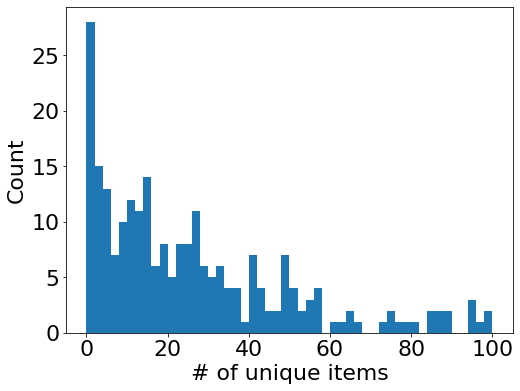

In [113]:
show_distribution(leaf_member = leaf_items)

In [106]:
# show_distribution(leaf_member = leaf_users)

# Same item in how many different leaf nodes?

mean:1.146259, std:5.084856


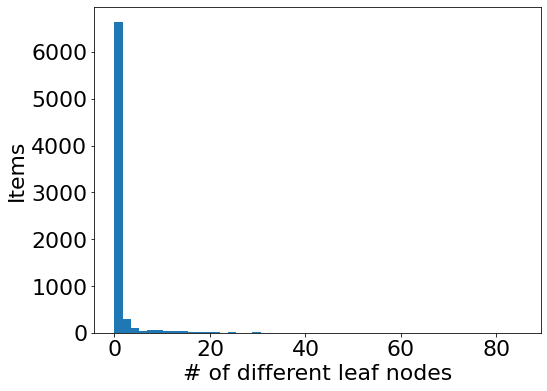

In [122]:
leaf_count_item = np.zeros(num_items)
for d in leaf_items:
    items = list(d.keys())
#     print(items)
    leaf_count_item[items] += 1
    
np.save('leaf-count-item-lastfm.npy', leaf_count_item)
leaf_count_item = np.sort(leaf_count_item)

plt.figure(figsize = (8,6))
plt.hist(leaf_count_item, bins = 50)
plt.xlabel('# of different leaf nodes')
plt.ylabel('Items')
plt.savefig('leaf_count_item-lastfm', dpi = 400)

print("mean:%f, std:%f"%(np.mean(leaf_count_item), np.std(leaf_count_item)))

# --------------------------------------------------------

In [159]:
class Model: 
    '''wrapper class'''
    def __init__(self, tree):
        self.tree = tree
        self.left = T
        
    def ask(self, node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            left -= 1
                
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  self.ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            left -= 1
                
            if(not node.neg_node.vector is None):
                return self.ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
            
    def predict(self,reviews):
        pred = []
        for r in reviews:
#             print(r, self.tree.root)
            positive_attribute, node, n_left = self.ask(node = self.tree.root, single_review = r, left = self.left)
    
            pred.append(node.vector)
        
        pred = np.array(pred)
        return pred

In [160]:
# MRR5(model = Model(forest[0]), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [161]:
# MRR5(model = Model(review_tree), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [163]:
DTCRS(model = Model(review_tree), V = V, user_interaction=val_user_interaction, reviews=val_review)

78.564 8.346 0.644
75.3625 8.334 0.658
79.465 8.360666666666667 0.6476666666666666
80.7605 8.35725 0.646
79.3622 8.3732 0.6458
78.29 8.3665 0.6466666666666666
78.46514285714285 8.36042857142857 0.6482857142857142


0.6484722222222222

# Main FACT-CRS

In [251]:
def diffnegfactCRS(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            new_attr = False
            if(not node.feature in qa):
                left -= 1
                new_attr = True
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                
                if(new_attr):
#                     print("pos att")
                    return positive_attribute + 1, n, left
                else:
                    return positive_attribute, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)

            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        
        sulist = []
        success_turn = False

        identified_attribute = 0
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            identified_attribute += positive_attribute

            asked_tree.add(next_tree)
            left-= 1
            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)

#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            sulist.append(su)
            su = np.mean(sulist, axis = 0)
            
        
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                success_turn = True
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
                move_towards_items = []
                while(len(move_towards_items) < N_MOVE_TOWARD and cand < len(sorted_leaf_candidates)):
                    if(not sorted_leaf_candidates[cand] in already_rec):
                        move_towards_items.append(sorted_leaf_candidates[cand])
                    cand += 1
                if (move_towards_items):
#                     print("moving")
#                     su += ALPHA_POS* (np.mean(move_towards_items, axis = 0)) # move toward the latter items
#                     su = su/(1+ALPHA_POS)

                    su += ALPHA_POS*np.mean(move_towards_items, axis = 0) - ALPHA_NEG*np.mean(recommend, axis = 0) # move toward the latter items
                    su = su/(1+ALPHA_POS-ALPHA_NEG)
                    pass
                
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        
        total_turn += turn_count
        n_attribute = reviews[review_id].sum()
        if(success_turn):
            success_len.append(n_attribute)
            nk_success[(n_attribute, identified_attribute)] = 1 + nk_success.get((n_attribute, identified_attribute), 0)
        else:
            failed_len.append(n_attribute)
            nk_failed[(n_attribute, identified_attribute)] = 1 + nk_failed.get((n_attribute, identified_attribute), 0)

        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)

In [280]:
EARLY_STOPPING = 250
ALPHA_POS = 1e-5
ALPHA_NEG = 1e-4
N_MOVE_TOWARD = 10


rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()

success_len = []
failed_len = []
nk_success = {}
nk_failed = {}
diffnegfactCRS(forest = forest, V = V, user_interaction = val_user_interaction, reviews = val_review)
print("DONE!")

6.762 0.723
6.6865 0.7195
6.742666666666667 0.7106666666666667
6.73775 0.71475
6.7494 0.7094
6.7355 0.7106666666666667
6.727285714285714 0.7131428571428572
6.733611111111111 0.7129166666666666
DONE!


In [279]:
rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()

success_len = []
failed_len = []
nk_success = {}
nk_failed = {}
diffnegfactCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)
print("DONE!")

6.717 0.702
6.6995 0.714
6.653666666666667 0.719
6.6465 0.72175
6.6588 0.7176
6.684 0.7156666666666667
6.6574285714285715 0.7197142857142858
6.655555555555556 0.7190277777777778
DONE!


### calculate mu and sigma

In [281]:
print('success')
print(np.mean(success_len), np.std(success_len))
print('failed')
print(np.mean(failed_len), np.std(failed_len))
print('all')
print(np.mean(test_review.sum(axis = 1)), np.std(test_review.sum(axis = 1)))

success
5.658873952854082 1.1321840379468815
failed
5.151910982099661 1.1631122754376226
all
5.51 1.1512843070048144


In [282]:
def success_greater_than(k):
    print(1 - (np.array(failed_len) > k).sum() / sum(test_review.sum(axis = 1) > k))

success_greater_than(0)
success_greater_than(1)
success_greater_than(2)
success_greater_than(3)
success_greater_than(4)
success_greater_than(5)
success_greater_than(6)

0.7129166666666666
0.7129166666666666
0.7129166666666666
0.7214611872146119
0.7512998266897747
0.7839712304135629
0.8265432098765432


[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.16666667 0.52112676 0.6744186  0.5483871         nan        nan
         nan        nan        nan        nan]
 [0.2972973  0.60273973 0.68956044 0.52705882 0.44230769        nan
         nan        nan        nan        nan]
 [0.4516129  0.62121212 0.8372093  0.64322251 0.5664557  0.62893082
         nan        nan        nan        nan]
 [0.3125     0.7        0.89487179 0.7820197  0.65869565 0.68945312
  0.4               nan        nan        nan]
 [1.         0.         0.90625    0.89679715 0.88709677 0.73603083
  0.19354839        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan

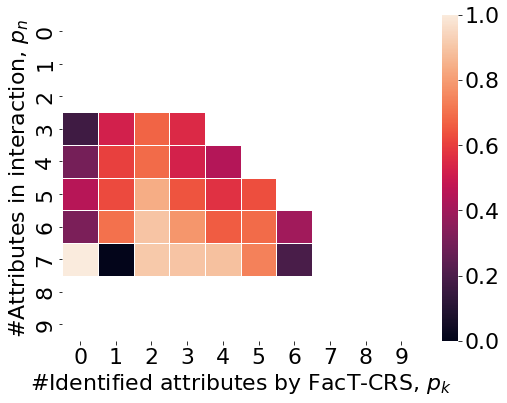

In [283]:
res = np.zeros((T, T))

for n in range(0, T):
    for k in range(0, T):
        nk_s = nk_success.get((n,k), 0)
        nk_f = nk_failed.get((n,k), 0)
        
        if((nk_s + nk_f) == 0):
            res[n,k] = np.nan
        else:
            res[n,k] = nk_s /(nk_s + nk_f)

print(res)

import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.figure(figsize = (8,6))
ax = sns.heatmap(res, linewidth=0.5)
plt.xlabel('#Identified attributes by FacT-CRS, '+r'$p_k$')
plt.ylabel('#Attributes in interaction, '+r'$p_n$')
plt.savefig('heatmap-lastfm.png',dpi = 400)
plt.show()

In [284]:
len(val_user_interaction), len(test_user_interaction)

(7200, 7200)

# rec success

rec_probability at turn 1 : 0.0
rec_probability at turn 2 : 0.0
rec_probability at turn 3 : 0.03171531925633044
rec_probability at turn 4 : 0.3758676460677943
rec_probability at turn 5 : 0.25425958818498784
rec_probability at turn 6 : 0.14929279082808897
rec_probability at turn 7 : 0.22995204273659928
rec_probability at turn 8 : 0.21165982169688471
rec_probability at turn 9 : 0.8827207899067471
rec_probability at turn 10 : 1.0
rec_success at turn 3 : 0.09549071618037135
rec_success at turn 4 : 0.2223218287763335
rec_success at turn 5 : 0.20491591203104786
rec_success at turn 6 : 0.17487479131886477
rec_success at turn 7 : 0.1747624076029567
rec_success at turn 8 : 0.1353525792711784
rec_success at turn 9 : 0.30897340293313447
rec_success at turn 10 : 0.13013505908835116


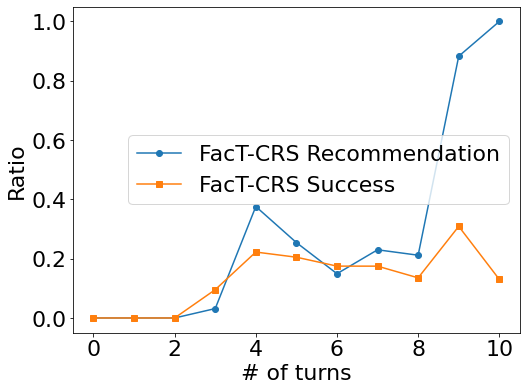

In [293]:
rec_probability = np.zeros(T+1)
for turn in range(1,T+1):
    if((rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0)) > 0):
        rec_probability[turn]  = rec_made_at.get(turn, 0)/(rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0))
        print("rec_probability at turn", turn, ":", rec_probability[turn])
        
rec_success_probability = np.zeros(T+1)
for turn in range(0,T+1):
    if((rec_made_at.get(turn, 0)) > 0):
        rec_success_probability[turn] = rec_success_at.get(turn,0)/rec_made_at.get(turn, 0)
        print("rec_success at turn", turn, ":", rec_success_probability[turn])
        
        
length = range(0,T+1)




plt.figure(figsize = (8,6))

np.save('rec-prob-lastfm-9.npy', rec_probability)
np.save('rec-succ-lastfm-9.npy',rec_success_probability)

plt.plot(length,rec_probability[0:T+1], label='FacT-CRS Recommendation', marker = 'o')
plt.plot(length,rec_success_probability[0:T+1], label='FacT-CRS Success', marker = 's')

plt.xlabel('# of turns')
plt.ylabel('Ratio')
plt.legend()
plt.savefig('rec-succ.png',dpi = 400)

# Ablation Study

### w/o candidate

In [286]:
# previously MRR10

def FacTCRS_RankingOnly(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        sulist = []
        
        already_rec = set()
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            
#             print(left)
            
            asked_tree.add(forest[next_tree])
            left-=1
            
            sulist.append(node.vector)
            su = np.mean(sulist, axis = 0)
            
            pred = -su.dot(V.T)
            sorted_list = np.argsort(pred)
#             time.sleep(1)
            kcount = 0
            recommend = []
            while(len(recommend) < topK):
                if not sorted_list[kcount] in already_rec:
                    recommend.append(sorted_list[kcount])
                    already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                kcount += 1
        
#             print("target:", i, "recommend:", recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
#                 print('success')
                success += 1
                turn_count = T - left
                break
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (forest[tree_idx] in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
        
        

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)

# FacTCRS_RankingOnly(forest = forest, V = V, user_interaction=val_user_interaction, reviews=val_review)
FacTCRS_RankingOnly(forest = forest, V = V, user_interaction=test_user_interaction, reviews=test_review)

8.333 0.579
8.345 0.5775
8.330666666666668 0.5823333333333334
8.3505 0.5785
8.367 0.577
8.392 0.5735
8.370571428571429 0.5787142857142857
8.36486111111111 0.5788888888888889


In [287]:
def factCRSoneTree(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    

    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
#         sulist = []
        
        while(left > 0 and treecnt <= 1):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             sulist.append(su)
#             su = np.mean(sulist, axis = 0)
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)
    
factCRSoneTree(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

8.28 0.352
8.246 0.3645
8.245 0.36233333333333334
8.2695 0.357
8.2944 0.3514
8.334333333333333 0.345
8.307142857142857 0.349
8.303472222222222 0.34930555555555554


In [288]:
def noEarlyRec(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= 0: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)

            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        
        sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)

#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            sulist.append(su)
            su = np.mean(sulist, axis = 0)
            
        
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
                move_towards_items = []
                while(len(move_towards_items) < N_MOVE_TOWARD and cand < len(sorted_leaf_candidates)):
                    if(not sorted_leaf_candidates[cand] in already_rec):
                        move_towards_items.append(sorted_leaf_candidates[cand])
                    cand += 1
                if (move_towards_items):
#                     print("moving")
#                     su += ALPHA_POS* (np.mean(move_towards_items, axis = 0)) # move toward the latter items
#                     su = su/(1+ALPHA_POS)

                    su += ALPHA_POS*np.mean(move_towards_items, axis = 0) - ALPHA_NEG*np.mean(recommend, axis = 0) # move toward the latter items
#                     su = su/(1+ALPHA_POS-ALPHA_NEG)
                    pass
                
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)
    
noEarlyRec(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

9.673 0.415
9.6765 0.411
9.676666666666666 0.411
9.677 0.41175
9.683 0.4076
9.688833333333333 0.4021666666666667
9.682142857142857 0.4102857142857143
9.68138888888889 0.4101388888888889


In [289]:
def factCRSwithoutNeg(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             sulist.append(su)
#             su = np.mean(sulist, axis = 0)
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)


In [290]:
factCRSwithoutNeg(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

6.661 0.685
6.655 0.699
6.582333333333334 0.711
6.58425 0.71075
6.5926 0.7068
6.622333333333334 0.7005
6.592428571428571 0.7051428571428572
6.589027777777778 0.7045833333333333


In [265]:
# rec_made_at = dict()
# ques_asked_at = dict()
# rec_success_at = dict()

# def varytopKCRS(forest, V, user_interaction, reviews):
    
#     topK = 50
    
#     mrr = 0
#     count = 0
#     success = 0
    
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left+1
    
    
#         val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left    
    
    
#     def traverse(node, single_review):
#         positive_attribute = 0
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node
#         if(not node.feature in qa):
#             return positive_attribute, node
    
#         val = single_review[node.feature]
#         if(val > 0):
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n =  traverse(node.pos_node, single_review)
#                 return positive_attribute + 1, n
#             else:
#                 return positive_attribute, node
#         else:                
#             if(not node.neg_node.vector is None):
#                 return traverse(node.neg_node, single_review)
#             else:
#                 return positive_attribute, node
    
    
    
#     total_turn = 0
    
#     for (review_id, interaction) in enumerate(user_interaction):
#         count += 1
#         u, i = interaction
        
#         next_tree = 0
#         asked_tree = set()
#         qa = dict()
#         left = T
#         treecnt = 0
#         turn_count = T
        
        
#         already_rec = set()
        
#         while(left > 0 and treecnt < N_TREE):
#             review_tree = forest[next_tree]
#             treecnt += 1
            
# #             print("Now traversing: ", next_tree)
            
#             positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
#             asked_tree.add(next_tree)
#             left -= 1
# #             print("traversed the tree...")
            
#             su = copy.deepcopy(node.vector)
#             leaf_candidates = np.unique(train_user_interaction[node.members,1])
# #             print(leaf_candidates)
#             score = -V[leaf_candidates].dot(su)
#             idx = np.argsort(score)
#             sorted_leaf_candidates = leaf_candidates[idx]

#             recommend = []
#             cand = 0
#             while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
#                 if(not sorted_leaf_candidates[cand] in already_rec):
#                     recommend.append(sorted_leaf_candidates[cand])
#                     already_rec.add(sorted_leaf_candidates[cand])
#                 cand += 1
            
#             ranked_recommend = []
#             if(len(recommend) < topK):
#                 pred = -su.dot(V.T)
#                 sorted_list = np.argsort(pred)
#     #             print("target:", i, "recommend:", recommend)
#     #             time.sleep(1)
#                 kcount = 0
#                 while(len(recommend) < topK):
#                     if not sorted_list[kcount] in already_rec:
#                         recommend.append(sorted_list[kcount])
#                         ranked_recommend.append(sorted_list[kcount])
#                         already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
#                     kcount += 1
        
# #             print(recommend)
# #             rank = np.where(recommend == i)[0]
# #             mrr += (rank+1)

#             rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             if(i in recommend):
#                 rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
#                 success += 1
#                 turn_count = T - left
#                 break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)

# #                 su += ALPHA_NEG* np.mean(V[idx[40:50]], axis = 0)
                    
            
#             best_match = -math.inf  ## CTF
#             for tree_idx in range(len(forest)):
#                 if (tree_idx in  asked_tree):
#                     continue
#                 _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
#                 probable_su = probable_node.vector
#                 sim = np.dot(probable_su, su)
#                 if( sim > best_match):
#                     best_match = sim
#                     next_tree = tree_idx
            
# #             print("Checked all using history")

#         total_turn += turn_count
    

#     print(total_turn/count, success/count)
    
# varytopKCRS(forest = forest, V = V,user_interaction = test_user_interaction[:firstr], reviews = test_review[:firstr])

In [266]:
# rec_made_at = dict()
# ques_asked_at = dict()
# rec_success_at = dict()
# def factCRS(forest, V, user_interaction, reviews):
#     mrr = 0
#     count = 0
#     success = 0
    
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left+1
    
    
#         val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left   
    
    
    
#     def traverse(node, single_review):
#         positive_attribute = 0
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node
#         if(not node.feature in qa):
#             return positive_attribute, node
    
#         val = single_review[node.feature]
#         if(val > 0):
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n =  traverse(node.pos_node, single_review)
#                 return positive_attribute + 1, n
#             else:
#                 return positive_attribute, node
#         else:                
#             if(not node.neg_node.vector is None):
#                 return traverse(node.neg_node, single_review)
#             else:
#                 return positive_attribute, node
    
    
    
#     total_turn = 0
    
#     for (review_id, interaction) in enumerate(user_interaction):
#         count += 1
#         u, i = interaction
        
#         next_tree = 0
#         asked_tree = set()
#         qa = dict()
#         left = T
#         treecnt = 0
#         turn_count = T
        
        
#         already_rec = set()
        
#         while(left > 0 and treecnt < N_TREE):
#             review_tree = forest[next_tree]
#             treecnt += 1
            
# #             print("Now traversing: ", next_tree)
            
#             positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
#             asked_tree.add(next_tree)
            
# #             print("traversed the tree...")
            
#             su = copy.deepcopy(node.vector)
#             leaf_candidates = np.unique(train_user_interaction[node.members,1])
# #             print(leaf_candidates)
#             score = -V[leaf_candidates].dot(su)
#             idx = np.argsort(score)
#             sorted_leaf_candidates = leaf_candidates[idx]

#             recommend = []
#             cand = 0
#             while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
#                 if(not sorted_leaf_candidates[cand] in already_rec):
#                     recommend.append(sorted_leaf_candidates[cand])
#                     already_rec.add(sorted_leaf_candidates[cand])
#                 cand += 1
            
#             ranked_recommend = []
#             if(len(recommend) < topK):
#                 pred = -su.dot(V.T)
#                 sorted_list = np.argsort(pred)
#     #             print("target:", i, "recommend:", recommend)
#     #             time.sleep(1)
#                 kcount = 0
#                 while(len(recommend) < topK):
#                     if not sorted_list[kcount] in already_rec:
#                         recommend.append(sorted_list[kcount])
#                         ranked_recommend.append(sorted_list[kcount])
#                         already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
#                     kcount += 1
        
# #             print(recommend)
# #             rank = np.where(recommend == i)[0]
# #             mrr += (rank+1)

#             rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             if(i in recommend):
#                 rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
#                 success += 1
#                 turn_count = T - left
#                 break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
#             best_match = -math.inf  ## CTF
#             for tree_idx in range(len(forest)):
#                 if (tree_idx in  asked_tree):
#                     continue
#                 _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
#                 probable_su = probable_node.vector
#                 sim = np.dot(probable_su, su)
#                 if( sim > best_match):
#                     best_match = sim
#                     next_tree = tree_idx
            
# #             print("Checked all using history")

#         total_turn += turn_count
#         if((count) % 1000 == 0):
# #             print(mrr/(count*treecnt), success/(count))
#             print(total_turn/count, success/count)
    
# factCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

In [267]:
# # review_tree = forest[0]


# def compare(reviews, interaction):
    
#     leaf_success = 0
#     pred_success = 0
    
#     nk_success = {}
#     nk_failed = {}
    
#     qa = dict()
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left
    
    
#         val = single_review[node.feature]
                
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left
    
    
    
    
    
#     for r_id in range(len(reviews)):
#         r = reviews[r_id]
#         u, i = interaction[r_id]
        
#         n_attribute = r.sum()
#         identified_attribute, node, _ = ask(node = review_tree.root, single_review = r, left = 15)
        
        
#         members = node.members
#         vector = node.vector
            
#         pred = -V.dot(vector)
#         recommend = np.argsort(pred)[:topK]
        
        
#         if(i in recommend):
#             pred_success +=1
#             nk_success[(n_attribute, identified_attribute)] = 1 + nk_success.get((n_attribute, identified_attribute), 0)
#         else:
#             nk_failed[(n_attribute, identified_attribute)] = 1 + nk_failed.get((n_attribute, identified_attribute), 0)
            
        
#         all_candidates = np.unique(train_user_interaction[members,1])
#         if(len(all_candidates) > topK):
#             score = -V[all_candidates].dot(vector)
#             idx = np.argpartition(score, topK)[:topK]
#             all_candidates = all_candidates[idx]
        
#         all_candidates = set(all_candidates)
#         cand = 0
#         while(len(all_candidates) < topK):
#             all_candidates.add(recommend[cand])
#             cand += 1
        
        
#         if (i in all_candidates):
#             leaf_success += 1
#             successful_rid.append(r_id)
#         else:
#             rejected_items.append(i)
#             rejected_reviews.append(r)
            
#         global leaf_0_success, pred_0_success
#         if (identified_attribute == 0 and i in all_candidates and i not in recommend[:cand]):
#             leaf_0_success += 1
#         elif (identified_attribute == 0 and i in recommend):
#             pred_0_success +=  1
            
        
#     print("leaf_success:", leaf_success/len(reviews)), print("pred_success:", pred_success/len(reviews))
# #     print(np.mean(successN), np.std(successN))
# #     plt.hist(successN, range=(0,2000))
#     return nk_success, nk_failed

# leaf_0_success = 0
# pred_0_success = 0

# rejected_items = []
# rejected_reviews = []
# successful_rid = []






# nk_success,nk_failed = compare(reviews=val_review, interaction=val_user_interaction)

# print(leaf_0_success, pred_0_success)

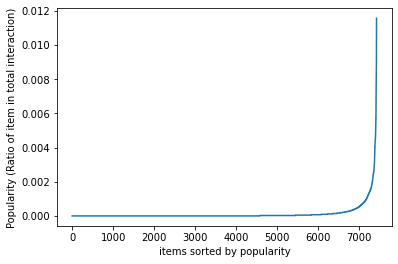

In [197]:
## item hit
rejected_uniq_items = np.unique(rejected_items)
# print(item_hit[rejected_uniq_items]).mean(), item_hit[rejected_uniq_items].std())
plt.plot(sorted(item_hit/len(train_review)))

plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
# plt.plot(sorted(item_hit[rejected_items]/len(train_review)))
# plt.show()
plt.savefig('popularity-all.png', dpi = 400)

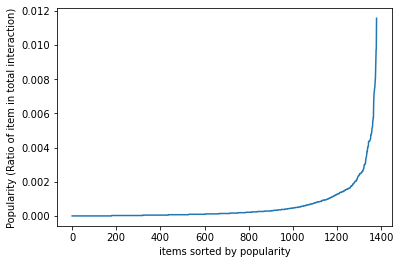

In [196]:
plt.plot(sorted(item_hit[rejected_uniq_items]/len(train_review)))
plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
plt.savefig('popularity-failed.png', dpi = 400)

In [118]:
print((sum(item_hit/len(train_review) > 0.001)) / len(item_hit))

print((sum(item_hit[rejected_uniq_items]/len(train_review) > 0.001)) / len(rejected_uniq_items))


0.03257942918686053
0.15797101449275364


# False positive and negative

In [ ]:
def count_fp_fn(node, single_review, depth, target):

    fp = False
    fn = False
    
    if(node.feature is None):
#         print("leaf node")
        return node.members, depth, node.vector, fp, fn
#     print("Q{}: {} > 0?:".format(depth+1, node.feature))   

    val = single_review[node.feature]

    if(val > 0):
#         print("yes")
        
        if(train_item_opinion[target, node.feature] <= 0 ):
            fp = True
            
        if(not node.pos_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        
    else:
#         print("no")
        if(train_item_opinion[target, node.feature] > 0 ):
            fn = True
            
        if(not node.neg_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        

In [ ]:

def total_fp_fn(reviews, interaction):
    
    success_fp = 0
    success_fn = 0

    failure_fp = 0
    failure_fn = 0

    success = 0
    
#     for r_id in range(len(reviews)):
    for r_id in range(4800):
        r = reviews[r_id]
        u, i = interaction[r_id]

        members, _, vector, fp, fn = count_fp_fn(node = review_tree.root, single_review = r, depth = 0, target = i)
        
        su = review_model.predict(r.reshape(1,-1))#??????????????????????
        pred = -su.dot(V.T)[0]
#         recommend = np.argsort(pred)
        
#         pred = -vector.dot(V.T)
        recommend = np.argpartition(pred, topK)[:topK]
        if(i in recommend): #success
            success += 1
            if(fp):
                success_fp += 1
            if(fn):
                success_fn += 1
        else: #failure
            if(fp):
                failure_fp += 1
            if(fn):
                failure_fn += 1
                
        if((r_id+1)%1000 == 0):
            print(success/(r_id+1))
    
    print(success, success_fp, success_fn, failure_fp, failure_fn)
                
total_fp_fn(reviews=test_review, interaction=test_user_interaction)

## Done

In [669]:
# SU, V = loadSUV(i=0)
# MRR1(SU = SU_new, V=V, user_interaction = train_user_interaction)
# print("-----------------------")
# MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)


In [ ]:
i = 500
V[i], V_copy[i]

In [ ]:
j = 500
SU[j], SU_new[j]

In [ ]:
saveSUV(i=1)

In [ ]:
def save_tree(i):
    with open("review_tree_{}.pkl".format(i), "wb") as f:
        pickle.dump(review_tree, f)
        
def load_tree(i):
    with open("review_tree_{}.pkl".format(i), "rb") as f:
        pickle.dump(review_tree, f)

In [ ]:
save_tree(i = 1)

In [ ]:
saveSUV(i=1)

In [ ]:
SU, _ = loadSUV(i = 1)

# ----------------------------------------------------------------

# ----------------------------------------------------------------

In [ ]:
import os.path
import time

MAX_ITER = 50
SGD_ITER = 1500

for i in range(0,MAX_ITER+1):
    
    fpath = "V_{}.npy".format(i)
    while not os.path.exists(fpath):
        print("waiting for ", fpath)
        time.sleep(60)
    if os.path.isfile(fpath):
        V = np.load('V_{}.npy'.format(i))
    else:
        raise ValueError("%s isn't a file!" % fpath)
        
    create_tree(tree_type="item", node=item_tree.root, depth=0)
    print_tree(item_tree.root, 0, 0)
    
    review_model = Model(tree = item_tree)
    SU_new, V_copy = personalize(model = item_model, num_iter = SGD_ITER)
    
    print("RESULT OF ITERATION...")
    MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)
    
    SU = SU_new
    np.save('SU_{}'.format(i), SU)
    save_tree(i = i)
    review_tree = Tree(tree_type = "review")


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [161]:
s = "this is a, string"
tokens = s.split(",")
for t in tokens:
    print(t)

this is a
 string


In [177]:
import re
re.split('\.\+', "This.is.working+maybe")

['This.is.working+maybe']

In [179]:
s = "this is a"

news = ""

for c in s:
    news = c+news

news

'a si siht'